# LAPAGE

# 0. Nettoyage

* Présentez l'ensemble des choix et actions que vous avez réalisés
* Restitution de l'analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, ...
* Calcul de l'indicateur de corrélation (R², eta², Chi²) et la mise en place d'un test statistique est nécessaire

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import missingno as msno
import matplotlib.cm as cm
import seaborn as sns
from random import randint, seed
from matplotlib.ticker import FuncFormatter
from statistics import median
from functions import *
from scipy.stats import pearsonr 
from scipy.stats import chi2_contingency
from os import getcwd

['<20 ans', 'de 20 à 30 ans', 'de 30 à 40 ans', 'de 40 à 50 ans', 'de 50 à 60 ans', 'de 60 à 70 ans', '+70 ans']


In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
# Récupère le répertoire du programme
file_path = getcwd() + "\\"

Chargement des données...


In [3]:
print(file_path)

c:\Users\User\WORK\wokspace-simplon3\simplon\projets\lapage\


In [4]:
file_name_customers = 'customers.csv'
file_name_procuts = 'products.csv'
file_name_transactions = 'transactions.csv'

df_customers = pd.read_csv(file_path+file_name_customers, sep=',')
df_products = pd.read_csv(file_path+file_name_procuts, sep=',')
df_transactions = pd.read_csv(file_path+file_name_transactions, sep=',')

print("Chargement des données", df_customers.shape,df_products.shape,df_transactions.shape, ".... ...................................... END")

Chargement des données (8623, 3) (3287, 3) (679532, 4) .... ...................................... END


In [5]:
df_customers.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [6]:
df_customers["client_id"].nunique()

8623

In [7]:
df_customers = df_customers.drop_duplicates("client_id", keep='first')
df_customers.shape

(8623, 3)

In [8]:
df_products.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [9]:
df_products.describe(include="all")

id_prod        price        categ
count     3287  3287.000000  3287.000000
unique    3287          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.856641     0.370246
std        NaN    29.847908     0.615387
min        NaN    -1.000000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.060000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000

Il ne peut pas y avoir de produit avec un prix négatif, supression des produits avec un prix négatif

In [10]:
df_products_clean = df_products[df_products["price"]>=0]
print(df_products.shape, "vs", df_products_clean.shape)

(3287, 3) vs (3286, 3)


In [11]:
df_products_clean["id_prod"].nunique()

3286

In [12]:
df_products_clean.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [13]:
print(df_products_clean.shape, end="")
df_products_clean = df_products_clean.drop_duplicates("id_prod", keep='first')
df_products_clean.shape

(3286, 3)

(3286, 3)

In [14]:
df_transactions.head()

id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232

In [15]:
df_transactions.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id']).value_counts()

False    679406
True        126
dtype: int64

Il semble y avoir des doublons dans le fichier de transactions, nous allons zoomer dessus

In [16]:
df_doublon = df_transactions[df_transactions.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id'])]
df_doublon

id_prod                             date session_id client_id
27778      T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
52424      T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
96687      T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
130188     T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
139339     T_0  test_2021-03-01 02:30:02.237443        s_0      ct_1
...        ...                              ...        ...       ...
653098     T_0  test_2021-03-01 02:30:02.237432        s_0      ct_0
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[126 rows x 4 columns]

il semblerait que les produits soient tous "T_0" à voir, peut-être s'agit-il d'un test, la date indiquée semble confirmer qu'il s'agit d'un test.

In [17]:
df_doublon["id_prod"].value_counts()

T_0    126
Name: id_prod, dtype: int64

In [18]:
df_products[df_products["id_prod"]=="T_0"]

id_prod  price  categ
731     T_0   -1.0      0

In [19]:
df_products[df_products["id_prod"]=="0_2245"]

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []

In [20]:
df_transactions_clean = df_transactions[df_transactions["id_prod"]!="T_0"]
print(df_transactions.shape, "vs", df_transactions_clean.shape)

(679532, 4) vs (679332, 4)


In [21]:
df_transactions_clean.duplicated(subset=['id_prod', 'date', 'session_id', 'client_id']).value_counts()

False    679332
dtype: int64

On créé un DF global avec toutes les informations

In [22]:
print(df_transactions_clean.shape, end="")
df_global = df_transactions_clean.merge(df_products_clean, on="id_prod", how='outer', indicator=True)
df_global.shape

(679332, 4)

(679353, 7)

In [23]:
print(df_transactions_clean.shape, end="")
df_global = df_transactions_clean.merge(df_products_clean, on="id_prod", how='outer', indicator=True)
df_global.shape

(679332, 4)

(679353, 7)

In [24]:
df_global.head()

id_prod                        date session_id client_id  price  categ  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   
1  0_1518  2021-09-26 12:37:29.780414    s_95811    c_6197   4.18    0.0   
2  0_1518  2021-05-06 17:14:43.117440    s_30782     c_682   4.18    0.0   
3  0_1518  2022-03-16 18:57:10.420103   s_180057    c_5932   4.18    0.0   
4  0_1518  2022-11-12 18:58:10.574853   s_296584    c_7217   4.18    0.0   

  _merge  
0   both  
1   both  
2   both  
3   both  
4   both

In [25]:
df_global["_merge"].value_counts()

both          679111
left_only        221
right_only        21
Name: _merge, dtype: int64

In [26]:
not_commons = df_global[df_global["_merge"]!="both"]
not_commons.shape

(242, 7)

In [27]:
not_commons.head()

id_prod                        date session_id client_id  price  categ  \
542560  0_2245  2022-09-23 07:22:38.636773   s_272266    c_4746    NaN    NaN   
542561  0_2245  2022-07-23 09:24:14.133889   s_242482    c_6713    NaN    NaN   
542562  0_2245  2022-12-03 03:26:35.696673   s_306338    c_5108    NaN    NaN   
542563  0_2245  2021-08-16 11:33:25.481411    s_76493    c_1391    NaN    NaN   
542564  0_2245  2022-07-16 05:53:01.627491   s_239078    c_7954    NaN    NaN   

           _merge  
542560  left_only  
542561  left_only  
542562  left_only  
542563  left_only  
542564  left_only

In [28]:
not_commons.isna().sum()

id_prod         0
date           21
session_id     21
client_id      21
price         221
categ         221
_merge          0
dtype: int64

In [29]:
not_commons[not_commons["price"].isna()]

id_prod                        date session_id client_id  price  categ  \
542560  0_2245  2022-09-23 07:22:38.636773   s_272266    c_4746    NaN    NaN   
542561  0_2245  2022-07-23 09:24:14.133889   s_242482    c_6713    NaN    NaN   
542562  0_2245  2022-12-03 03:26:35.696673   s_306338    c_5108    NaN    NaN   
542563  0_2245  2021-08-16 11:33:25.481411    s_76493    c_1391    NaN    NaN   
542564  0_2245  2022-07-16 05:53:01.627491   s_239078    c_7954    NaN    NaN   
...        ...                         ...        ...       ...    ...    ...   
542776  0_2245  2021-08-25 09:06:03.504061    s_80395     c_131    NaN    NaN   
542777  0_2245  2022-03-06 19:59:19.462288   s_175311    c_4167    NaN    NaN   
542778  0_2245  2022-05-16 11:35:20.319501   s_209381    c_4453    NaN    NaN   
542779  0_2245  2022-02-11 09:05:43.952857   s_163405    c_1098    NaN    NaN   
542780  0_2245  2021-12-14 22:34:54.589921   s_134446    c_4854    NaN    NaN   

           _merge  
542560  left_only  
542561  left_only  
542562  left_only  
542563  left_only  
542564  left_only  
...           ...  
542776  left_only  
542777  left_only  
542778  left_only  
542779  left_only  
542780  left_only  

[221 rows x 7 columns]

In [30]:
not_commons[not_commons["price"].isna()].describe(include="all")

id_prod                        date session_id client_id  price  categ  \
count      221                         221        221       221    0.0    0.0   
unique       1                         221        221       100    NaN    NaN   
top     0_2245  2022-09-23 07:22:38.636773   s_272266    c_1533    NaN    NaN   
freq       221                           1          1         6    NaN    NaN   
mean       NaN                         NaN        NaN       NaN    NaN    NaN   
std        NaN                         NaN        NaN       NaN    NaN    NaN   
min        NaN                         NaN        NaN       NaN    NaN    NaN   
25%        NaN                         NaN        NaN       NaN    NaN    NaN   
50%        NaN                         NaN        NaN       NaN    NaN    NaN   
75%        NaN                         NaN        NaN       NaN    NaN    NaN   
max        NaN                         NaN        NaN       NaN    NaN    NaN   

           _merge  
count         221  
unique          1  
top     left_only  
freq          221  
mean          NaN  
std           NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN

le produit 0_2245 n'apparaît pas dans la base de produit.
Il a pu être sortit de la base ou erreur ?

In [31]:
df_global_clean =  df_global[df_global["id_prod"]!="0_2245"]
df_global_clean.shape

(679132, 7)

In [32]:
not_commons = df_global_clean[df_global_clean["_merge"]!="both"]
not_commons.shape

(21, 7)

In [33]:
not_commons.describe(include="all")

id_prod date session_id client_id       price      categ      _merge
count       21    0          0         0   21.000000  21.000000          21
unique      21    0          0         0         NaN        NaN           1
top     0_1016  NaN        NaN       NaN         NaN        NaN  right_only
freq         1  NaN        NaN       NaN         NaN        NaN          21
mean       NaN  NaN        NaN       NaN   37.870476   0.380952         NaN
std        NaN  NaN        NaN       NaN   56.619963   0.740013         NaN
min        NaN  NaN        NaN       NaN    0.800000   0.000000         NaN
25%        NaN  NaN        NaN       NaN    2.990000   0.000000         NaN
50%        NaN  NaN        NaN       NaN   22.050000   0.000000         NaN
75%        NaN  NaN        NaN       NaN   31.820000   0.000000         NaN
max        NaN  NaN        NaN       NaN  220.990000   2.000000         NaN

In [34]:
not_sales_product = not_commons
not_sales_product.head(21)

id_prod date session_id client_id   price  categ      _merge
679332  0_1016  NaN        NaN       NaN   35.06    0.0  right_only
679333  0_1780  NaN        NaN       NaN    1.67    0.0  right_only
679334  0_1062  NaN        NaN       NaN   20.08    0.0  right_only
679335  0_1119  NaN        NaN       NaN    2.99    0.0  right_only
679336  0_1014  NaN        NaN       NaN    1.15    0.0  right_only
679337     1_0  NaN        NaN       NaN   31.82    1.0  right_only
679338  0_1318  NaN        NaN       NaN   20.92    0.0  right_only
679339  0_1800  NaN        NaN       NaN   22.05    0.0  right_only
679340  0_1645  NaN        NaN       NaN    2.99    0.0  right_only
679341   0_322  NaN        NaN       NaN    2.99    0.0  right_only
679342  0_1620  NaN        NaN       NaN    0.80    0.0  right_only
679343  0_1025  NaN        NaN       NaN   24.99    0.0  right_only
679344    2_87  NaN        NaN       NaN  220.99    2.0  right_only
679345   1_394  NaN        NaN       NaN   39.73    1.0  right_only
679346    2_72  NaN        NaN       NaN  141.32    2.0  right_only
679347   0_310  NaN        NaN       NaN    1.94    0.0  right_only
679348  0_1624  NaN        NaN       NaN   24.50    0.0  right_only
679349    2_86  NaN        NaN       NaN  132.36    2.0  right_only
679350   0_299  NaN        NaN       NaN   22.99    0.0  right_only
679351   0_510  NaN        NaN       NaN   23.66    0.0  right_only
679352  0_2308  NaN        NaN       NaN   20.28    0.0  right_only

In [35]:
print(df_global_clean.shape, "vs", end="")
df_global_clean = df_global_clean[df_global_clean["_merge"]=="both"]
df_global_clean.shape

(679132, 7) vs

(679111, 7)

In [36]:
df_global_clean["_merge"].value_counts()

both          679111
left_only          0
right_only         0
Name: _merge, dtype: int64

In [37]:
df_global_clean1 = df_global_clean[["id_prod","date","session_id","client_id","price","categ"]]
df_global_clean1.head()

id_prod                        date session_id client_id  price  categ
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0
1  0_1518  2021-09-26 12:37:29.780414    s_95811    c_6197   4.18    0.0
2  0_1518  2021-05-06 17:14:43.117440    s_30782     c_682   4.18    0.0
3  0_1518  2022-03-16 18:57:10.420103   s_180057    c_5932   4.18    0.0
4  0_1518  2022-11-12 18:58:10.574853   s_296584    c_7217   4.18    0.0

In [38]:
df_customers.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [39]:
print(df_global_clean1.shape, end="")
df_global_full_merge = df_global_clean1.merge(df_customers, on="client_id", how='outer', indicator=True)
df_global_full_merge.shape

(679111, 6)

(679134, 9)

In [40]:
df_global_full_merge["_merge"].value_counts()

both          679111
right_only        23
left_only          0
Name: _merge, dtype: int64

In [41]:
customers_who_never_buy = df_global_full_merge[df_global_full_merge["_merge"]!="both"]
customers_who_never_buy.head()

id_prod date session_id client_id  price  categ sex  birth      _merge
679111     NaN  NaN        NaN    c_8253    NaN    NaN   f   2001  right_only
679112     NaN  NaN        NaN    c_3789    NaN    NaN   f   1997  right_only
679113     NaN  NaN        NaN    c_4406    NaN    NaN   f   1998  right_only
679114     NaN  NaN        NaN      ct_0    NaN    NaN   f   2001  right_only
679115     NaN  NaN        NaN    c_2706    NaN    NaN   f   1967  right_only

In [42]:
customers_who_never_buy.shape

(23, 9)

In [43]:
print(df_global_full_merge.shape, end="")
df_global_full = df_global_full_merge[df_global_full_merge["_merge"]=="both"]
df_global_full.shape

(679134, 9)

(679111, 9)

In [44]:
df_global_full = df_global_full[["id_prod","date","session_id","client_id","price","categ","sex","birth"]]
df_global_full.shape

(679111, 8)

In [45]:
df_global_full.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
dtype: int64

Maintenant que nous avons un DF global nous pouvons nettoyer, organiser et typer les données

In [46]:
df_global_full.head()

id_prod                        date session_id client_id  price  categ sex  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518  2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   
2  0_1518  2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   f   
3  0_1418  2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   f   
4  0_1418  2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   f   

   birth  
0   1986  
1   1986  
2   1986  
3   1986  
4   1986

In [47]:
df_global_full.describe(include="all")

id_prod                        date session_id client_id  \
count   679111                      679111     679111    679111   
unique    3265                      679111     342275      8600   
top      1_369  2022-05-20 13:21:29.043970   s_118668    c_1609   
freq      2252                           1         14     25488   
mean       NaN                         NaN        NaN       NaN   
std        NaN                         NaN        NaN       NaN   
min        NaN                         NaN        NaN       NaN   
25%        NaN                         NaN        NaN       NaN   
50%        NaN                         NaN        NaN       NaN   
75%        NaN                         NaN        NaN       NaN   
max        NaN                         NaN        NaN       NaN   

                price          categ     sex          birth  
count   679111.000000  679111.000000  679111  679111.000000  
unique            NaN            NaN       2            NaN  
top               NaN            NaN       m            NaN  
freq              NaN            NaN  340826            NaN  
mean        17.454773       0.441953     NaN    1977.811149  
std         18.328998       0.595042     NaN      13.575361  
min          0.620000       0.000000     NaN    1929.000000  
25%          8.870000       0.000000     NaN    1970.000000  
50%         13.990000       0.000000     NaN    1980.000000  
75%         18.990000       1.000000     NaN    1987.000000  
max        300.000000       2.000000     NaN    2004.000000

In [48]:
# Réorganisation des colonnes suivant un ordre plus fonctionnel
df_global_ordered = df_global_full[["date", "client_id", "sex", "birth","session_id", "id_prod", "categ", "price"]]
df_global_ordered.head()

date client_id sex  birth session_id id_prod  categ  \
0  2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518    0.0   
1  2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518    0.0   
2  2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518    0.0   
3  2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418    0.0   
4  2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418    0.0   

   price  
0   4.18  
1   4.18  
2   4.18  
3   8.57  
4   8.57

In [49]:
df_global_ordered.dtypes

date           object
client_id      object
sex            object
birth           int64
session_id     object
id_prod        object
categ         float64
price         float64
dtype: object

In [50]:
df_global_ordered["categ"] = df_global_ordered["categ"].astype(int)
df_global_ordered["sex"] = df_global_ordered["sex"].astype('category')
df_global_ordered["date"] = pd.to_datetime(df_global_ordered["date"])
df_global_ordered.dtypes

date          datetime64[ns]
client_id             object
sex                 category
birth                  int64
session_id            object
id_prod               object
categ                  int32
price                float64
dtype: object

In [51]:
df_global_ordered['month_year'] = pd.to_datetime(df_global_ordered["date"]).dt.to_period('M')
df_global_ordered['year'] = pd.to_datetime(df_global_ordered["date"]).dt.to_period('Y')
df_global_ordered['day'] = pd.to_datetime(df_global_ordered["date"]).dt.to_period('D')
df_global_ordered.head()

date client_id sex  birth session_id id_prod  categ  \
0 2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
1 2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2 2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
3 2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
4 2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

   price month_year  year         day  
0   4.18    2022-05  2022  2022-05-20  
1   4.18    2021-07  2021  2021-07-20  
2   4.18    2022-08  2022  2022-08-20  
3   8.57    2022-06  2022  2022-06-18  
4   8.57    2021-08  2021  2021-08-18

In [52]:
print(df_global_ordered.shape)
df_global_ordered["date"].nunique()

(679111, 11)


679111

Les dates sont uniques, nous pouvons donc les mettre en index

In [53]:
df_global_index = df_global_ordered.set_index("date")
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day  
date                                                            
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20  
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20  
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20  
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18  
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18

In [54]:
df_global_index["categ"].value_counts()

0    415459
1    227169
2     36483
Name: categ, dtype: int64

In [55]:
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day  
date                                                            
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20  
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20  
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20  
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18  
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18

<AxesSubplot:>

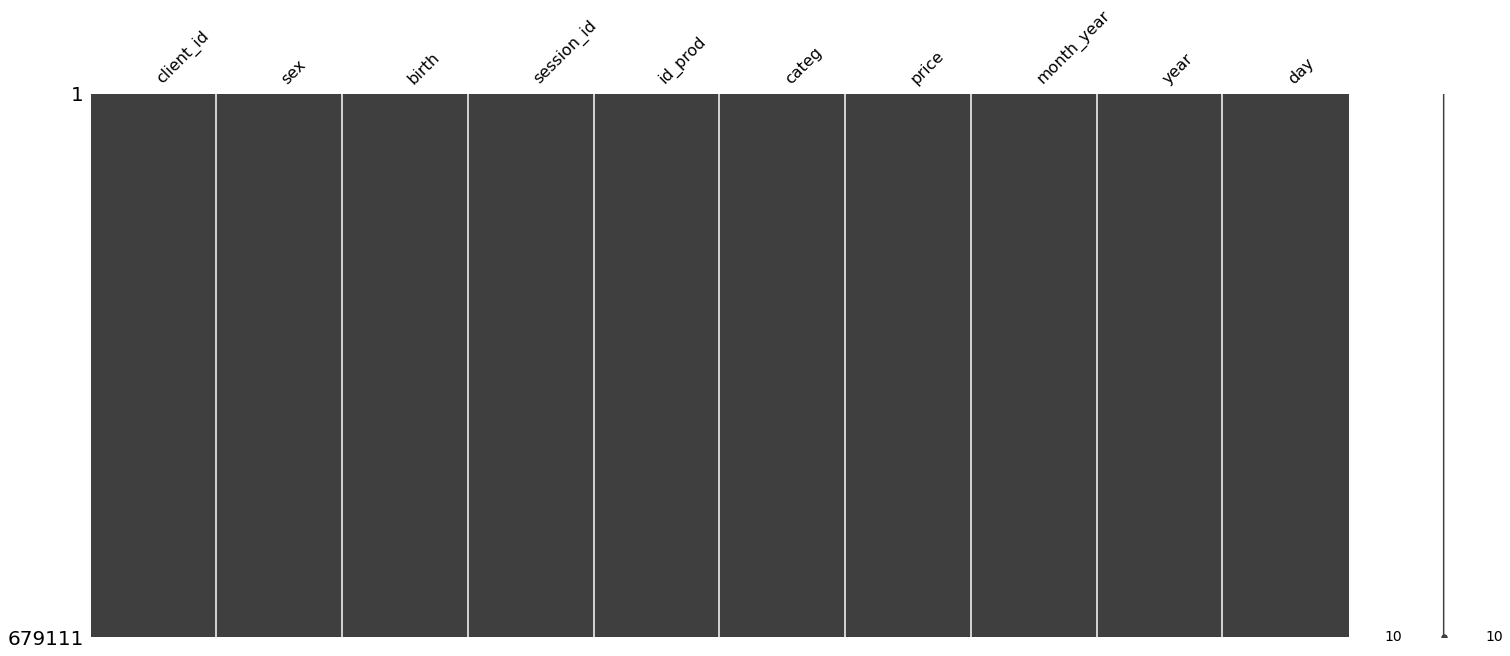

In [56]:
msno.matrix(df_global_index)

<AxesSubplot:>

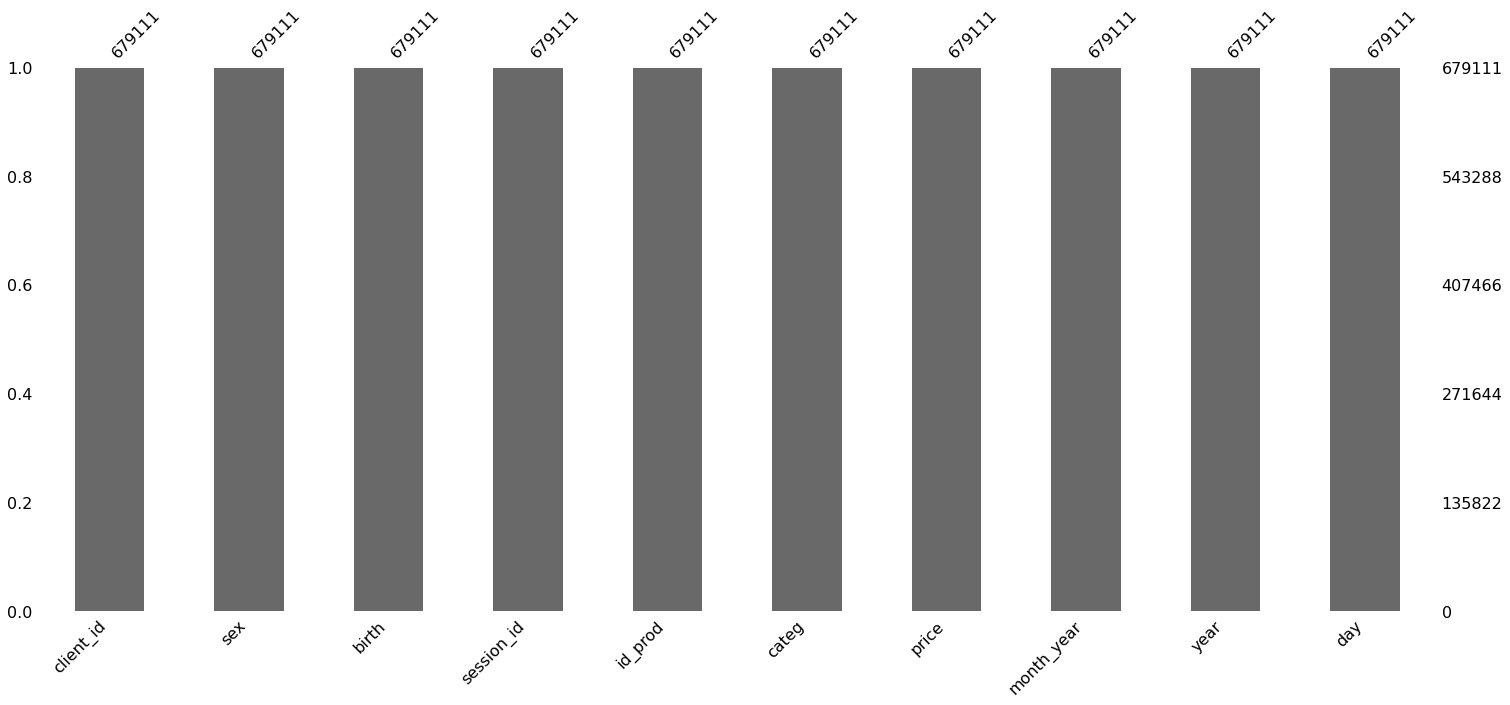

In [57]:
msno.bar(df_global_index)

In [58]:
df_global_index.describe(include="all")

client_id     sex          birth session_id id_prod          categ  \
count     679111  679111  679111.000000     679111  679111  679111.000000   
unique      8600       2            NaN     342275    3265            NaN   
top       c_1609       m            NaN   s_118668   1_369            NaN   
freq       25488  340826            NaN         14    2252            NaN   
mean         NaN     NaN    1977.811149        NaN     NaN       0.441953   
std          NaN     NaN      13.575361        NaN     NaN       0.595042   
min          NaN     NaN    1929.000000        NaN     NaN       0.000000   
25%          NaN     NaN    1970.000000        NaN     NaN       0.000000   
50%          NaN     NaN    1980.000000        NaN     NaN       0.000000   
75%          NaN     NaN    1987.000000        NaN     NaN       1.000000   
max          NaN     NaN    2004.000000        NaN     NaN       2.000000   

                price month_year    year         day  
count   679111.000000     679111  679111      679111  
unique            NaN         24       3         730  
top               NaN    2021-09    2022  2022-11-30  
freq              NaN      33314  346380        1311  
mean        17.454773        NaN     NaN         NaN  
std         18.328998        NaN     NaN         NaN  
min          0.620000        NaN     NaN         NaN  
25%          8.870000        NaN     NaN         NaN  
50%         13.990000        NaN     NaN         NaN  
75%         18.990000        NaN     NaN         NaN  
max        300.000000        NaN     NaN         NaN

In [59]:
df_global_index.index.min()

Timestamp('2021-03-01 00:01:07.843138')

In [60]:
df_global_index.index.max()

Timestamp('2023-02-28 23:58:30.792755')

In [61]:
df_global_ordered.dtypes

date          datetime64[ns]
client_id             object
sex                 category
birth                  int64
session_id            object
id_prod               object
categ                  int32
price                float64
month_year         period[M]
year           period[A-DEC]
day                period[D]
dtype: object

Regarder les valeurs abérentes et atypique

Note des données à analyser remarquée dans le describe :
- Livre à 300 €
- Client qui apparaît 25488 fois (c_1609)
- Date de session > à la date du jour => non possible...

In [62]:
df_300 = df_global_index[df_global_index["price"]==300]
df_300.head(15)

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-12-07 06:52:26.810576    c_4958   m   1999   s_308301     2_2      2   
2021-12-07 06:52:26.810576    c_4958   m   1999   s_130658     2_2      2   
2022-06-07 06:52:26.810576    c_4958   m   1999   s_220074     2_2      2   
2022-08-07 06:52:26.810576    c_4958   m   1999   s_249625     2_2      2   
2021-12-04 15:45:14.708313    c_4958   m   1999   s_129351     2_2      2   
2021-03-26 04:33:19.697459    c_4958   m   1999    s_11582     2_2      2   
2021-05-02 18:34:47.753888    c_2329   f   1996    s_28956     2_2      2   
2021-06-12 08:44:00.882917    c_5237   m   1999    s_47558     2_2      2   
2022-08-12 08:44:00.882917    c_5237   m   1999   s_252144     2_2      2   
2021-03-07 14:07:31.004391    c_1001   m   1982     s_3041     2_2      2   
2022-03-28 21:24:28.442508     c_659   f   2001   s_185980     2_2      2   
2022-02-28 21:24:28.442508     c_659   f   2001   s_172373     2_2      2   
2022-11-28 21:24:28.442508     c_659   f   2001   s_304241     2_2      2   
2021-06-06 23:14:33.815188    c_2467   f   1997    s_45088     2_2      2   
2022-12-06 23:14:33.815188    c_2467   f   1997   s_308128     2_2      2   

                            price month_year  year         day  
date                                                            
2022-12-07 06:52:26.810576  300.0    2022-12  2022  2022-12-07  
2021-12-07 06:52:26.810576  300.0    2021-12  2021  2021-12-07  
2022-06-07 06:52:26.810576  300.0    2022-06  2022  2022-06-07  
2022-08-07 06:52:26.810576  300.0    2022-08  2022  2022-08-07  
2021-12-04 15:45:14.708313  300.0    2021-12  2021  2021-12-04  
2021-03-26 04:33:19.697459  300.0    2021-03  2021  2021-03-26  
2021-05-02 18:34:47.753888  300.0    2021-05  2021  2021-05-02  
2021-06-12 08:44:00.882917  300.0    2021-06  2021  2021-06-12  
2022-08-12 08:44:00.882917  300.0    2022-08  2022  2022-08-12  
2021-03-07 14:07:31.004391  300.0    2021-03  2021  2021-03-07  
2022-03-28 21:24:28.442508  300.0    2022-03  2022  2022-03-28  
2022-02-28 21:24:28.442508  300.0    2022-02  2022  2022-02-28  
2022-11-28 21:24:28.442508  300.0    2022-11  2022  2022-11-28  
2021-06-06 23:14:33.815188  300.0    2021-06  2021  2021-06-06  
2022-12-06 23:14:33.815188  300.0    2022-12  2022  2022-12-06

In [63]:
df_300["id_prod"].value_counts()

2_2    15
Name: id_prod, dtype: int64

In [64]:
df_global_index["id_prod"].value_counts()

1_369     2252
1_417     2189
1_414     2180
1_498     2128
1_425     2096
          ... 
0_1284       1
0_2201       1
0_1728       1
0_807        1
2_98         1
Name: id_prod, Length: 3265, dtype: int64

In [65]:
top_customer = df_global_index[df_global_index["client_id"]=="c_1609"]
top_customer

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-04-27 17:10:40.102676    c_1609   m   1980   s_200245  0_1518      0   
2021-12-20 04:12:39.844775    c_1609   m   1980   s_137046  0_1518      0   
2023-02-15 15:20:37.281734    c_1609   m   1980   s_342011  0_1518      0   
2021-05-27 17:10:40.102676    c_1609   m   1980    s_40318  0_1518      0   
2021-10-13 18:00:08.691379    c_1609   m   1980   s_104281  0_1518      0   
...                              ...  ..    ...        ...     ...    ...   
2022-02-02 22:55:19.039643    c_1609   m   1980   s_159074  0_1423      0   
2021-11-01 07:26:17.783922    c_1609   m   1980   s_113092  0_1871      0   
2021-06-11 15:31:20.504586    c_1609   m   1980    s_47243    0_88      0   
2021-07-24 16:58:56.872277    c_1609   m   1980    s_66625    0_43      0   
2021-04-17 10:40:16.165711    c_1609   m   1980    s_21800  0_2094      0   

                            price month_year  year         day  
date                                                            
2022-04-27 17:10:40.102676   4.18    2022-04  2022  2022-04-27  
2021-12-20 04:12:39.844775   4.18    2021-12  2021  2021-12-20  
2023-02-15 15:20:37.281734   4.18    2023-02  2023  2023-02-15  
2021-05-27 17:10:40.102676   4.18    2021-05  2021  2021-05-27  
2021-10-13 18:00:08.691379   4.18    2021-10  2021  2021-10-13  
...                           ...        ...   ...         ...  
2022-02-02 22:55:19.039643   2.99    2022-02  2022  2022-02-02  
2021-11-01 07:26:17.783922   1.99    2021-11  2021  2021-11-01  
2021-06-11 15:31:20.504586   8.30    2021-06  2021  2021-06-11  
2021-07-24 16:58:56.872277   2.99    2021-07  2021  2021-07-24  
2021-04-17 10:40:16.165711  29.02    2021-04  2021  2021-04-17  

[25488 rows x 10 columns]

In [66]:
top_customer["session_id"].value_counts()

s_332404    9
s_135123    9
s_95564     9
s_302818    9
s_94070     8
           ..
s_90351     1
s_1497      1
s_263015    1
s_330266    1
s_54363     1
Name: session_id, Length: 10997, dtype: int64

In [67]:
df_global_ordered["price"].value_counts()

15.99     21361
4.99      18634
10.99     17981
3.99      17351
11.99     16426
          ...  
21.82         1
2.48          1
1.38          1
115.99        1
149.74        1
Name: price, Length: 1442, dtype: int64

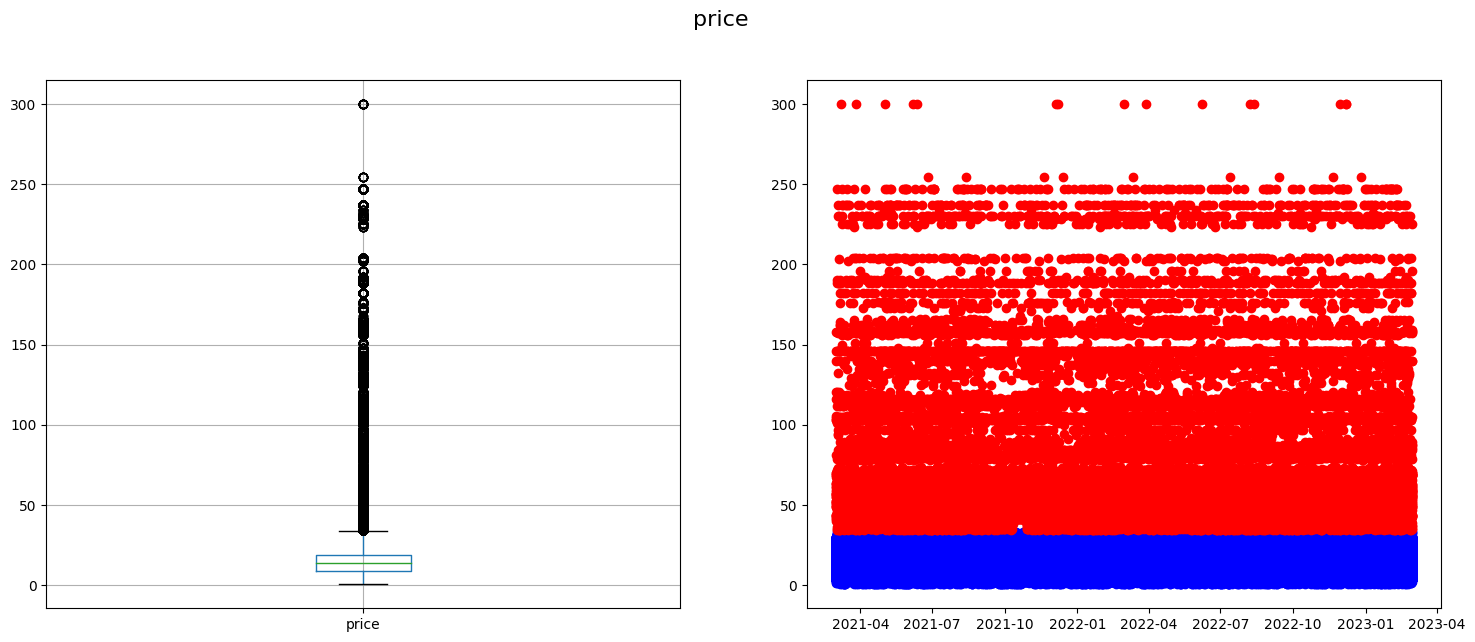

In [68]:
column_name = "price"
q_low, q_hi,iqr, q_min, q_max = get_outliers_datas(df_global_index, column_name)
graphe_outliers(df_global_index, column_name, q_min, q_max)

Je décide de garder le livre à 300 euros pour le calcul du CA ça aurait un impact

Suite à l'analyse des données, nous avons constaté que les données sont une prédiction

# 1. Une analyse des indicateurs de vente
1. Chiffre d'affaire : indicateurs et graphiques
1. Chiffre d'affaire : évolution dans le temps
1. Chiffre d'affaire : décomposition en moyenne mobile pour évaluer la tendance globale
1. Chiffre d'affaire : par référénce :
   1. Chiffre d'affaire : par sexe
   1. Chiffre d'affaire : par Catégorie - Tops et Flops
   1. Chiffre d'affaire : par catégorie
1. Profils client
1. Chiffre d'affaire par profil client - Courbe de Lorenz


In [69]:
df_global_index.describe(include="all")

client_id     sex          birth session_id id_prod          categ  \
count     679111  679111  679111.000000     679111  679111  679111.000000   
unique      8600       2            NaN     342275    3265            NaN   
top       c_1609       m            NaN   s_118668   1_369            NaN   
freq       25488  340826            NaN         14    2252            NaN   
mean         NaN     NaN    1977.811149        NaN     NaN       0.441953   
std          NaN     NaN      13.575361        NaN     NaN       0.595042   
min          NaN     NaN    1929.000000        NaN     NaN       0.000000   
25%          NaN     NaN    1970.000000        NaN     NaN       0.000000   
50%          NaN     NaN    1980.000000        NaN     NaN       0.000000   
75%          NaN     NaN    1987.000000        NaN     NaN       1.000000   
max          NaN     NaN    2004.000000        NaN     NaN       2.000000   

                price month_year    year         day  
count   679111.000000     679111  679111      679111  
unique            NaN         24       3         730  
top               NaN    2021-09    2022  2022-11-30  
freq              NaN      33314  346380        1311  
mean        17.454773        NaN     NaN         NaN  
std         18.328998        NaN     NaN         NaN  
min          0.620000        NaN     NaN         NaN  
25%          8.870000        NaN     NaN         NaN  
50%         13.990000        NaN     NaN         NaN  
75%         18.990000        NaN     NaN         NaN  
max        300.000000        NaN     NaN         NaN

## 1.1 CA - Evolution du chiffre d'affaire - indicateurs et graphiques

## 1.2 CA - Evolution du chiffre d'affaire

In [70]:
df_global_index.columns

Index(['client_id', 'sex', 'birth', 'session_id', 'id_prod', 'categ', 'price',
       'month_year', 'year', 'day'],
      dtype='object')

### 1.2.1 CA : Evolution par jours

In [71]:
# Evolution du chiffre d'affaire
df_ca = df_global_index.groupby('day')['price'].agg(["sum", "mean", "std", "min", "max"])
df_ca = df_ca.rename(columns={"sum": "ca", "mean":"Prix moyen", "std":"Ecart type prix", "min":'prix min', "max":'prix max'})
df_ca.reset_index(inplace=True)
df_ca = df_ca.set_index("day")
df_ca.head()


ca  Prix moyen  Ecart type prix  prix min  prix max
day                                                                  
2021-03-01  16565.22   17.219563        17.404549      1.68    247.22
2021-03-02  15486.45   16.492492        16.291762      1.67    189.99
2021-03-03  15198.69   16.683524        19.210489      1.99    236.99
2021-03-04  15196.07   16.828427        16.544647      2.24    202.99
2021-03-05  17471.37   18.527434        21.600945      0.62    230.04

In [72]:
maxi = df_ca["ca"].resample("M").max()
print(maxi.shape)
maxi.head()

(24,)


day
2021-03    17471.37
2021-04    17472.73
2021-05    18696.03
2021-06    18099.16
2021-07    17572.17
Freq: M, Name: ca, dtype: float64

In [73]:
mini = df_ca["ca"].resample("M").min()
print(mini.shape)
mini.head()

(24,)


day
2021-03    14324.84
2021-04    14773.48
2021-05    14235.62
2021-06    14586.31
2021-07    13792.21
Freq: M, Name: ca, dtype: float64

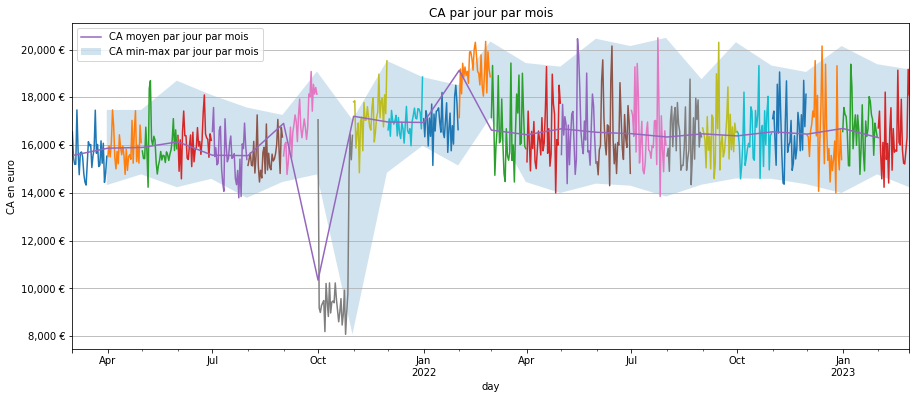

In [74]:
fig, axe = color_graph_background(1, 1)
df_ca["ca"].resample("M").plot(figsize=(15, 6), title="CA par jour par mois", label='_nolegend_')
df_ca["ca"].resample("M").mean().plot(figsize=(15, 6), label="CA moyen par jour par mois")

axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid(axis='y')
plt.fill_between(maxi.index, maxi, mini, alpha=0.2, label="CA min-max par jour par mois")
plt.legend()
plt.show()

### 1.2.2 CA : Evolution par mois

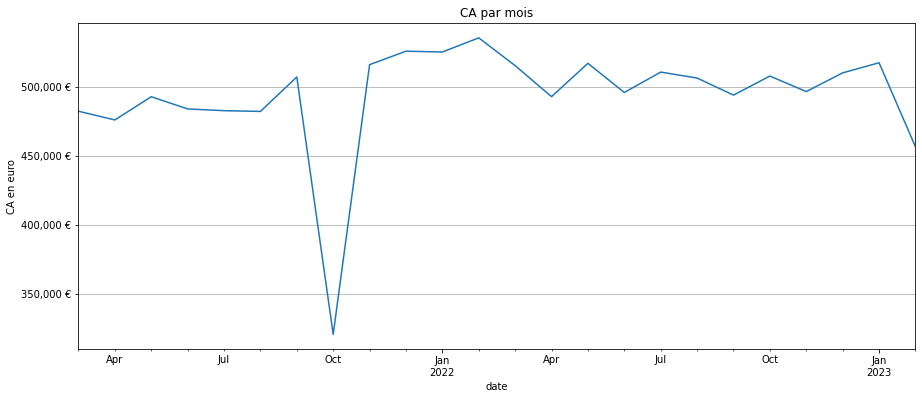

In [75]:
fig, axe = color_graph_background()
df_global_index["price"].resample("M").sum().plot(figsize=(15, 6), title="CA par mois")

axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid(axis='y')
plt.show()

In [76]:
ca_datas = df_ca.loc["2021":"2023","ca"].resample("W").agg(["mean", "std", "min", "max"])
ca_datas

mean          std       min       max
day                                                                 
2021-03-01/2021-03-07  15780.468571   938.295304  14760.20  17471.37
2021-03-08/2021-03-14  15099.034286   577.058406  14324.84  15710.51
2021-03-15/2021-03-21  16008.440000   737.267796  15060.79  17459.66
2021-03-22/2021-03-28  15634.438571   467.156889  15101.70  16176.28
2021-03-29/2021-04-04  15413.665714   598.400342  14437.04  16115.58
...                             ...          ...       ...       ...
2023-01-30/2023-02-05  16212.304286   900.792211  14586.31  17423.19
2023-02-06/2023-02-12  16075.450000  1512.304685  14235.62  18217.02
2023-02-13/2023-02-19  16303.087143  1352.612575  14948.64  19135.47
2023-02-20/2023-02-26  16035.021429   919.076094  15207.89  17920.25
2023-02-27/2023-03-05  18637.980000   753.535412  18105.15  19170.81

[105 rows x 4 columns]

### 1.2.3 CA : Zoom 2021

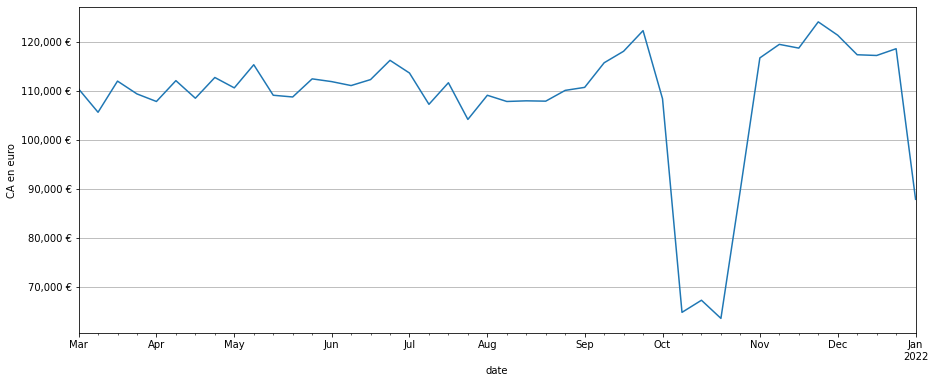

In [77]:
fig, axe = color_graph_background()
df_global_index.loc["2021"]["price"].resample("W").sum().plot(figsize=(15, 6), )
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid(axis='y')
plt.show()

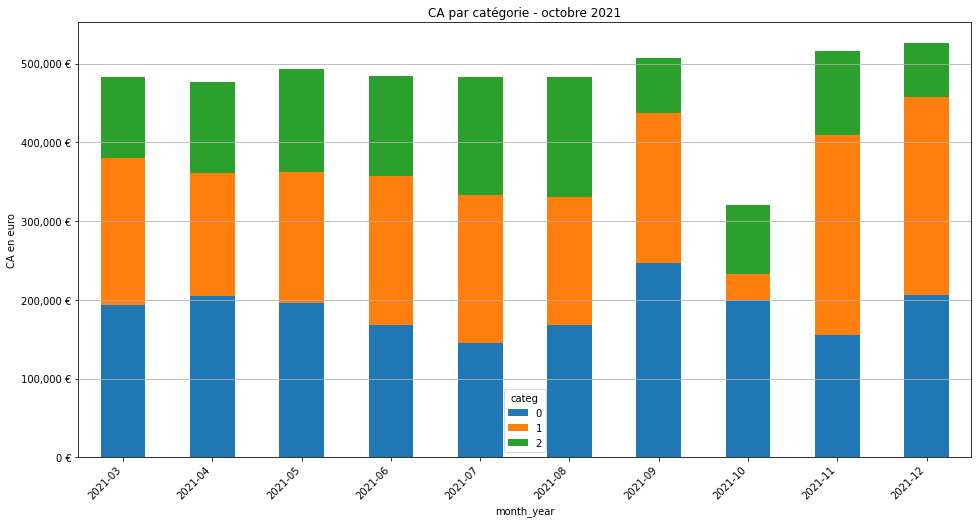

In [78]:
test5 = df_global_index.loc["2021"].groupby(['month_year', 'categ'])['price'].sum().unstack('categ').fillna(0)
figure, axe = color_graph_background()
test5.plot(kind='bar', stacked=True, title="CA par catégorie - octobre 2021", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid(axis='y')
figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

### 1.2.4 CA : Zoom octobre 2021

C:\Program Files\Python39\lib\site-packages\pandas\core\indexing.py:862: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return getattr(section, self.name)[new_key]


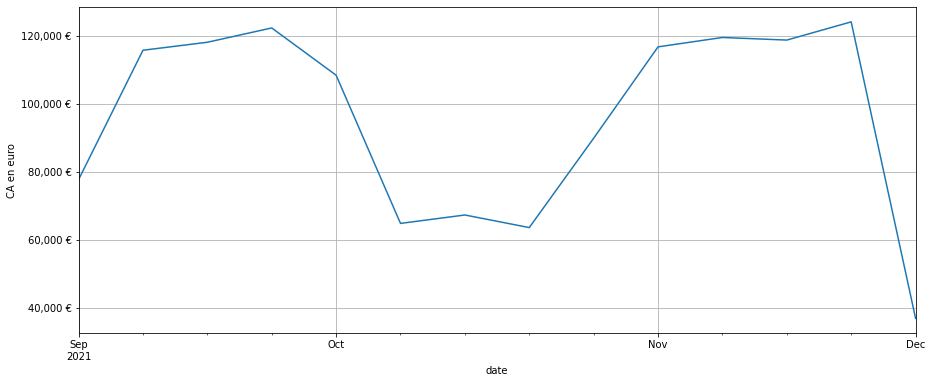

In [79]:
fig, axe = color_graph_background()
df_global_index.loc["2021-09":"2021-11","price"].resample("W").sum().plot(figsize=(15, 6), )
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid()
plt.show()

In [80]:
oct = df_global_index.loc["2021-10"]
oct.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2021-10-28 07:35:26.214204     c_103   f   1986   s_111235  0_2192      0   
2021-10-23 12:41:03.390366     c_103   f   1986   s_108948   0_434      0   
2021-10-28 07:16:09.667580     c_103   f   1986   s_111235  0_1020      0   
2021-10-06 18:34:39.902464     c_103   f   1986   s_100965  0_1453      0   
2021-10-19 22:45:29.086913     c_103   f   1986   s_107276  0_1403      0   

                            price month_year  year         day  
date                                                            
2021-10-28 07:35:26.214204  16.87    2021-10  2021  2021-10-28  
2021-10-23 12:41:03.390366  16.97    2021-10  2021  2021-10-23  
2021-10-28 07:16:09.667580   9.71    2021-10  2021  2021-10-28  
2021-10-06 18:34:39.902464   7.99    2021-10  2021  2021-10-06  
2021-10-19 22:45:29.086913  15.99    2021-10  2021  2021-10-19

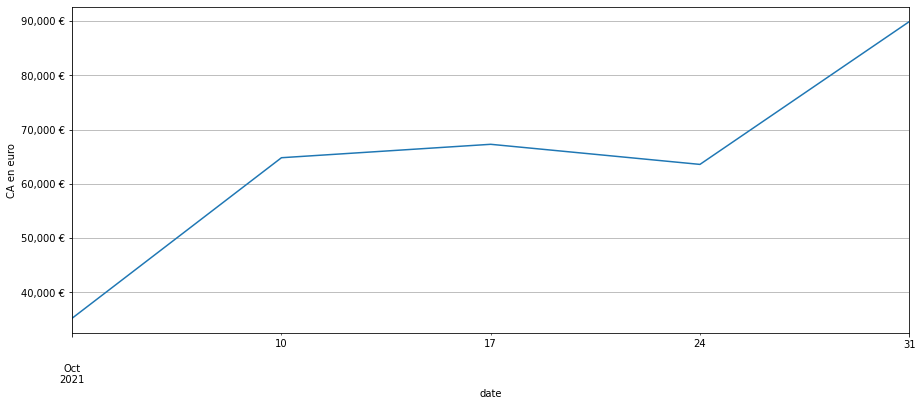

In [81]:
fig, axe = color_graph_background()
oct["price"].resample("W").sum().plot(figsize=(15, 6), )
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.grid()
axe.set_ylabel("CA en euro")
plt.show()

In [82]:
oct["categ"].value_counts()

0    18762
1     1666
2     1171
Name: categ, dtype: int64

In [83]:
df_octobre = oct.groupby(['categ'])['price'].agg(['sum','mean','count'])
df_octobre = df_octobre.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres vendus"})
df_octobre

ca  prix moyen  nb livres vendus
categ                                         
0      199250.83   10.619914             18762
1       33762.32   20.265498              1666
2       87785.59   74.966345              1171

In [84]:
df_categ_info = df_global_index.copy()
df_categ_info = df_categ_info.groupby(['categ'])['price'].agg(['sum','mean','count'])
df_categ_info = df_categ_info.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres vendus"})
df_categ_info

ca  prix moyen  nb livres vendus
categ                                          
0      4419730.97   10.638188            415459
1      4653722.69   20.485730            227169
2      2780275.02   76.207412             36483

In [85]:
nb_livre_categ_by_day = oct.groupby(['day', 'categ'])['price'].count().unstack('categ').fillna(0)
ca_categ_by_day = oct.groupby(['day', 'categ'])['price'].sum().unstack('categ').fillna(0)
ca_categ_by_day.head()

categ             0        1        2
day                                  
2021-10-01  6950.50  7003.79  3104.05
2021-10-02  7141.01     0.00  2041.12
2021-10-03  6786.57     0.00  2206.48
2021-10-04  6533.60     0.00  2746.08
2021-10-05  6357.91     0.00  3032.55

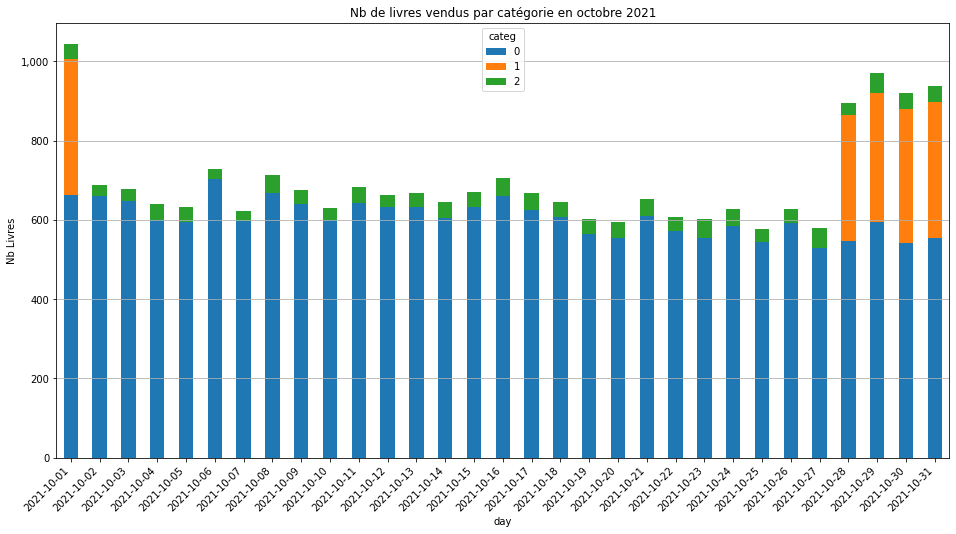

In [86]:
figure, axe = color_graph_background()
nb_livre_categ_by_day.plot(kind='bar', stacked=True, title="Nb de livres vendus par catégorie en octobre 2021", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nb Livres")
axe.grid(axis='y')
figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

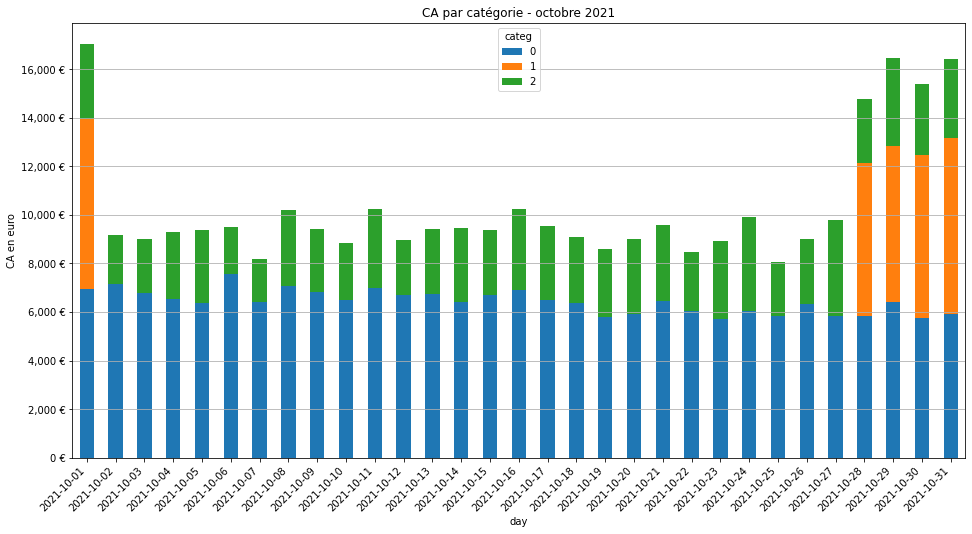

In [87]:
figure, axe = color_graph_background()
ca_categ_by_day.plot(kind='bar', stacked=True, title="CA par catégorie - octobre 2021", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euro")
axe.grid(axis='y')
figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [88]:
data4=oct.reset_index()
data4.dtypes

date          datetime64[ns]
client_id             object
sex                 category
birth                  int64
session_id            object
id_prod               object
categ                  int32
price                float64
month_year         period[M]
year           period[A-DEC]
day                period[D]
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

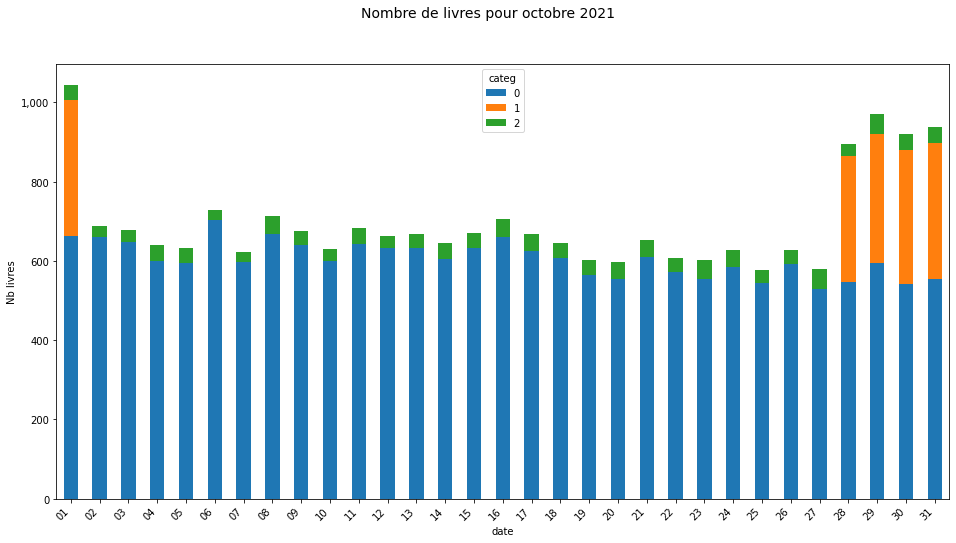

In [89]:
plot_df = data4.groupby([pd.Grouper(key='date', freq='d'), 'categ']).size().unstack(fill_value=0)
figure, axe = color_graph_background()
plot_df.plot(kind='bar', stacked=True, ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nb livres")
axe.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
figure.suptitle('Nombre de livres pour octobre 2021', fontsize=14)

plt.show

In [90]:
data4=oct.reset_index()
data4.columns

Index(['date', 'client_id', 'sex', 'birth', 'session_id', 'id_prod', 'categ',
       'price', 'month_year', 'year', 'day'],
      dtype='object')

In [91]:
data4['categ'].unique()

array([0, 1, 2])

In [92]:
data4 = data4[['date', 'categ', 'price']]

<function matplotlib.pyplot.show(close=None, block=None)>

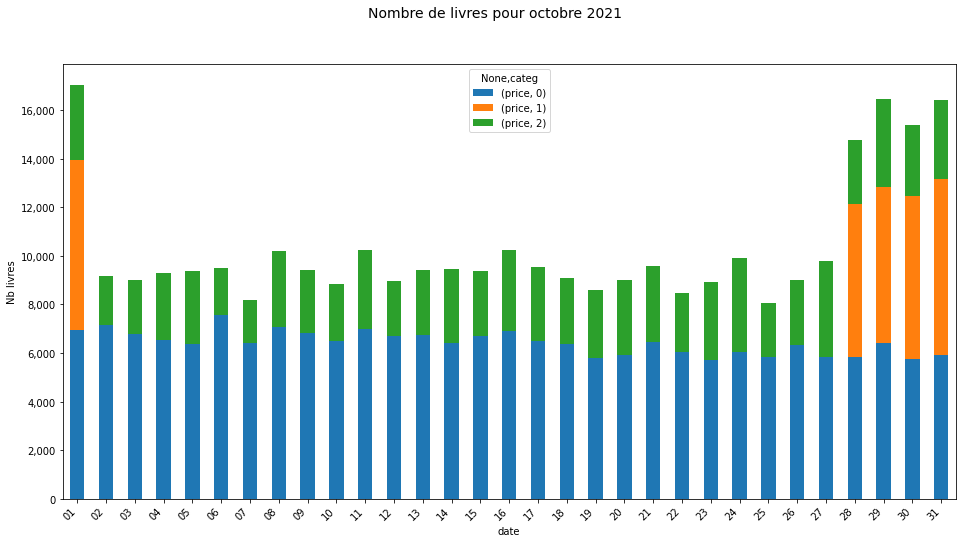

In [93]:
plot_df = data4.groupby([pd.Grouper(key='date', freq='d'), 'categ']).sum().unstack(fill_value=0)
figure, axe = color_graph_background()
plot_df.plot(kind='bar', stacked=True, ax=axe)
plt.xticks(rotation=45, ha="right")
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nb livres")
axe.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

figure.set_size_inches(16, 8, forward=True)
figure.suptitle('Nombre de livres pour octobre 2021', fontsize=14)
plt.show

Vu les données manquantes en octobre, on vérifie si les données étaient présentes dans le fichier chargé et qu'il s'agit des traitements de nettoyage ou si les données sont manquantes dès le départ

In [94]:
print(df_transactions_clean.shape)
df_transactions_clean.dtypes

(679332, 4)


id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [95]:
df_transactions_control = df_transactions_clean.copy()

In [96]:
df_transactions_control["date"] = pd.to_datetime(df_transactions_control["date"])
df_transactions_control['day'] = pd.to_datetime(df_transactions_control["date"]).dt.to_period('D')
df_transactions_control.head()

id_prod                       date session_id client_id         day
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103  2022-05-20
1   1_251 2022-02-02 07:55:19.149409   s_158752    c_8534  2022-02-02
2  0_1277 2022-06-18 15:44:33.155329   s_225667    c_6714  2022-06-18
3   2_209 2021-06-24 04:19:29.835891    s_52962    c_6941  2021-06-24
4  0_1509 2023-01-11 08:22:08.194479   s_325227    c_4232  2023-01-11

In [97]:
df_transactions_control = df_transactions_control.set_index("date")
df_transactions_control.head()

id_prod session_id client_id         day
date                                                               
2022-05-20 13:21:29.043970  0_1518   s_211425     c_103  2022-05-20
2022-02-02 07:55:19.149409   1_251   s_158752    c_8534  2022-02-02
2022-06-18 15:44:33.155329  0_1277   s_225667    c_6714  2022-06-18
2021-06-24 04:19:29.835891   2_209    s_52962    c_6941  2021-06-24
2023-01-11 08:22:08.194479  0_1509   s_325227    c_4232  2023-01-11

In [98]:
print(df_transactions_control.loc["2021-10"].shape)
df_transactions_control.loc["2021-10"]

(21606, 4)


id_prod session_id client_id         day
date                                                               
2021-10-02 17:39:26.919537  0_1409    s_99013    c_5725  2021-10-02
2021-10-03 16:05:12.544172  0_1247    s_99443    c_3394  2021-10-03
2021-10-13 14:35:01.163737  0_1272   s_104207    c_8534  2021-10-13
2021-10-24 13:25:39.888945  0_1102   s_109442    c_1609  2021-10-24
2021-10-05 21:57:27.673800  0_1079   s_100557    c_7918  2021-10-05
...                            ...        ...       ...         ...
2021-10-22 01:12:51.848429  0_1418   s_108264    c_7213  2021-10-22
2021-10-26 04:40:29.252116  0_1391   s_110243    c_7878  2021-10-26
2021-10-15 16:58:58.818380  0_1609   s_105230    c_6714  2021-10-15
2021-10-01 23:19:52.888190  0_1635    s_98649    c_1061  2021-10-01
2021-10-08 07:55:52.347300  0_1572   s_101701     c_725  2021-10-08

[21606 rows x 4 columns]

In [99]:
df_transactions_control_group = df_transactions_control.groupby(['day', 'id_prod']).agg(['count'])
df_transactions_control_group = df_transactions_control_group.rename(columns={"count": "nb_livres"})
df_transactions_control_group.reset_index(inplace=True)
print(df_transactions_control_group.shape)
df_transactions_control_group.head(10)

(449015, 4)


day id_prod session_id client_id
                       nb_livres nb_livres
0  2021-03-01     0_0          1         1
1  2021-03-01     0_1          1         1
2  2021-03-01  0_1000          1         1
3  2021-03-01  0_1003          1         1
4  2021-03-01  0_1007          1         1
5  2021-03-01  0_1008          1         1
6  2021-03-01  0_1009          2         2
7  2021-03-01  0_1013          1         1
8  2021-03-01  0_1015          1         1
9  2021-03-01  0_1017          1         1

In [100]:
octo =  df_transactions_control_group.loc[(df_transactions_control_group["day"] > "2021-09") & (df_transactions_control_group["day"] < "2021-11")]
print(octo.shape)
octo.head()

(35292, 4)


day id_prod session_id client_id
                            nb_livres nb_livres
111396  2021-09-02     0_0          1         1
111397  2021-09-02  0_1000          1         1
111398  2021-09-02  0_1001          1         1
111399  2021-09-02  0_1003          1         1
111400  2021-09-02  0_1009          1         1

Les données manquaient dans le fichier d'origine.    

Il manque les données pour la catégorie 1 du 02/10 au 27/10/2021.    
Pour homogénéiser les données, il faut :
* soit supprimer le mois d'octobre de toutes les années et travailler sur 11 mois
* soit appliquer la moyenne pour les données manquantes de 2021

In [101]:
oct_22 = df_global_index.loc["2022-10"]
oct_22.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-10-19 07:32:23.140487     c_103   f   1986   s_284714  0_1636      0   
2022-10-26 16:34:41.740599     c_103   f   1986   s_288362  0_1429      0   
2022-10-26 16:14:13.732205     c_103   f   1986   s_288362  0_1219      0   
2022-10-26 16:16:27.156530     c_103   f   1986   s_288362  0_1481      0   
2022-10-31 21:49:19.635328     c_103   f   1986   s_290822  0_1512      0   

                            price month_year  year         day  
date                                                            
2022-10-19 07:32:23.140487   9.45    2022-10  2022  2022-10-19  
2022-10-26 16:34:41.740599   7.99    2022-10  2022  2022-10-26  
2022-10-26 16:14:13.732205   3.99    2022-10  2022  2022-10-26  
2022-10-26 16:16:27.156530   3.99    2022-10  2022  2022-10-26  
2022-10-31 21:49:19.635328   5.29    2022-10  2022  2022-10-31

In [102]:
df_global_index.index.min()

Timestamp('2021-03-01 00:01:07.843138')

In [103]:
df_global_index.index.max()

Timestamp('2023-02-28 23:58:30.792755')

Il n'y a que 2022 avec un mois d'octobre, de fait je supprime le mois d'octobre pour 2021 et 2022

In [104]:
df_global_index_less_10 = df_global_index[df_global_index["month_year"] != "2022-10"]
print("Before : ", df_global_index.shape,"> After :", df_global_index_less_10.shape)

Before :  (679111, 10) > After : (650147, 10)


In [105]:
df_global_index_less_10 = df_global_index_less_10[df_global_index_less_10["month_year"] != "2021-10"]
print("Before : ", df_global_index.shape,"> After :", df_global_index_less_10.shape)

Before :  (679111, 10) > After : (628548, 10)


In [106]:
ca_less_10 = df_global_index_less_10.groupby('day')['price'].agg(["sum", "mean", "std", "min", "max"])
ca_less_10 = ca_less_10.rename(columns={"sum": "ca", "mean":"Prix moyen", "std":"Ecart type prix", "min":'prix min', "max":'prix max'})
ca_less_10.reset_index(inplace=True)
ca_less_10 = ca_less_10.set_index("day")
print(ca_less_10.shape)
ca_less_10.head()

(668, 5)


ca  Prix moyen  Ecart type prix  prix min  prix max
day                                                                  
2021-03-01  16565.22   17.219563        17.404549      1.68    247.22
2021-03-02  15486.45   16.492492        16.291762      1.67    189.99
2021-03-03  15198.69   16.683524        19.210489      1.99    236.99
2021-03-04  15196.07   16.828427        16.544647      2.24    202.99
2021-03-05  17471.37   18.527434        21.600945      0.62    230.04

In [107]:
mini_less_10 = ca_less_10["ca"].resample("Y").min()
maxi_less_10 = ca_less_10["ca"].resample("Y").max()
print("Mini:",mini.shape, "Maxi:", maxi.shape)

Mini: (24,) Maxi: (24,)


Le fait d'avoir supprimé le mois d'octobre, pose problème pour la représentation mensuelle.

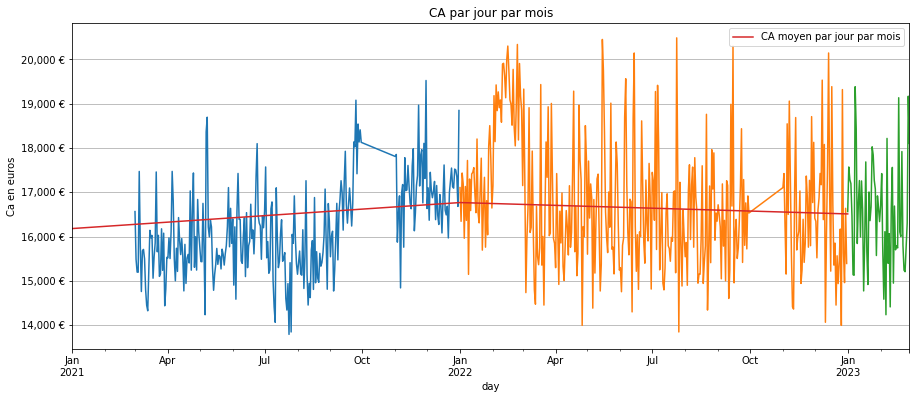

In [108]:
fig, axe = color_graph_background(1, 1)
ca_less_10["ca"].resample("Y").plot(figsize=(15, 6), title="CA par jour par mois", label='_nolegend_')
ca_less_10["ca"].resample("Y").mean().plot(figsize=(15, 6), label="CA moyen par jour par mois")
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("Ca en euros")
axe.grid(axis='y')
plt.legend()
plt.show()

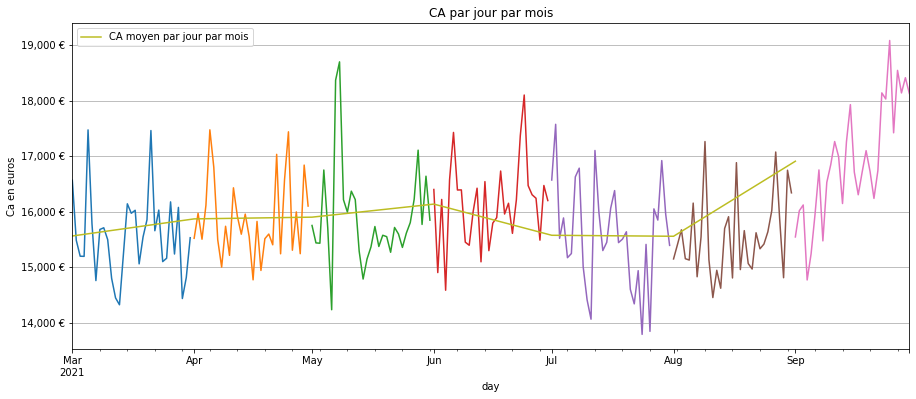

In [109]:
fig, axe = color_graph_background(1, 1)
try:
    ca_less_10["ca"].resample("M").plot(figsize=(15, 6), title="CA par jour par mois", label='_nolegend_')
except:
    pass
try:
    ca_less_10["ca"].resample("M").mean().plot(figsize=(15, 6), label="CA moyen par jour par mois")
except:
    pass
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("Ca en euros")
axe.grid(axis='y')
plt.legend()
plt.show()

In [110]:
ca_less_10.head()

ca  Prix moyen  Ecart type prix  prix min  prix max
day                                                                  
2021-03-01  16565.22   17.219563        17.404549      1.68    247.22
2021-03-02  15486.45   16.492492        16.291762      1.67    189.99
2021-03-03  15198.69   16.683524        19.210489      1.99    236.99
2021-03-04  15196.07   16.828427        16.544647      2.24    202.99
2021-03-05  17471.37   18.527434        21.600945      0.62    230.04

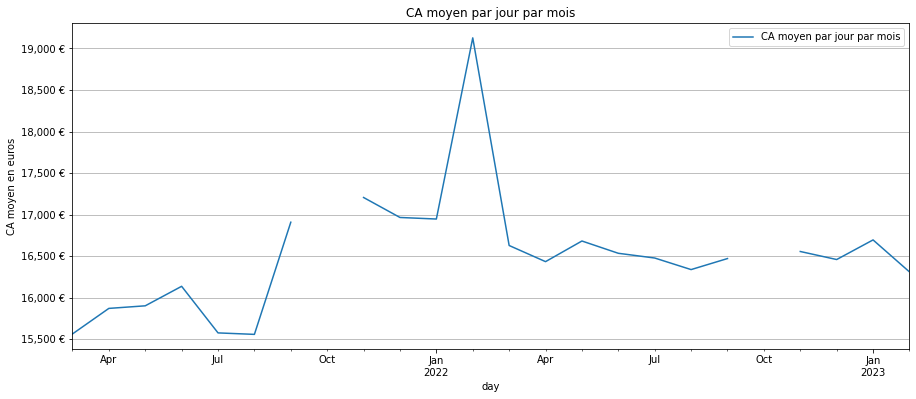

In [111]:
fig, axe = color_graph_background(1, 1)
try:
    ca_less_10["ca"].resample("M").mean().plot(figsize=(15, 6), title="CA moyen par jour par mois", label="CA moyen par jour par mois")
except:
    pass
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA moyen en euros")
axe.grid(axis='y')
plt.legend()
plt.show()

### 1.2.5 CA : Moyenne par mois

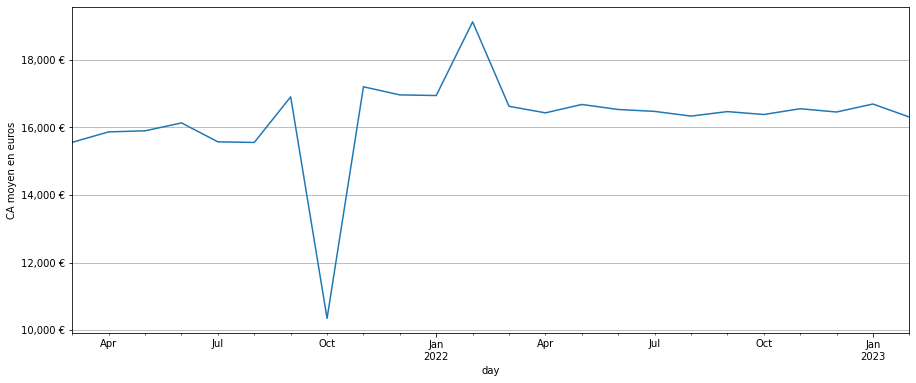

In [112]:
fig, axe = color_graph_background()
df_ca["ca"].resample("M").mean().plot(figsize=(15, 6))
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA moyen en euros")
axe.grid(axis='y')
plt.show()

### 1.2.6 CA : Ecart type

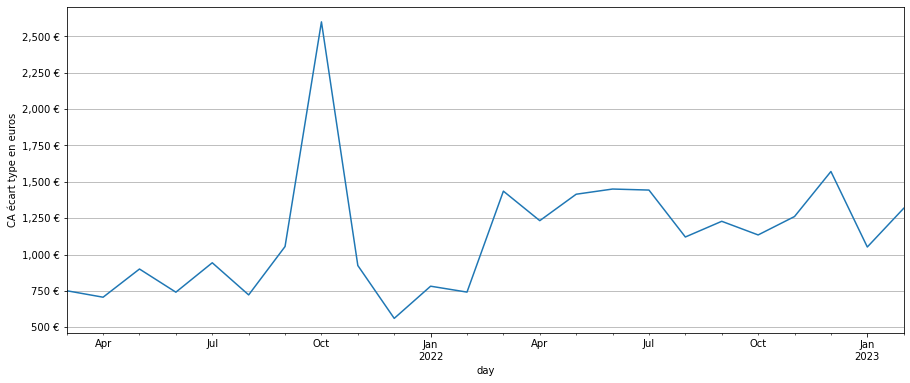

In [113]:
fig, axe = color_graph_background()
df_ca["ca"].resample("M").std().plot(figsize=(15, 6))
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA écart type en euros")
axe.grid(axis='y')
plt.show()

### 1.2.7 CA : Moyenne par mois et par semaine

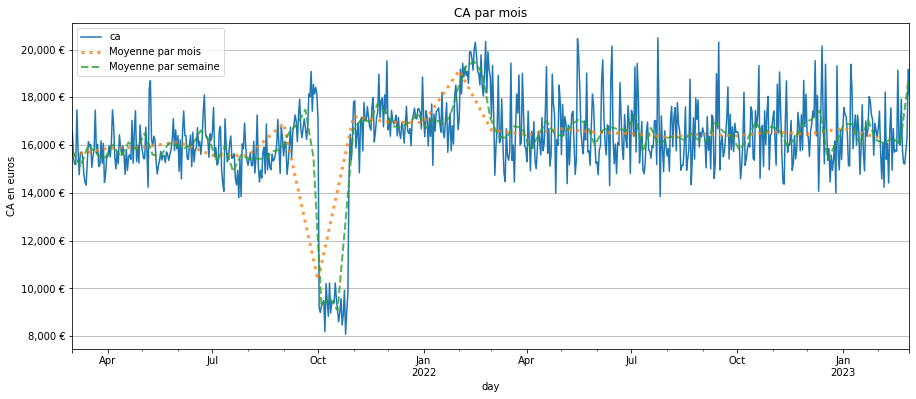

In [114]:
fig, axe = color_graph_background()
fig.set_size_inches(15, 6, forward=True)
df_ca["ca"].plot(title="CA par mois")
df_ca["ca"].resample("M").mean().plot(label="Moyenne par mois", lw=3, ls=":", alpha=0.8)
df_ca["ca"].resample("W").mean().plot(label="Moyenne par semaine", lw=2, ls="--", alpha=0.8)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.grid(axis='y')
axe.set_ylabel("CA en euros")
plt.legend()
plt.show()

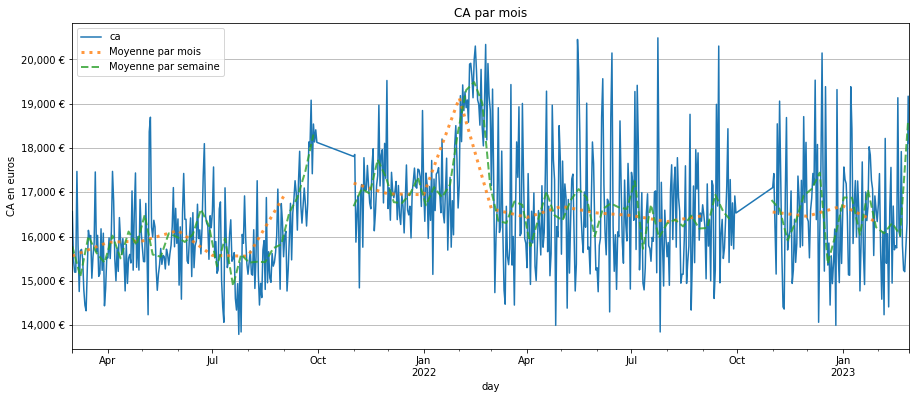

In [115]:
fig, axe = color_graph_background()
fig.set_size_inches(15, 6, forward=True)
ca_less_10["ca"].plot(title="CA par mois")
ca_less_10["ca"].resample("M").mean().plot(label="Moyenne par mois", lw=3, ls=":", alpha=0.8)
ca_less_10["ca"].resample("W").mean().plot(label="Moyenne par semaine", lw=2, ls="--", alpha=0.8)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euros")
axe.grid(axis='y')
plt.legend()
plt.show()

### 1.2.8 CA : comparaison des mois par années

In [116]:
df_ca.head()

ca  Prix moyen  Ecart type prix  prix min  prix max
day                                                                  
2021-03-01  16565.22   17.219563        17.404549      1.68    247.22
2021-03-02  15486.45   16.492492        16.291762      1.67    189.99
2021-03-03  15198.69   16.683524        19.210489      1.99    236.99
2021-03-04  15196.07   16.828427        16.544647      2.24    202.99
2021-03-05  17471.37   18.527434        21.600945      0.62    230.04

In [117]:
d1 = get_year_ca_by_month(df_ca, year="2021")
d1.head()

2021
month           
03     482440.61
04     476109.30
05     492943.47
06     484088.56
07     482835.40

In [118]:
d2 = get_year_ca_by_month(df_ca, year="2022")
d2.head()

2022
month           
01     525338.99
02     535571.50
03     515456.53
04     492998.94
05     517132.60

In [119]:
d3 = get_year_ca_by_month(df_ca, year="2023")
d3.head()

2023
month           
01     517540.55
02     456679.76

In [120]:
result = pd.concat([d1, d2, d3], axis=1)
result = result.sort_index()
result

2021       2022       2023
month                                 
01           NaN  525338.99  517540.55
02           NaN  535571.50  456679.76
03     482440.61  515456.53        NaN
04     476109.30  492998.94        NaN
05     492943.47  517132.60        NaN
06     484088.56  496016.12        NaN
07     482835.40  510783.12        NaN
08     482284.79  506467.27        NaN
09     507240.68  494114.53        NaN
10     320798.74  507917.77        NaN
11     516167.73  496664.94        NaN
12     525917.28  510219.50        NaN

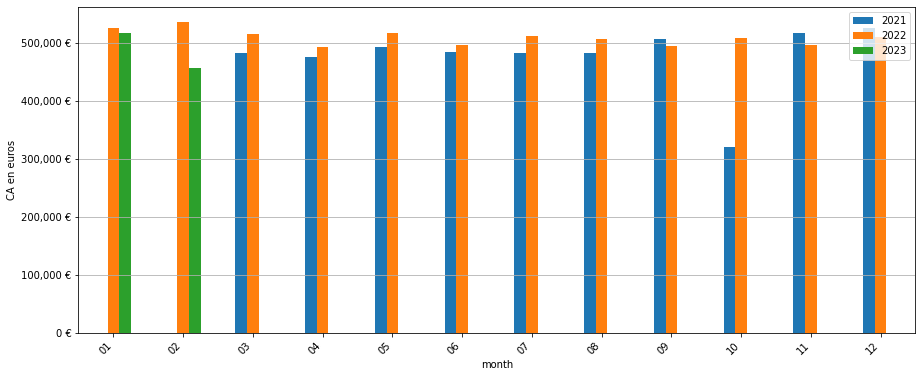

In [121]:
fig, ax = color_graph_background()
fig.set_size_inches(15, 6, forward=True)
result.plot(kind="bar", ax=ax)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
ax.grid(axis='y')
ax.set_ylabel("CA en euros")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

In [122]:
result["evolution-22/21"] = ((result["2022"]*100)/result["2021"])-100
result["evolution-23/22"] = ((result["2023"]*100)/result["2022"])-100
result

2021       2022       2023  evolution-22/21  evolution-23/22
month                                                                   
01           NaN  525338.99  517540.55              NaN        -1.484459
02           NaN  535571.50  456679.76              NaN       -14.730384
03     482440.61  515456.53        NaN         6.843520              NaN
04     476109.30  492998.94        NaN         3.547429              NaN
05     492943.47  517132.60        NaN         4.907080              NaN
06     484088.56  496016.12        NaN         2.463921              NaN
07     482835.40  510783.12        NaN         5.788250              NaN
08     482284.79  506467.27        NaN         5.014149              NaN
09     507240.68  494114.53        NaN        -2.587756              NaN
10     320798.74  507917.77        NaN        58.329104              NaN
11     516167.73  496664.94        NaN        -3.778382              NaN
12     525917.28  510219.50        NaN        -2.984838              NaN

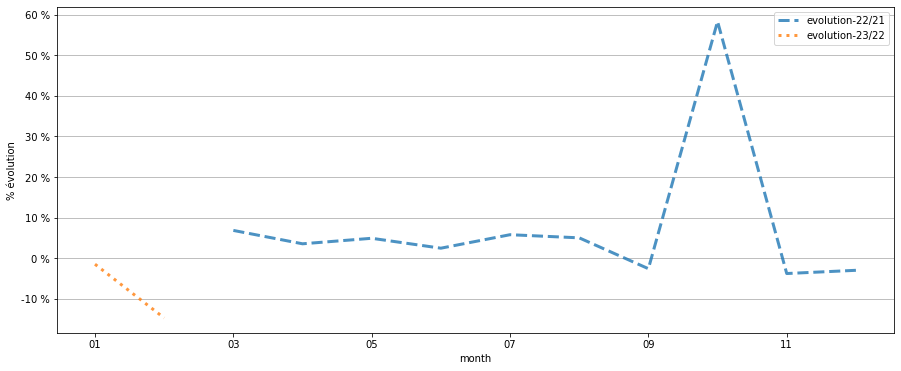

In [123]:
fig, axe = color_graph_background()
fig.set_size_inches(15, 6, forward=True)
result["evolution-22/21"].plot(label="evolution-22/21", lw=3, ls="--", alpha=0.8)
result["evolution-23/22"].plot(label="evolution-23/22", lw=3, ls=":", alpha=0.8)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} %". format(x)))
axe.grid(axis='y')
axe.set_ylabel("% évolution")
plt.legend()
plt.show()

## 1.3 CA : décomposition en moyenne mobile pour évaluer la tendance globale

### 1.3.1 CA : Moyenne mobile 2021

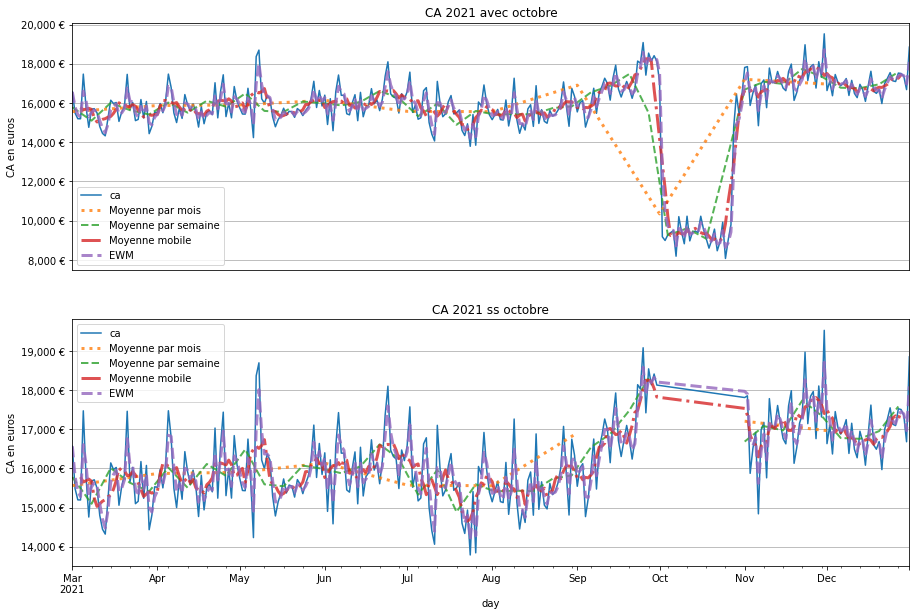

In [124]:
fig, axes = color_graph_background(2,1)
fig.set_size_inches(15, 10, forward=True)

draw_1(df_ca, axes[0],"CA 2021 avec octobre")
axes[0].xaxis.set_visible(False)

draw_1(ca_less_10, axes[1],"CA 2021 ss octobre")

plt.show()

### 1.3.2 CA : EWM 2021

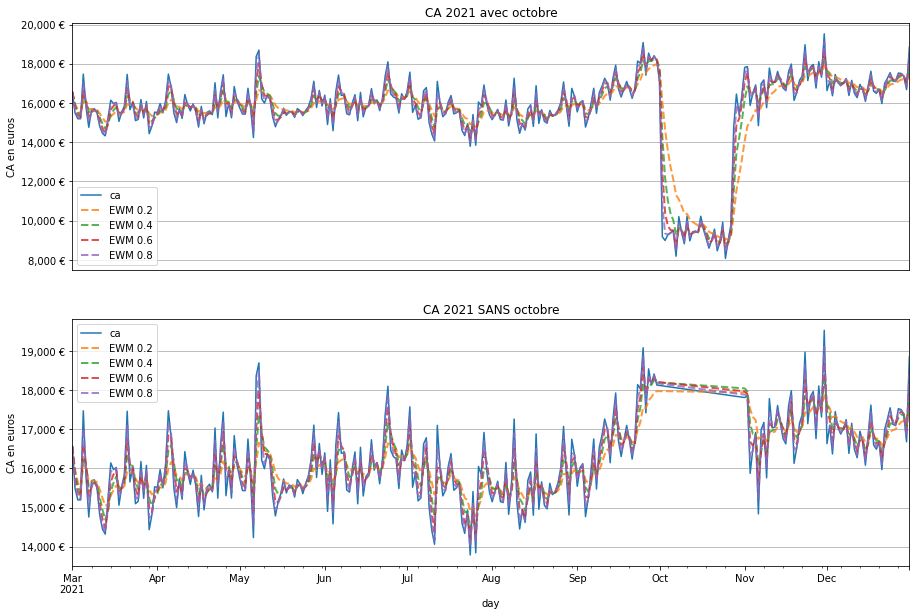

In [125]:
fig, axes = color_graph_background(2,1)
fig.set_size_inches(15, 10, forward=True)

draw_2(df_ca, axes[0], "CA 2021 avec octobre")
axes[0].xaxis.set_visible(False)

draw_2(ca_less_10, axes[1], "CA 2021 SANS octobre")

plt.show()

### 1.3.2 CA : moyen par semaine sur 2021

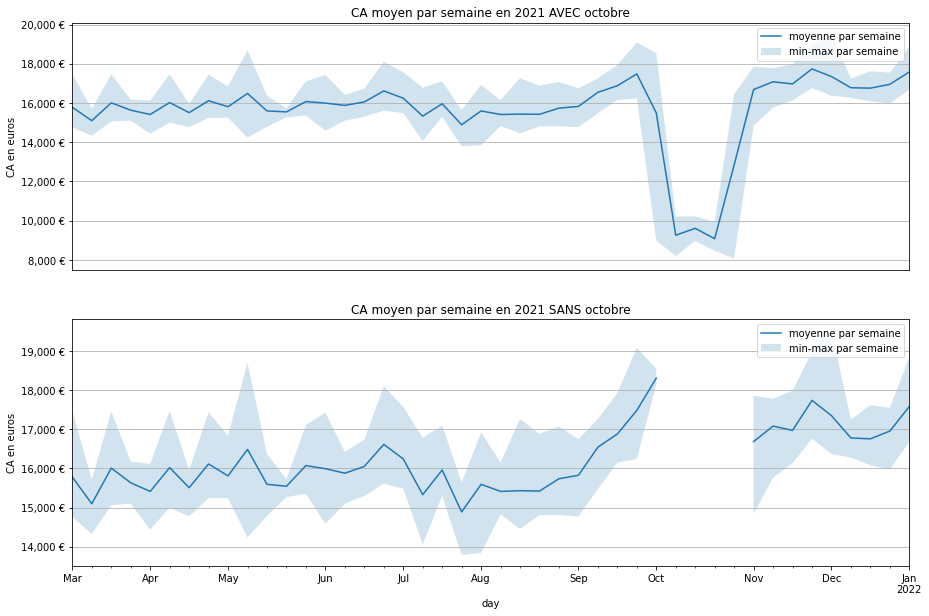

In [126]:
fig, axes = color_graph_background(2,1)
fig.set_size_inches(15, 10, forward=True)

draw_3(df_ca, axes[0], "CA moyen par semaine en 2021 AVEC octobre")
axes[0].xaxis.set_visible(False)
draw_3(ca_less_10, axes[1], "CA moyen par semaine en 2021 SANS octobre")

plt.show()

## 1.4. CA : par référénce :
   1. Chiffre d'affaire : par sexe
   1. Chiffre d'affaire : par Catégorie - Tops et Flops
   1. Chiffre d'affaire : par catégorie

### 1.4.0. Lien entre 2 variables : représentation de pearson

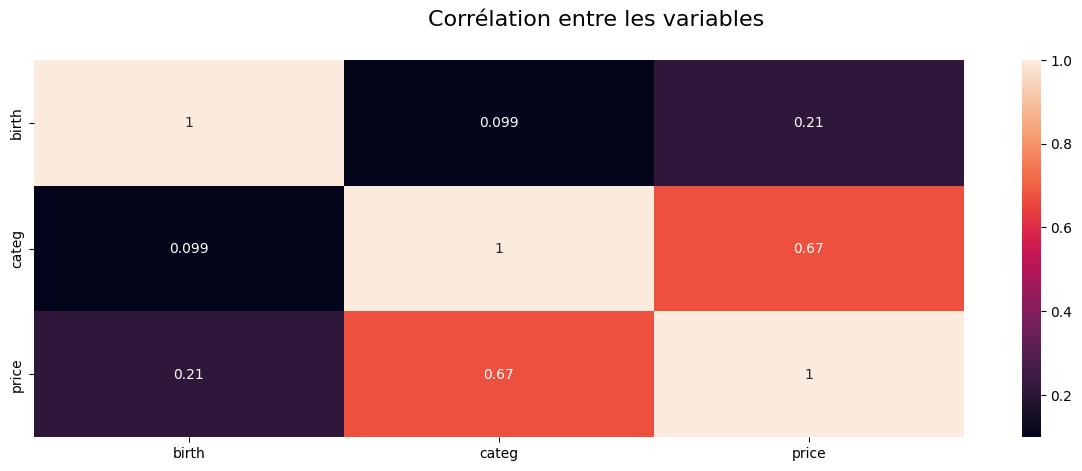

In [127]:
draw_correlation_graphe(df_global_index, "Corrélation entre les variables", verbose)

Il y a un lien entre les catégories et les prix

### 1.4.1. Catégories / prix

In [128]:
corr, _ = pearsonr(df_global_index['price'], df_global_index['categ']) 
print('Pearsons correlation: %.3f' % corr) 

Pearsons correlation: 0.672


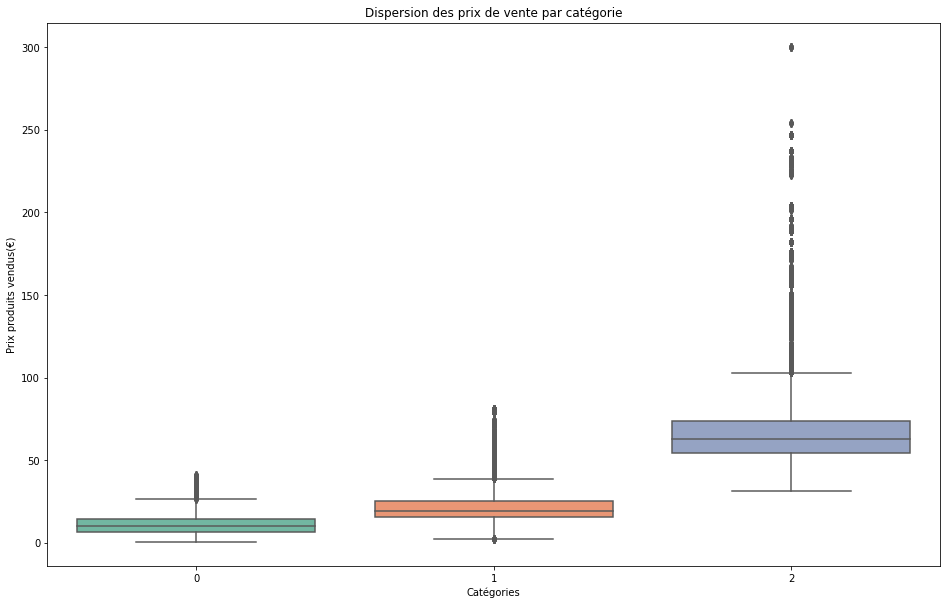

In [129]:
#Comparaison de distribution des prix produits par catégorie avec un boxplot
figure, axe = color_graph_background(1,1)
sns.boxplot(x = 'categ', y = 'price', data = df_global_index, palette="Set2", ax=axe)
plt.title('Dispersion des prix de vente par catégorie')
plt.xlabel('Catégories')
plt.ylabel('Prix produits vendus(€)')
figure.set_size_inches(16, 10, forward=True)
plt.show()

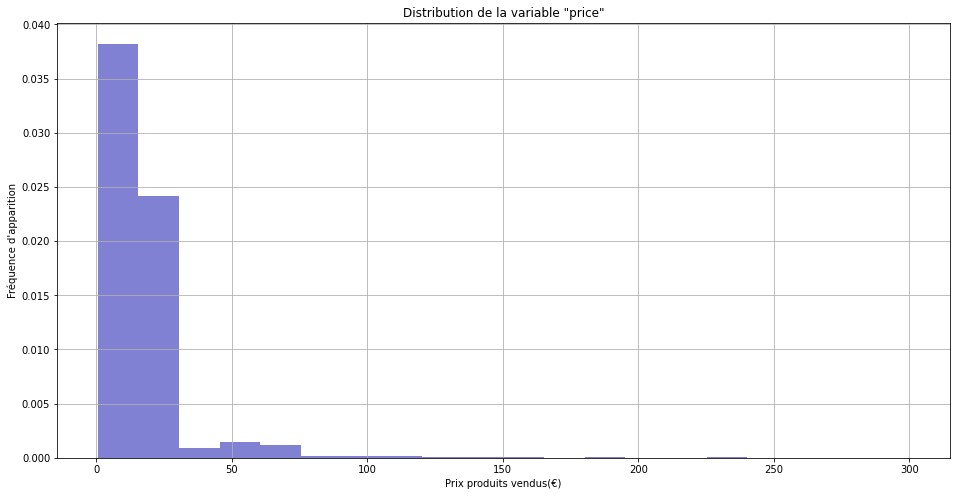

In [130]:
#Visualisation (Histogramme)de la distribution des prix produits
figure, axe = color_graph_background(1,1)

df_global_index['price'].hist(color='#0504aa', alpha=0.5, density=True, bins=20, ax=axe)

plt.title('Distribution de la variable "price"')
plt.xlabel('Prix produits vendus(€)')
plt.ylabel('Fréquence d\'apparition')
figure.set_size_inches(16, 8, forward=True)
plt.show()

Il y a trop de prix différents pour avoir une représentation.
L'ajout d'une catégorie de prix devrait permettre d'avoir une meilleure vision.

In [131]:
price=df_global_index['price']

bins = pd.IntervalIndex.from_tuples([(-1, 9), (9, 24), (24, 49), (49, 74), (74, 99), (99, 149), (149, 199), (199, 249), (249, 299), (299, 400)])
d_price = pd.cut(price, bins).value_counts().sort_index()
d_price

(-1, 9]       186375
(9, 24]       389261
(24, 49]       70192
(49, 74]       23961
(74, 99]        2374
(99, 149]       4274
(149, 199]      1817
(199, 249]       833
(249, 299]         9
(299, 400]        15
Name: price, dtype: int64

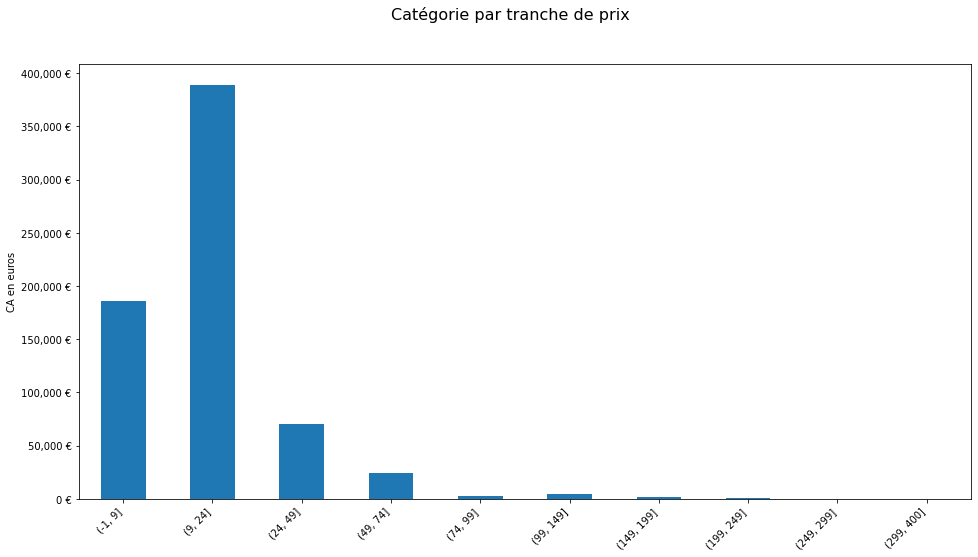

In [132]:
figure, axe = color_graph_background(1,1)

# Affichage du nombre CA par catégorie
d_price.plot(kind='bar', stacked=True)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
axe.set_ylabel("CA en euros")

figure.set_size_inches(16, 8, forward=True)
figure.suptitle("Catégorie par tranche de prix", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()

Autre façon de faire

In [133]:
df_global_index['tranche_prix'] = df_global_index['price'].map(category_prix)
df_global_index.tail()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2021-07-23 07:01:38.963669    c_4391   f   2001    s_65994   2_147      2   
2022-03-25 18:07:25.880052    c_1232   f   1960   s_184472   0_142      0   
2021-09-25 18:07:25.880052    c_1232   f   1960    s_95415   0_142      0   
2021-03-11 00:11:32.016264    c_7534   m   1992     s_4605   2_205      2   
2022-07-11 00:11:32.016264    c_7534   m   1992   s_236636   2_205      2   

                             price month_year  year         day  \
date                                                              
2021-07-23 07:01:38.963669  181.99    2021-07  2021  2021-07-23   
2022-03-25 18:07:25.880052   19.85    2022-03  2022  2022-03-25   
2021-09-25 18:07:25.880052   19.85    2021-09  2021  2021-09-25   
2021-03-11 00:11:32.016264  100.99    2021-03  2021  2021-03-11   
2022-07-11 00:11:32.016264  100.99    2022-07  2022  2022-07-11   

                              tranche_prix  
date                                        
2021-07-23 07:01:38.963669  de 150 à 200 €  
2022-03-25 18:07:25.880052    de 10 à 25 €  
2021-09-25 18:07:25.880052    de 10 à 25 €  
2021-03-11 00:11:32.016264  de 100 à 150 €  
2022-07-11 00:11:32.016264  de 100 à 150 €

In [134]:
sorter_prix = create_sorter_prix()
sorter_prix

['< 10 €',
 'de 10 à 25 €',
 'de 25 à 50 €',
 'de 50 à 75 €',
 'de 75 à 100 €',
 'de 100 à 150 €',
 'de 150 à 200 €',
 'de 200 à 250 €',
 'de 250 à 300 €',
 '>= 300 €']

In [135]:
df_global_index_sort_tranche_prix = df_global_index.copy()
df_global_index_sort_tranche_prix['tranche_prix'] = df_global_index_sort_tranche_prix['tranche_prix'].astype("category")
df_global_index_sort_tranche_prix['tranche_prix'] = df_global_index_sort_tranche_prix['tranche_prix'].cat.set_categories(sorter_prix)
df_global_index_sort_tranche_prix = df_global_index_sort_tranche_prix.sort_values('tranche_prix')
df_global_index_sort_tranche_prix

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2022-10-23 22:10:08.444278    c_4432   f   1980   s_287062  0_1021      0   
2022-01-23 22:10:08.444278    c_4432   f   1980   s_154230  0_1021      0   
2023-01-23 22:10:08.444278    c_4432   f   1980   s_331338  0_1021      0   
2022-11-22 23:36:02.827708    c_4432   f   1980   s_301360  0_1627      0   
...                              ...  ..    ...        ...     ...    ...   
2021-12-04 15:45:14.708313    c_4958   m   1999   s_129351     2_2      2   
2021-03-26 04:33:19.697459    c_4958   m   1999    s_11582     2_2      2   
2021-03-07 14:07:31.004391    c_1001   m   1982     s_3041     2_2      2   
2022-11-28 21:24:28.442508     c_659   f   2001   s_304241     2_2      2   
2021-05-02 18:34:47.753888    c_2329   f   1996    s_28956     2_2      2   

                             price month_year  year         day tranche_prix  
date                                                                          
2022-05-20 13:21:29.043970    4.18    2022-05  2022  2022-05-20       < 10 €  
2022-10-23 22:10:08.444278    8.99    2022-10  2022  2022-10-23       < 10 €  
2022-01-23 22:10:08.444278    8.99    2022-01  2022  2022-01-23       < 10 €  
2023-01-23 22:10:08.444278    8.99    2023-01  2023  2023-01-23       < 10 €  
2022-11-22 23:36:02.827708    3.99    2022-11  2022  2022-11-22       < 10 €  
...                            ...        ...   ...         ...          ...  
2021-12-04 15:45:14.708313  300.00    2021-12  2021  2021-12-04     >= 300 €  
2021-03-26 04:33:19.697459  300.00    2021-03  2021  2021-03-26     >= 300 €  
2021-03-07 14:07:31.004391  300.00    2021-03  2021  2021-03-07     >= 300 €  
2022-11-28 21:24:28.442508  300.00    2022-11  2022  2022-11-28     >= 300 €  
2021-05-02 18:34:47.753888  300.00    2021-05  2021  2021-05-02     >= 300 €  

[679111 rows x 11 columns]

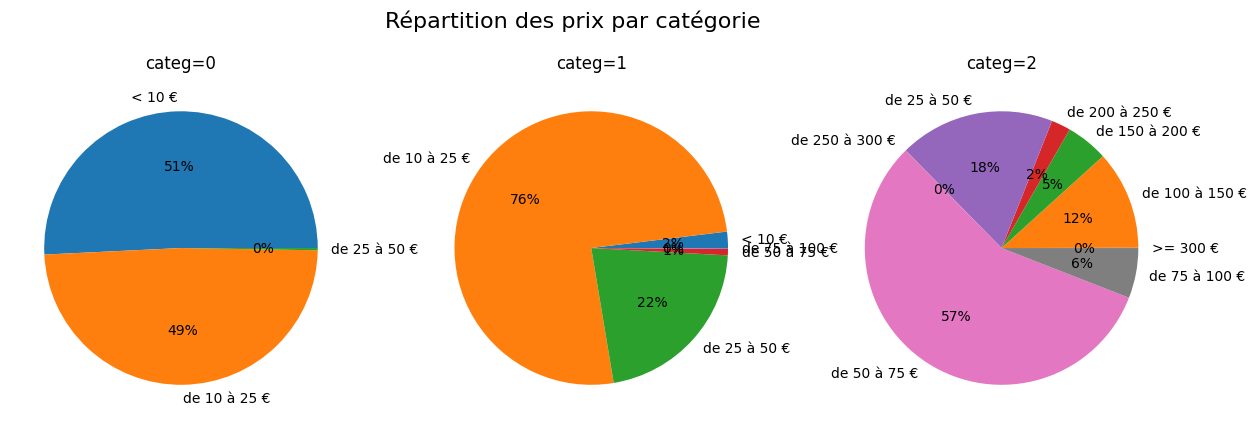

draw_pie_multiple_by_value categ  ................................................. END


In [136]:
df_global_index_sort_tranche_prix_temp = df_global_index_sort_tranche_prix.copy()
df_global_index_sort_tranche_prix_temp['tranche_prix'] = df_global_index_sort_tranche_prix_temp['tranche_prix'].astype("object")
draw_pie_multiple_by_value(df_global_index_sort_tranche_prix_temp,'categ', df_global_index_sort_tranche_prix_temp['categ'].unique(), 'tranche_prix', "Répartition des prix par catégorie", legend=False, verbose=verbose)

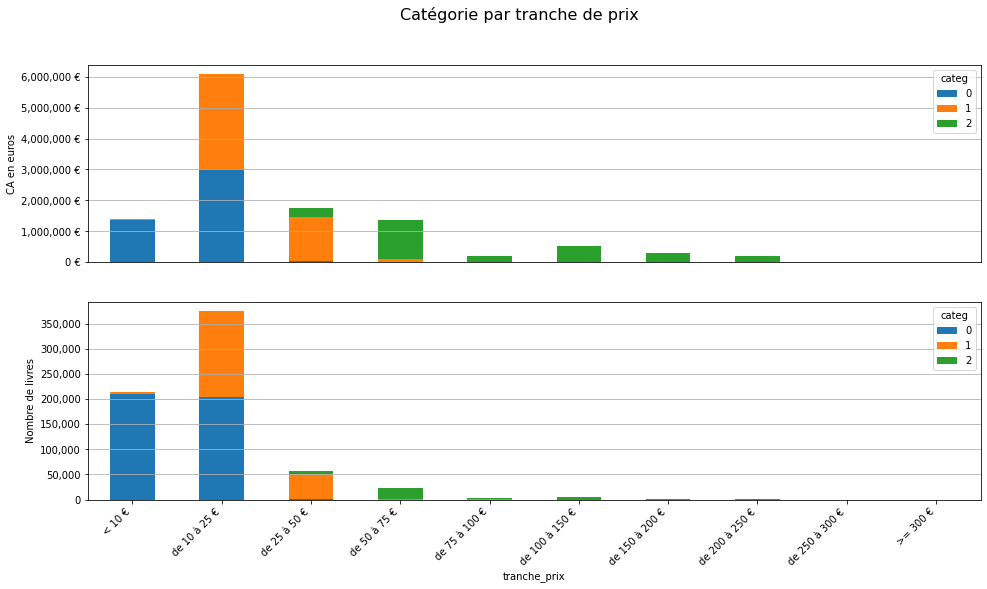

In [137]:
draw_bar_tranches(df_global_index_sort_tranche_prix, ['tranche_prix', 'categ'], sum_col='price', count_col='categ', unstack_col='categ', suptitle="Catégorie par tranche de prix")

#### 1.4.1.2. Mesures de tendance centrale (courbe de Lorenz)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 -  Mesures de tendance centrale (courbe de Lorenz)</h3>
</div>

0.76


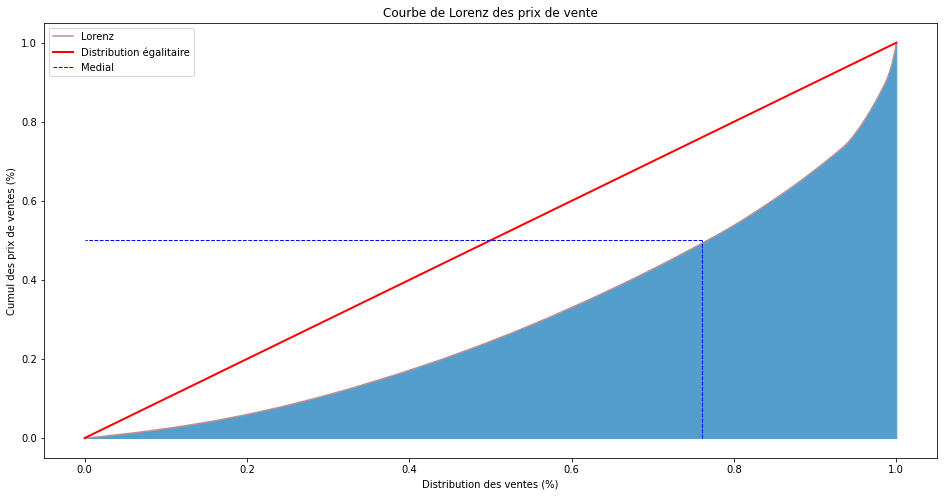

In [138]:
#Courbe de Lorenz sur la variables des prix
#Sélection du sous-échantillon de travail que l'on appelle price
#Tri des individus dans l'ordre croissant des valeurs de la variable,
xmin2 = .76
price = df_global_index['price'].sort_values().values
lorenz_price = lorens(price, 'Courbe de Lorenz des prix de vente', "Distribution des ventes (%)", "Cumul des prix de ventes (%)")

**On constate que 76% des ventes représentent 50% du montant total des prix de vente. Ce n'est pas une égalité totale, mais acceptable dans notre contexte business.**

Les catégories correspondent à des tranches de prix bien définies

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyse démographique (Age) </h2>
</div>   

### 1.4.2. Distribution des âges

In [139]:
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day tranche_prix  
date                                                                         
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20       < 10 €  
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20       < 10 €  
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20       < 10 €  
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18       < 10 €  
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18       < 10 €

In [140]:
df_global_index["age_reel"] = df_global_index["year"]-df_global_index["birth"]
df_global_index["age_reel"] = df_global_index["age_reel"].astype(str)
df_global_index["age_reel"] = df_global_index["age_reel"].astype(int)
df_global_index.dtypes

client_id              object
sex                  category
birth                   int64
session_id             object
id_prod                object
categ                   int32
price                 float64
month_year          period[M]
year            period[A-DEC]
day                 period[D]
tranche_prix           object
age_reel                int32
dtype: object

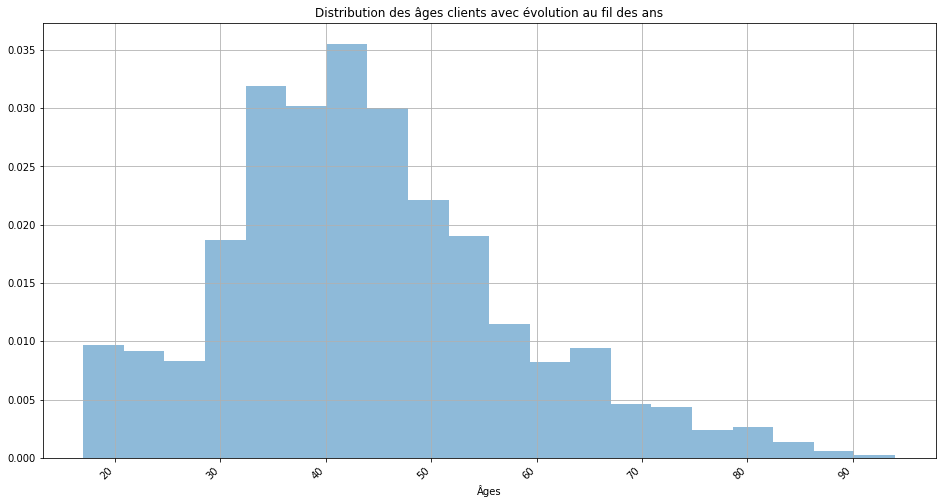

In [141]:
#Visualisation (Histogramme)de la distribution de l'âge clients
figure, axe = color_graph_background(1,1)
df_global_index['age_reel'].hist(density=True, alpha=0.5, bins=20)

plt.xlabel('Âges')
plt.title('Distribution des âges clients avec évolution au fil des ans')
figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

### 1.4.2. Age / Catégories

In [142]:
sorter_age = create_sorter_age()
sorter_age

['<20 ans',
 'de 20 à 30 ans',
 'de 30 à 40 ans',
 'de 40 à 50 ans',
 'de 50 à 60 ans',
 'de 60 à 70 ans',
 '+70 ans']

In [143]:
df_global_index['tranche_age'] = df_global_index['age_reel'].map(category_age)
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day tranche_prix  \
date                                                                          
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20       < 10 €   
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20       < 10 €   
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20       < 10 €   
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18       < 10 €   
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18       < 10 €   

                            age_reel     tranche_age  
date                                                  
2022-05-20 13:21:29.043970        36  de 30 à 40 ans  
2021-07-20 13:21:29.043970        35  de 30 à 40 ans  
2022-08-20 13:21:29.043970        36  de 30 à 40 ans  
2022-06-18 01:49:37.823274        36  de 30 à 40 ans  
2021-08-18 01:49:37.823274        35  de 30 à 40 ans

In [144]:
df_global_index_sort_tranche_age = df_global_index.copy()
df_global_index_sort_tranche_age['tranche_age'] = df_global_index_sort_tranche_age['tranche_age'].astype("category")
df_global_index_sort_tranche_age['tranche_age'] = df_global_index_sort_tranche_age['tranche_age'].cat.set_categories(sorter_age)
df_global_index_sort_tranche_age = df_global_index_sort_tranche_age.sort_values('tranche_age')
df_global_index_sort_tranche_age

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-11-06 19:05:29.040704    c_8291   m   2003   s_293644   1_366      1   
2021-08-28 07:23:23.460271    c_1284   f   2004    s_81730  0_1288      0   
2022-09-28 07:23:23.460271    c_1284   f   2004   s_274680  0_1288      0   
2023-01-28 07:26:39.007752    c_1284   f   2004   s_333530  0_1420      0   
2021-08-28 07:26:39.007752    c_1284   f   2004    s_81730  0_1420      0   
...                              ...  ..    ...        ...     ...    ...   
2022-01-17 12:44:10.535314    c_8384   m   1939   s_151146  0_1304      0   
2022-05-17 12:44:10.535314    c_8384   m   1939   s_209946  0_1304      0   
2021-08-29 08:27:36.050182    c_8384   m   1939    s_82146  0_1437      0   
2021-04-01 02:15:26.548333    c_1495   m   1945    s_14249  0_1659      0   
2021-11-25 11:39:09.734954    c_3772   f   1941   s_124848   1_431      1   

                            price month_year  year         day  tranche_prix  \
date                                                                           
2022-11-06 19:05:29.040704  28.54    2022-11  2022  2022-11-06  de 25 à 50 €   
2021-08-28 07:23:23.460271   9.55    2021-08  2021  2021-08-28        < 10 €   
2022-09-28 07:23:23.460271   9.55    2022-09  2022  2022-09-28        < 10 €   
2023-01-28 07:26:39.007752  11.53    2023-01  2023  2023-01-28  de 10 à 25 €   
2021-08-28 07:26:39.007752  11.53    2021-08  2021  2021-08-28  de 10 à 25 €   
...                           ...        ...   ...         ...           ...   
2022-01-17 12:44:10.535314   5.86    2022-01  2022  2022-01-17        < 10 €   
2022-05-17 12:44:10.535314   5.86    2022-05  2022  2022-05-17        < 10 €   
2021-08-29 08:27:36.050182   3.99    2021-08  2021  2021-08-29        < 10 €   
2021-04-01 02:15:26.548333   9.99    2021-04  2021  2021-04-01        < 10 €   
2021-11-25 11:39:09.734954  27.99    2021-11  2021  2021-11-25  de 25 à 50 €   

                            age_reel tranche_age  
date                                              
2022-11-06 19:05:29.040704        19     <20 ans  
2021-08-28 07:23:23.460271        17     <20 ans  
2022-09-28 07:23:23.460271        18     <20 ans  
2023-01-28 07:26:39.007752        19     <20 ans  
2021-08-28 07:26:39.007752        17     <20 ans  
...                              ...         ...  
2022-01-17 12:44:10.535314        83     +70 ans  
2022-05-17 12:44:10.535314        83     +70 ans  
2021-08-29 08:27:36.050182        82     +70 ans  
2021-04-01 02:15:26.548333        76     +70 ans  
2021-11-25 11:39:09.734954        80     +70 ans  

[679111 rows x 13 columns]

In [145]:
df_global_index_sort_tranche_age_temp = df_global_index_sort_tranche_age.copy()
df_global_index_sort_tranche_age_temp['tranche_age'] = df_global_index_sort_tranche_age_temp['tranche_age'].astype("object")

In [146]:
cate = df_global_index_sort_tranche_age_temp['categ'].unique()
cate = sorted(cate)
cate

[0, 1, 2]

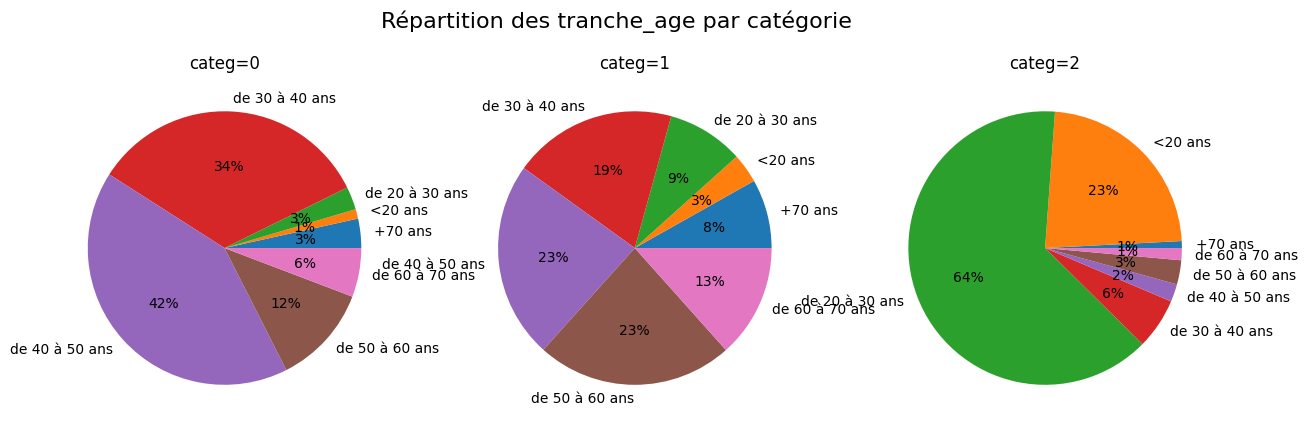

draw_pie_multiple_by_value categ  ................................................. END


In [147]:
draw_pie_multiple_by_value(df_global_index_sort_tranche_age_temp,'categ', cate, 'tranche_age', "Répartition des tranche_age par catégorie", legend=False, verbose=verbose)

In [148]:
df_ca_age = df_global_index_sort_tranche_age.groupby(['tranche_age', 'categ'])['price'].agg(['sum', 'mean','count'])
df_ca_age = df_ca_age.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres achetes"})
df_ca_age.head()

ca  prix moyen  nb livres achetes
tranche_age    categ                                          
<20 ans        0       49356.48   10.550765               4678
               1      163193.23   20.662602               7898
               2      635208.65   75.593080               8403
de 20 à 30 ans 0      120435.84   10.697801              11258
               1      421776.32   20.474579              20600

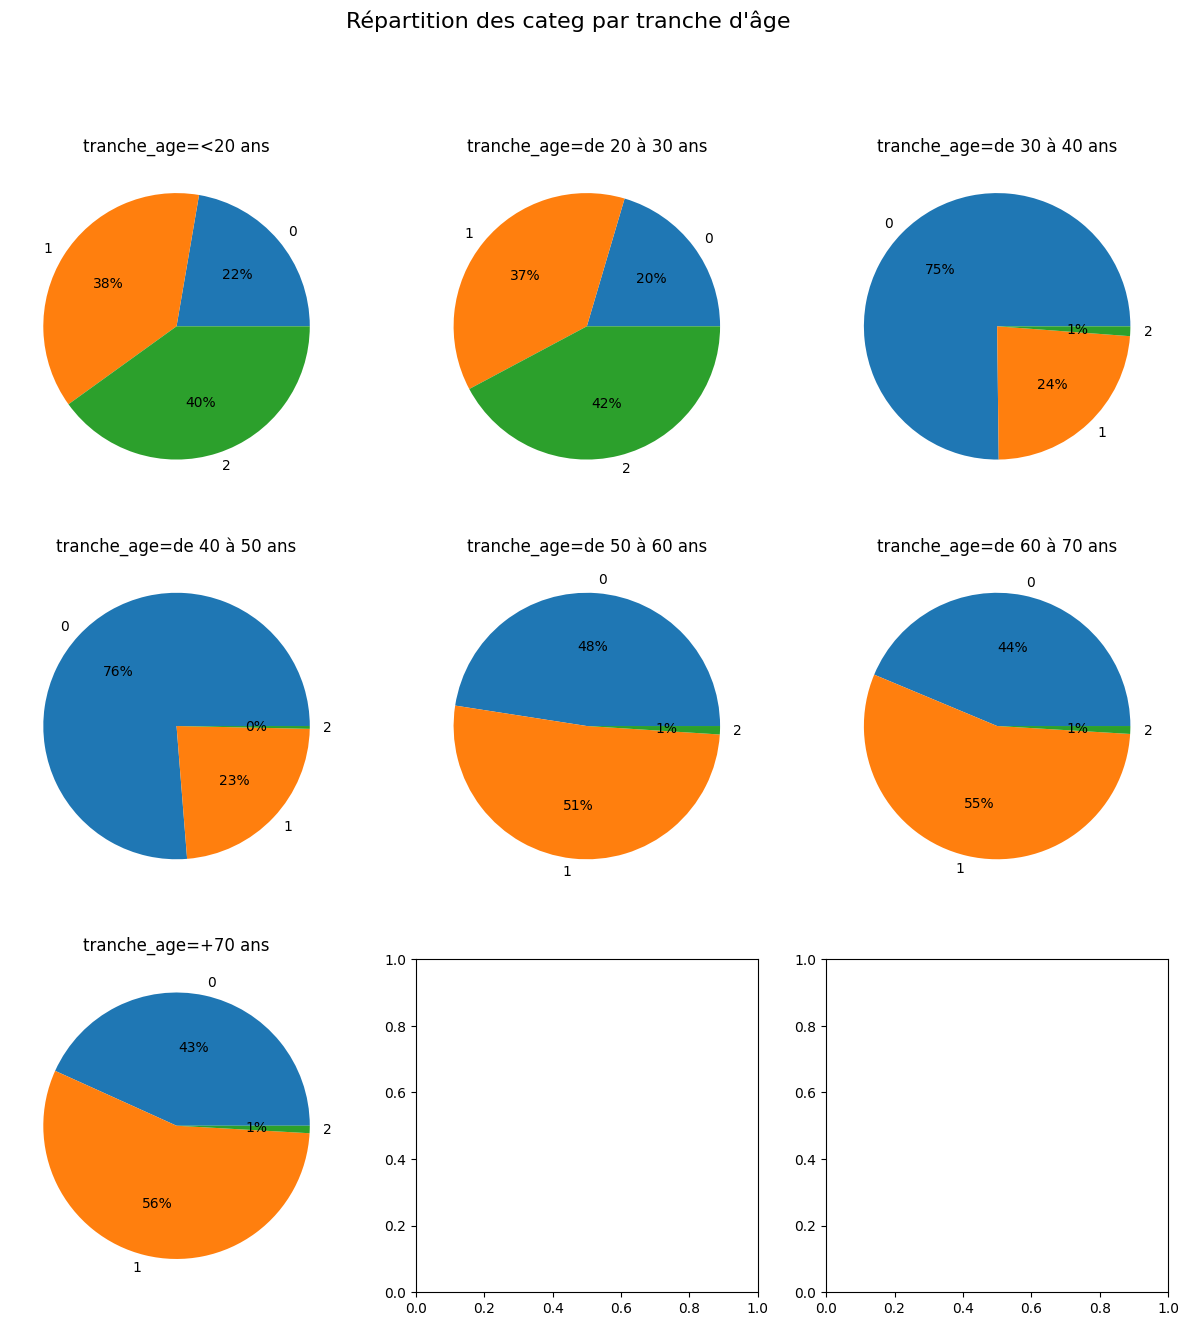

draw_pie_multiple_by_value tranche_age  ................................................. END


In [149]:
draw_pie_multiple_by_value(df_global_index_sort_tranche_age,'tranche_age', sorter_age, 'categ', "Répartition des categ par tranche d'âge", legend=False, verbose=verbose, max_col=3)

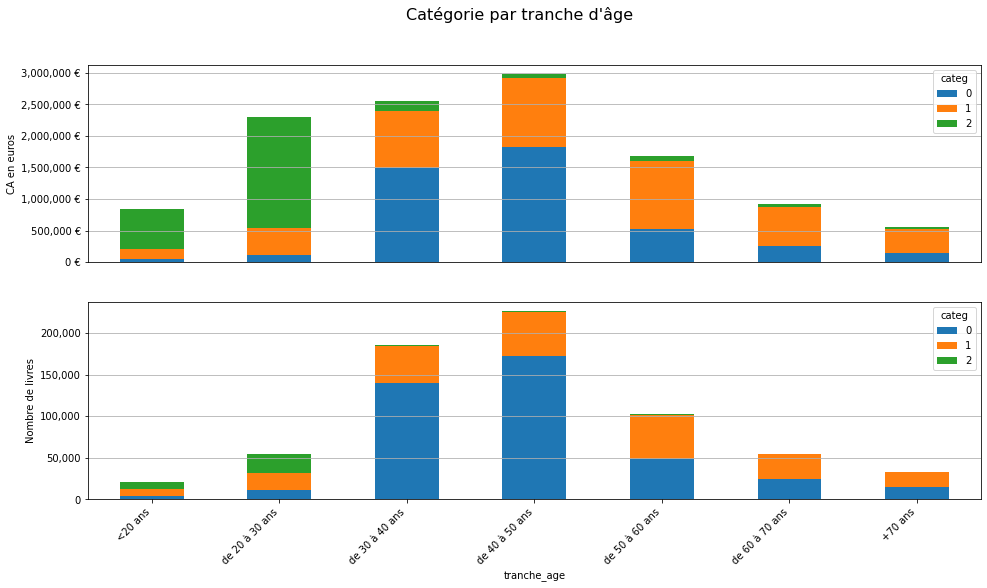

In [150]:
draw_bar_tranches(df_global_index_sort_tranche_age, ['tranche_age', 'categ'], sum_col='price', count_col='categ', unstack_col='categ', suptitle="Catégorie par tranche d'âge")

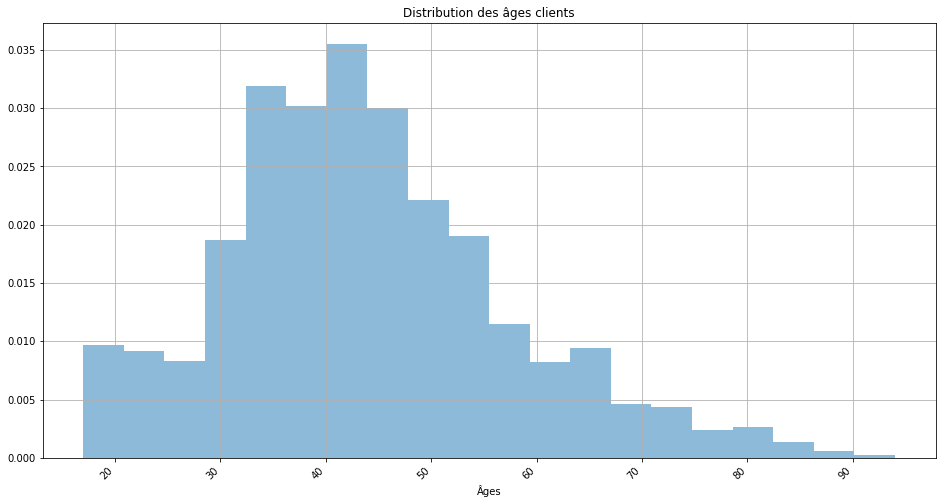

In [151]:
#Visualisation (Histogramme)de la distribution de l'âge clients
figure, axe = color_graph_background(1,1)
df_global_index['age_reel'].hist(density=True, alpha=0.5, bins=20)

plt.xlabel('Âges')
plt.title('Distribution des âges clients')
figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">5. Analyse de variable : sex </h2>
</div>   

### 1.4.3. CA par sexe

In [152]:
df_global_index[~df_global_index["sex"].isna()]["sex"].value_counts()

m    340826
f    338285
Name: sex, dtype: int64

In [153]:
# DF Globale
column_name ="sex"
df_1 = df_global_index.groupby([column_name])['price'].agg(['sum', 'mean','count'])
df_1 = df_1.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres achetes"})
# DF sans octobre
df_2 = df_global_index_less_10.groupby([column_name])['price'].agg(['sum', 'mean','count'])
df_2 = df_2.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres achetes"})
df_2['ca'].head()

sex
f    5448955.66
m    5576056.51
Name: ca, dtype: float64

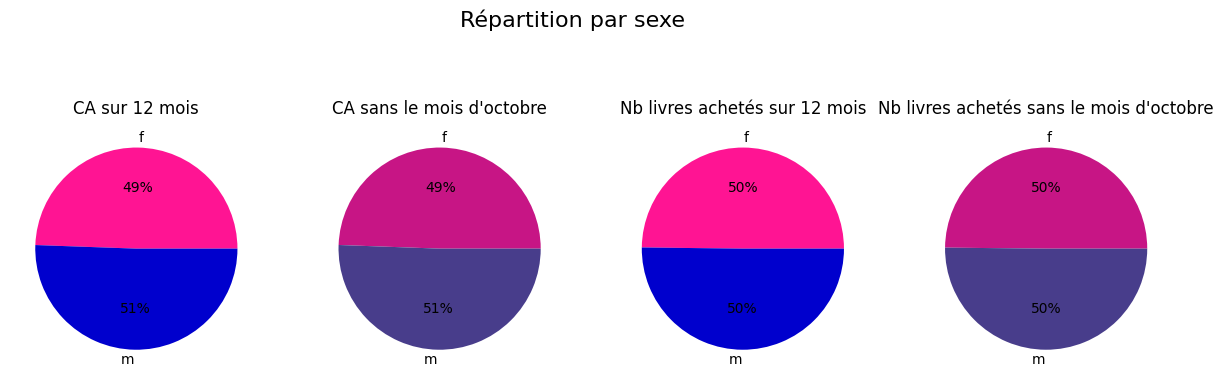

In [154]:
colors=["deeppink", "mediumblue"]
colors2=["mediumvioletred", "darkslateblue"]

figure, axes = color_graph_background(1,4)

axes[0].pie(df_1['ca'], labels=df_1.index, autopct='%.0f%%', colors=colors)
axes[0].title.set_text('CA sur 12 mois')
axes[1].pie(df_2['ca'], labels=df_2.index, autopct='%.0f%%', colors=colors2)
axes[1].title.set_text("CA sans le mois d'octobre")

axes[2].pie(df_1['nb livres achetes'], labels=df_1.index, autopct='%.0f%%', colors=colors)
axes[2].title.set_text('Nb livres achetés sur 12 mois')
axes[3].pie(df_2['nb livres achetes'], labels=df_2.index, autopct='%.0f%%', colors=colors2)
axes[3].title.set_text("Nb livres achetés sans le mois d'octobre")

figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Répartition par sexe", fontsize=16)
plt.show()

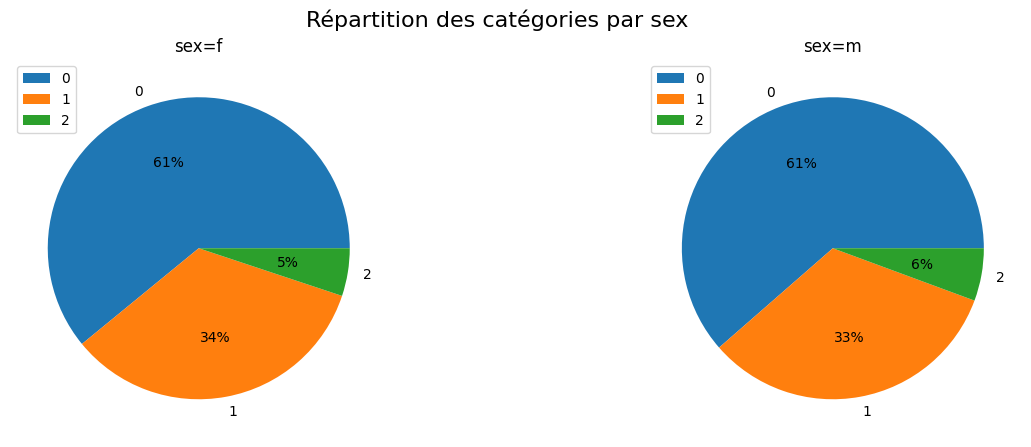

draw_pie_multiple_by_value sex  ................................................. END


In [155]:
draw_pie_multiple_by_value(df_global_index,'sex', df_global_index['sex'].unique(), 'categ', "Répartition des catégories par sex", verbose=verbose)

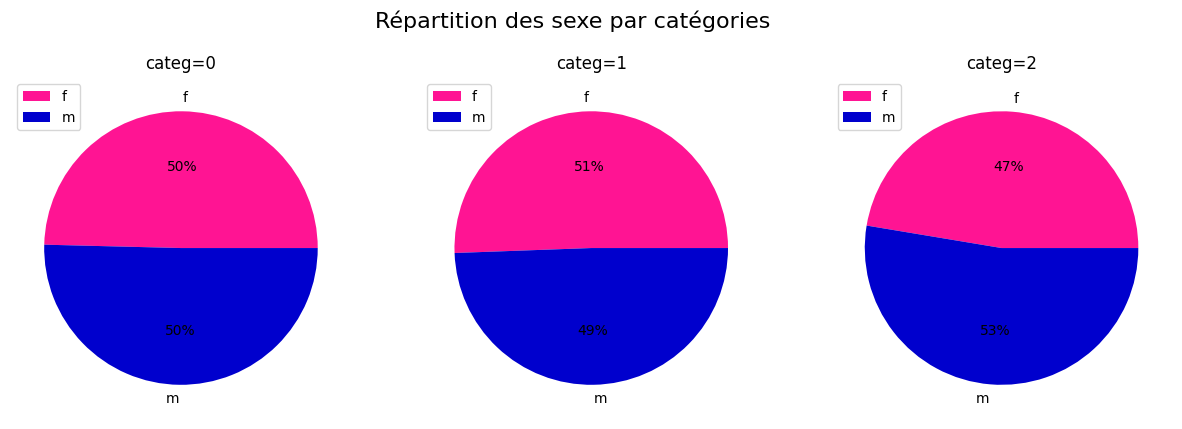

draw_pie_multiple_by_value categ  ................................................. END


In [156]:
colors=["deeppink", "mediumblue"]
draw_pie_multiple_by_value(df_global_index,'categ', df_global_index['categ'].unique(), 'sex', "Répartition des sexe par catégories", verbose=verbose, colors=colors)

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">3. Analyse de la variable : categ </h2>
</div>  


In [157]:
#Représentation des effectifs par catégories de vente(méthode .value_counts())
effectif = df_global_index['categ'].value_counts()
modalite =df_global_index['categ'].value_counts().index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['categ']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(df_global_index) #len(data) renvoie la taille de l'échantillon
tab

categ       n         f
0      0  415459  0.611769
1      1  227169  0.334509
2      2   36483  0.053722

In [158]:
#Fréquences cumulées
tab = tab.sort_values("categ") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée
tab

categ       n         f         F
0      0  415459  0.611769  0.611769
1      1  227169  0.334509  0.946278
2      2   36483  0.053722  1.000000

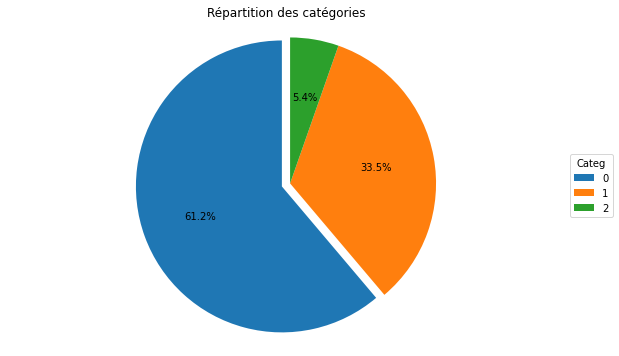

In [161]:
#Pie Chart pour représenter la part de chacune des catégories de vente
labels = 'Cat 0', 'Cat 1', 'Cat 2'
sizes = tab['f']
explode = (0.06, 0, 0)

fig1, ax1 = color_graph_background(1,1)
ax1.pie(sizes, explode=explode, autopct='%1.1f%%', shadow=False, startangle=90)
plt.legend(modalite,
          title="Categ",
          loc="center left",
          bbox_to_anchor=(1, 0, 1, 1))
ax1.axis('equal') 
plt.title('Répartition des catégories')
fig1.set_size_inches(10, 6, forward=True)
plt.show()

### 1.4.4. CA par catégorie

In [162]:
df_ca_categ2 = df_global_index.groupby(['categ'])['price'].agg(['sum', 'mean','count'])
df_ca_categ2 = df_ca_categ2.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres achetes"})
df_ca_categ2

ca  prix moyen  nb livres achetes
categ                                           
0      4419730.97   10.638188             415459
1      4653722.69   20.485730             227169
2      2780275.02   76.207412              36483

In [163]:
df_ca_categ2.index

Int64Index([0, 1, 2], dtype='int64', name='categ')

In [164]:
df_ca_categ3 = df_global_index_less_10.groupby(['categ'])['price'].agg(['sum', 'mean','count'])
df_ca_categ3 = df_ca_categ3.rename(columns={"sum": "ca", "mean":"prix moyen", "count":"nb livres achetes"})
df_ca_categ3

ca  prix moyen  nb livres achetes
categ                                           
0      4033050.97   10.640369             379033
1      4420350.71   20.485736             215777
2      2571610.49   76.222968              33738

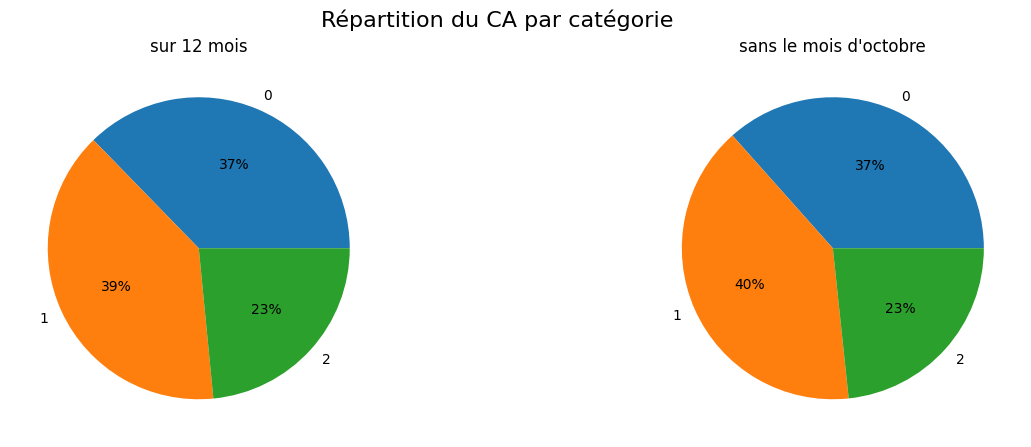

In [165]:
figure, axes = color_graph_background(1,2)
axes[0].pie(df_ca_categ2['ca'], labels=df_ca_categ2.index, autopct='%.0f%%')
axes[0].title.set_text('sur 12 mois')

axes[1].pie(df_ca_categ3['ca'], labels=df_ca_categ3.index, autopct='%.0f%%')
axes[1].title.set_text("sans le mois d'octobre")

figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Répartition du CA par catégorie", fontsize=16)
plt.show()

Avec ou sans les mois d'octobre, les ratios sont les mêmes entre les 3 catégories

### 1.4.5. Flops et les Tops

In [166]:
print(not_sales_product.shape)
not_sales_product.head()

(21, 7)


id_prod date session_id client_id  price  categ      _merge
679332  0_1016  NaN        NaN       NaN  35.06    0.0  right_only
679333  0_1780  NaN        NaN       NaN   1.67    0.0  right_only
679334  0_1062  NaN        NaN       NaN  20.08    0.0  right_only
679335  0_1119  NaN        NaN       NaN   2.99    0.0  right_only
679336  0_1014  NaN        NaN       NaN   1.15    0.0  right_only

Il y a **21 produits non vendus**    
Produits les moins vendus

In [167]:
group_produits = df_global_index.groupby(['id_prod'])['price'].agg(['sum', 'count'])
group_produits = group_produits.rename(columns={"sum": "ca", "count":"nb livres vendus"})
group_produits = group_produits.sort_values(by="nb livres vendus", ascending=True)
group_produits.head()

ca  nb livres vendus
id_prod                         
0_2201   20.99                 1
0_1601    1.99                 1
0_549     2.99                 1
2_81     86.99                 1
0_807     1.99                 1

#### 1.4.5.1 En nombre de livres vendus

In [168]:
nb_total_livre_vendu = group_produits["nb livres vendus"].sum()
nb_total_livre_vendu

679111

In [169]:
group_produits["% livre vendu"] = (group_produits["nb livres vendus"]/nb_total_livre_vendu)*100
group_produits.head()

ca  nb livres vendus  % livre vendu
id_prod                                        
0_2201   20.99                 1       0.000147
0_1601    1.99                 1       0.000147
0_549     2.99                 1       0.000147
2_81     86.99                 1       0.000147
0_807     1.99                 1       0.000147

In [170]:
group_produits.describe()

ca  nb livres vendus  % livre vendu
count   3265.000000       3265.000000    3265.000000
mean    3630.544772        207.997243       0.030628
std     7371.925385        331.361777       0.048793
min        0.990000          1.000000       0.000147
25%      233.820000         17.000000       0.002503
50%      796.860000         57.000000       0.008393
75%     3408.600000        239.000000       0.035193
max    94893.500000       2252.000000       0.331610

In [171]:
flop_value = 17
top_value = 239
print(group_produits.shape)
print("Flop :",group_produits[group_produits["nb livres vendus"]<flop_value].shape, " / Top :", group_produits[group_produits["nb livres vendus"]>top_value].shape)

(3265, 3)
Flop : (810, 3)  / Top : (816, 3)


On voit avec le describe que si l'on prend le premier quart (le flop), concerne les livres qui se sont vendus à moins de 17 exemplaires
Et le top (dernier quart) sont les livres qui se sont vendus à plus de 239 exemplaires

#### 1.4.5.2 En CA de livres vendus

In [172]:
ca_total_livre_vendu = group_produits["ca"].sum()
ca_total_livre_vendu

11853728.680000002

In [173]:
group_produits["% ca"] = (group_produits["ca"]/ca_total_livre_vendu)*100
group_produits.head()

ca  nb livres vendus  % livre vendu      % ca
id_prod                                                  
0_2201   20.99                 1       0.000147  0.000177
0_1601    1.99                 1       0.000147  0.000017
0_549     2.99                 1       0.000147  0.000025
2_81     86.99                 1       0.000147  0.000734
0_807     1.99                 1       0.000147  0.000017

In [174]:
group_produits.describe()

ca  nb livres vendus  % livre vendu         % ca
count   3265.000000       3265.000000    3265.000000  3265.000000
mean    3630.544772        207.997243       0.030628     0.030628
std     7371.925385        331.361777       0.048793     0.062191
min        0.990000          1.000000       0.000147     0.000008
25%      233.820000         17.000000       0.002503     0.001973
50%      796.860000         57.000000       0.008393     0.006722
75%     3408.600000        239.000000       0.035193     0.028756
max    94893.500000       2252.000000       0.331610     0.800537

In [175]:
flop_ca = 233
top_ca = 3408
print(group_produits.shape)
print("Flop :",group_produits[group_produits["ca"]<flop_ca].shape, " / Top :", group_produits[group_produits["ca"]>top_ca].shape)

(3265, 4)
Flop : (814, 4)  / Top : (817, 4)


l'idéal est d'identifier les livres qui ont peu été vendus et qui ont peu de CA

In [176]:
print(group_produits.shape)
super_flop = group_produits[group_produits["ca"]<flop_ca]
super_flop = super_flop[super_flop["nb livres vendus"]<flop_value]

super_top = group_produits[group_produits["ca"]>top_ca]
super_top = super_top[super_top["nb livres vendus"]<flop_value]
print("Flop :",super_flop.shape, " / Top :", super_top.shape)

(3265, 4)
Flop : (570, 4)  / Top : (1, 4)


In [177]:
super_top

ca  nb livres vendus  % livre vendu      % ca
id_prod                                                   
2_2      4500.0                15       0.002209  0.037963

In [178]:
super_flop = super_flop.sort_values(by=['% ca', '% livre vendu'])
super_flop.head()

ca  nb livres vendus  % livre vendu      % ca
id_prod                                                 
0_1539   0.99                 1       0.000147  0.000008
0_1284   1.38                 1       0.000147  0.000012
0_1653   1.98                 2       0.000295  0.000017
0_1601   1.99                 1       0.000147  0.000017
0_807    1.99                 1       0.000147  0.000017

Nous avons maintenant la liste des livres qui ont le moins de CA et qui sont le moins vendu.
Ce qui permettrait de prendre des décisions par rapport à ces livres

In [179]:
type(group_produits)

pandas.core.frame.DataFrame

# 2. Une analyse des clients

Comprendre le comportement des clients en ligne
Comparaison avec le comportement des cliens en librairie

1. Genre d'un client et catégorie de livre acheté (cf. § 1.4.3)
1. Age d'un client et montant total des achats (cf. § 1.4.2)
1. Age catégorie de livre acheté (cf. § 1.4.2)
1. Age fréquance d'achat
1. Age taille du panier moyen


## 2.1. Age > Repartition âge

Quelle proportion d'âge est la plus présente et pourquoi à votre avis ?

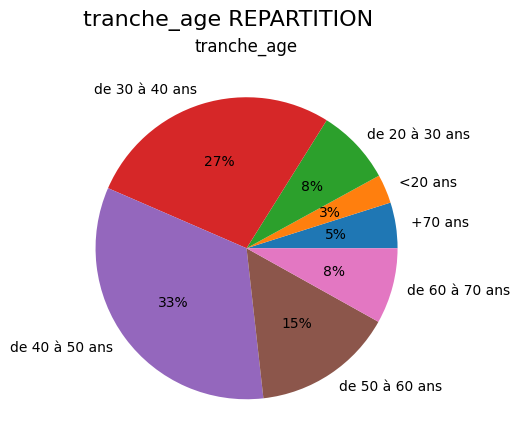

draw_pie tranche_age  ................................................. END


In [180]:
draw_pie_multiple(df_global_index, ['tranche_age'],colors=None, verbose=verbose, legend=False)

In [181]:
df_global_index["age_fixe"] = 2021 - df_global_index["birth"]
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day tranche_prix  \
date                                                                          
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20       < 10 €   
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20       < 10 €   
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20       < 10 €   
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18       < 10 €   
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18       < 10 €   

                            age_reel     tranche_age  age_fixe  
date                                                            
2022-05-20 13:21:29.043970        36  de 30 à 40 ans        35  
2021-07-20 13:21:29.043970        35  de 30 à 40 ans        35  
2022-08-20 13:21:29.043970        36  de 30 à 40 ans        35  
2022-06-18 01:49:37.823274        36  de 30 à 40 ans        35  
2021-08-18 01:49:37.823274        35  de 30 à 40 ans        35

In [182]:
df_customers.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [191]:
df_customers_analyse = df_customers.copy()
df_customers_analyse["age_2021"]  = 2021 - df_customers_analyse["birth"]
df_customers_analyse = df_customers_analyse.sort_values(by="age_2021")
df_customers_analyse.head()

client_id sex  birth  age_2021
1920    c_3923   f   2004        17
7318    c_1358   f   2004        17
1045    c_7765   m   2004        17
1049    c_3004   m   2004        17
1053    c_3329   m   2004        17

In [193]:
colors_list = []
nb_age = len(df_customers_analyse['age_2021'].unique()+10)
for i in range(0, nb_age):
    colors_list.append(cm.hsv(i/nb_age))

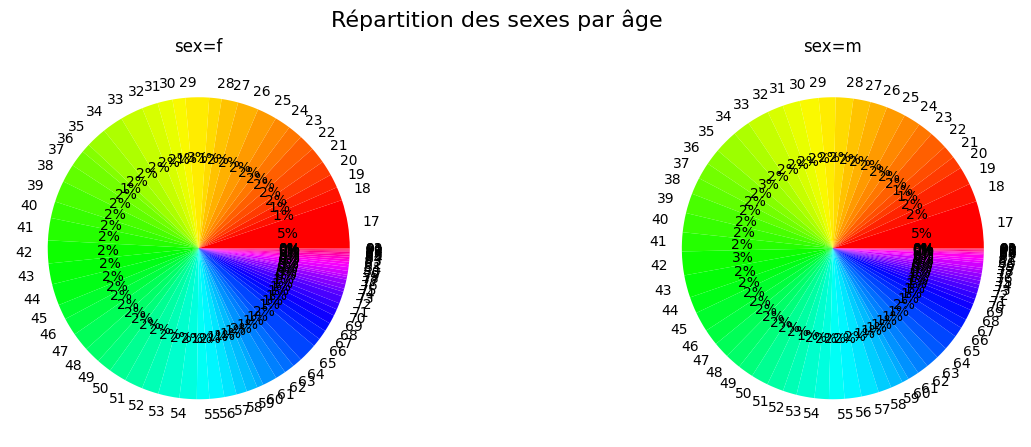

draw_pie_multiple_by_value sex  ................................................. END


In [194]:
draw_pie_multiple_by_value(df_customers_analyse,'sex', df_customers_analyse['sex'].unique(), 'age_2021', "Répartition des sexes par âge", verbose=verbose, colors=colors_list, legend=False)

In [195]:
df_customer_age = pd.crosstab(df_customers_analyse['age_2021'],df_customers_analyse['sex'])
df_customer_age.head()

sex         f    m
age_2021          
17        232  208
18         65   81
19         66   80
20         72   57
21         78   58

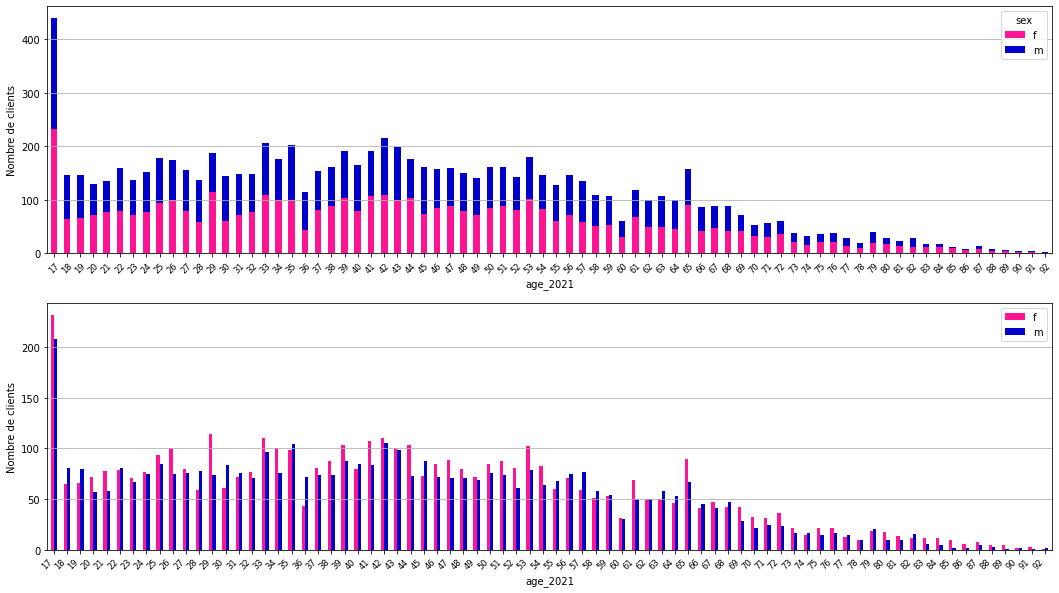

In [196]:
fig, axes = color_graph_background(2, 1)
fig.set_size_inches(18, 10, forward=True)
ax = axes[0]
df_customer_age.plot(kind='bar',stacked=True, ax=ax, color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
ax.set_ylabel("Nombre de clients")
ax.grid(axis='y')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_size('small')


ax = axes[1]
df_customer_age.plot(kind='bar', ax=ax, color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
ax.set_ylabel("Nombre de clients")
ax.grid(axis='y')

plt.xticks(rotation=45, ha="right", size='small')
plt.legend()
plt.show()

Il semble y avoir une particularité pour la tranche de 17 ans

In [197]:
df_global_index

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   
...                              ...  ..    ...        ...     ...    ...   
2021-07-23 07:01:38.963669    c_4391   f   2001    s_65994   2_147      2   
2022-03-25 18:07:25.880052    c_1232   f   1960   s_184472   0_142      0   
2021-09-25 18:07:25.880052    c_1232   f   1960    s_95415   0_142      0   
2021-03-11 00:11:32.016264    c_7534   m   1992     s_4605   2_205      2   
2022-07-11 00:11:32.016264    c_7534   m   1992   s_236636   2_205      2   

                             price month_year  year         day  \
date                                                              
2022-05-20 13:21:29.043970    4.18    2022-05  2022  2022-05-20   
2021-07-20 13:21:29.043970    4.18    2021-07  2021  2021-07-20   
2022-08-20 13:21:29.043970    4.18    2022-08  2022  2022-08-20   
2022-06-18 01:49:37.823274    8.57    2022-06  2022  2022-06-18   
2021-08-18 01:49:37.823274    8.57    2021-08  2021  2021-08-18   
...                            ...        ...   ...         ...   
2021-07-23 07:01:38.963669  181.99    2021-07  2021  2021-07-23   
2022-03-25 18:07:25.880052   19.85    2022-03  2022  2022-03-25   
2021-09-25 18:07:25.880052   19.85    2021-09  2021  2021-09-25   
2021-03-11 00:11:32.016264  100.99    2021-03  2021  2021-03-11   
2022-07-11 00:11:32.016264  100.99    2022-07  2022  2022-07-11   

                              tranche_prix  age_reel     tranche_age  age_fixe  
date                                                                            
2022-05-20 13:21:29.043970          < 10 €        36  de 30 à 40 ans        35  
2021-07-20 13:21:29.043970          < 10 €        35  de 30 à 40 ans        35  
2022-08-20 13:21:29.043970          < 10 €        36  de 30 à 40 ans        35  
2022-06-18 01:49:37.823274          < 10 €        36  de 30 à 40 ans        35  
2021-08-18 01:49:37.823274          < 10 €        35  de 30 à 40 ans        35  
...                                    ...       ...             ...       ...  
2021-07-23 07:01:38.963669  de 150 à 200 €        20  de 20 à 30 ans        20  
2022-03-25 18:07:25.880052    de 10 à 25 €        62  de 60 à 70 ans        61  
2021-09-25 18:07:25.880052    de 10 à 25 €        61  de 60 à 70 ans        61  
2021-03-11 00:11:32.016264  de 100 à 150 €        29  de 20 à 30 ans        29  
2022-07-11 00:11:32.016264  de 100 à 150 €        30  de 30 à 40 ans        29  

[679111 rows x 14 columns]

In [198]:
df_17 = df_global_index[df_global_index["age_fixe"]==17]
print(df_17.shape)
df_17.head()

(15149, 14)


client_id sex  birth session_id id_prod  categ  \
date                                                                        
2021-12-31 22:27:43.118944    c_8437   f   2004   s_143083  0_1518      0   
2021-12-31 22:53:37.441675    c_8437   f   2004   s_143083  0_1443      0   
2021-12-31 22:34:56.294595    c_8437   f   2004   s_143083  0_1474      0   
2021-12-31 22:31:41.975716    c_8437   f   2004   s_143083   1_721      1   
2021-06-16 14:24:29.332462    c_8437   f   2004    s_49498    2_41      2   

                            price month_year  year         day  tranche_prix  \
date                                                                           
2021-12-31 22:27:43.118944   4.18    2021-12  2021  2021-12-31        < 10 €   
2021-12-31 22:53:37.441675   5.99    2021-12  2021  2021-12-31        < 10 €   
2021-12-31 22:34:56.294595   9.88    2021-12  2021  2021-12-31        < 10 €   
2021-12-31 22:31:41.975716  21.99    2021-12  2021  2021-12-31  de 10 à 25 €   
2021-06-16 14:24:29.332462  68.99    2021-06  2021  2021-06-16  de 50 à 75 €   

                            age_reel tranche_age  age_fixe  
date                                                        
2021-12-31 22:27:43.118944        17     <20 ans        17  
2021-12-31 22:53:37.441675        17     <20 ans        17  
2021-12-31 22:34:56.294595        17     <20 ans        17  
2021-12-31 22:31:41.975716        17     <20 ans        17  
2021-06-16 14:24:29.332462        17     <20 ans        17

In [199]:
df_17["client_id"].nunique()

437

In [200]:
df_17["categ"].value_counts()

2    6012
1    5719
0    3418
Name: categ, dtype: int64

In [201]:
print("2021:", df_17.loc["2021"]["price"].sum())
print("2022:", df_17.loc["2022"]["price"].sum())
print("2023:", df_17.loc["2023"]["price"].sum())

2021: 241265.83000000002
2022: 311613.53
2023: 56134.33


Il est fort possible que tous les mineurs aient été intégrés dans cette tranche d'age.    
Il faudrait vérifier l'information avec les sachant de la librairie

In [202]:
df_global_index

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   
...                              ...  ..    ...        ...     ...    ...   
2021-07-23 07:01:38.963669    c_4391   f   2001    s_65994   2_147      2   
2022-03-25 18:07:25.880052    c_1232   f   1960   s_184472   0_142      0   
2021-09-25 18:07:25.880052    c_1232   f   1960    s_95415   0_142      0   
2021-03-11 00:11:32.016264    c_7534   m   1992     s_4605   2_205      2   
2022-07-11 00:11:32.016264    c_7534   m   1992   s_236636   2_205      2   

                             price month_year  year         day  \
date                                                              
2022-05-20 13:21:29.043970    4.18    2022-05  2022  2022-05-20   
2021-07-20 13:21:29.043970    4.18    2021-07  2021  2021-07-20   
2022-08-20 13:21:29.043970    4.18    2022-08  2022  2022-08-20   
2022-06-18 01:49:37.823274    8.57    2022-06  2022  2022-06-18   
2021-08-18 01:49:37.823274    8.57    2021-08  2021  2021-08-18   
...                            ...        ...   ...         ...   
2021-07-23 07:01:38.963669  181.99    2021-07  2021  2021-07-23   
2022-03-25 18:07:25.880052   19.85    2022-03  2022  2022-03-25   
2021-09-25 18:07:25.880052   19.85    2021-09  2021  2021-09-25   
2021-03-11 00:11:32.016264  100.99    2021-03  2021  2021-03-11   
2022-07-11 00:11:32.016264  100.99    2022-07  2022  2022-07-11   

                              tranche_prix  age_reel     tranche_age  age_fixe  
date                                                                            
2022-05-20 13:21:29.043970          < 10 €        36  de 30 à 40 ans        35  
2021-07-20 13:21:29.043970          < 10 €        35  de 30 à 40 ans        35  
2022-08-20 13:21:29.043970          < 10 €        36  de 30 à 40 ans        35  
2022-06-18 01:49:37.823274          < 10 €        36  de 30 à 40 ans        35  
2021-08-18 01:49:37.823274          < 10 €        35  de 30 à 40 ans        35  
...                                    ...       ...             ...       ...  
2021-07-23 07:01:38.963669  de 150 à 200 €        20  de 20 à 30 ans        20  
2022-03-25 18:07:25.880052    de 10 à 25 €        62  de 60 à 70 ans        61  
2021-09-25 18:07:25.880052    de 10 à 25 €        61  de 60 à 70 ans        61  
2021-03-11 00:11:32.016264  de 100 à 150 €        29  de 20 à 30 ans        29  
2022-07-11 00:11:32.016264  de 100 à 150 €        30  de 30 à 40 ans        29  

[679111 rows x 14 columns]

In [203]:
df_customer_age_year = pd.crosstab(df_global_index['age_fixe'],df_global_index['year'])
df_customer_age_year.head()

year      2021  2022  2023
age_fixe                  
17        5935  7851  1363
18        1785  2212   374
19        1833  2392   359
20        1664  2204   384
21        1742  2319   352

In [204]:
df_customer_rolling_age_year = pd.crosstab(df_global_index['age_reel'],df_global_index['year'])
df_customer_rolling_age_year.head()

year      2021  2022  2023
age_reel                  
17        5935     0     0
18        1785  7851     0
19        1833  2212  1363
20        1664  2392   374
21        1742  2204   359

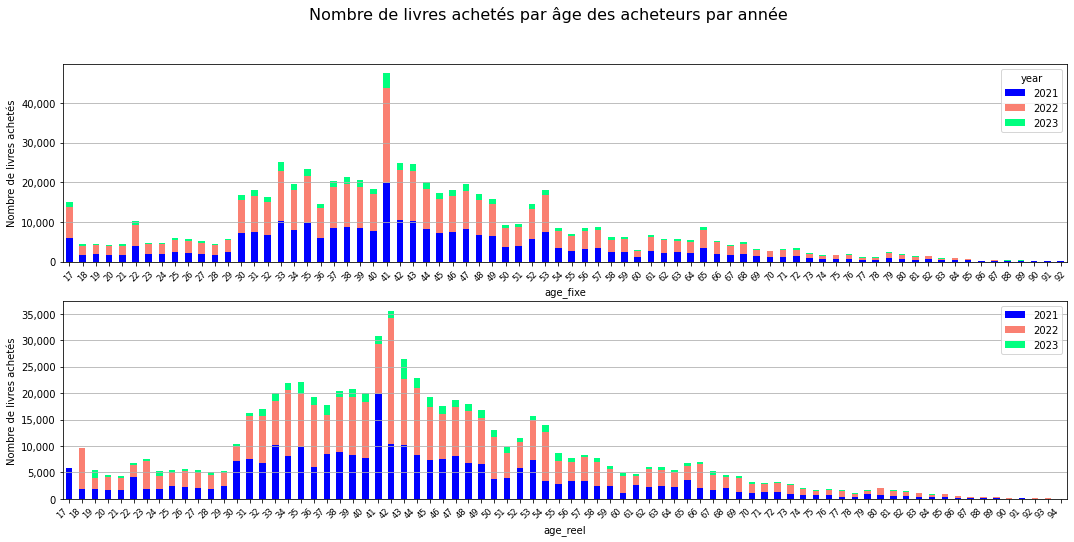

In [205]:
fig, axes = color_graph_background(2, 1)
fig.set_size_inches(18, 8, forward=True)
df_customer_age_year.plot(kind='bar',stacked=True, ax=axes[0], color=["blue", "salmon", "springgreen"])
df_customer_rolling_age_year.plot(kind='bar',stacked=True, ax=axes[1], color=["blue", "salmon", "springgreen"])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axes[0].set_ylabel("Nombre de livres achetés")
axes[0].grid(axis='y')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
    tick.set_size('small')

axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axes[1].set_ylabel("Nombre de livres achetés")
axes[1].grid(axis='y')

plt.xticks(rotation=45, ha="right", size='small')
fig.suptitle("Nombre de livres achetés par âge des acheteurs par année", fontsize=16)
plt.legend()
plt.show()

Il y a un impact sur le fait de calculer l'âge des clients par rapport à une année fixe (2021) ou l'âge par rapport à la date leur achat

0.62


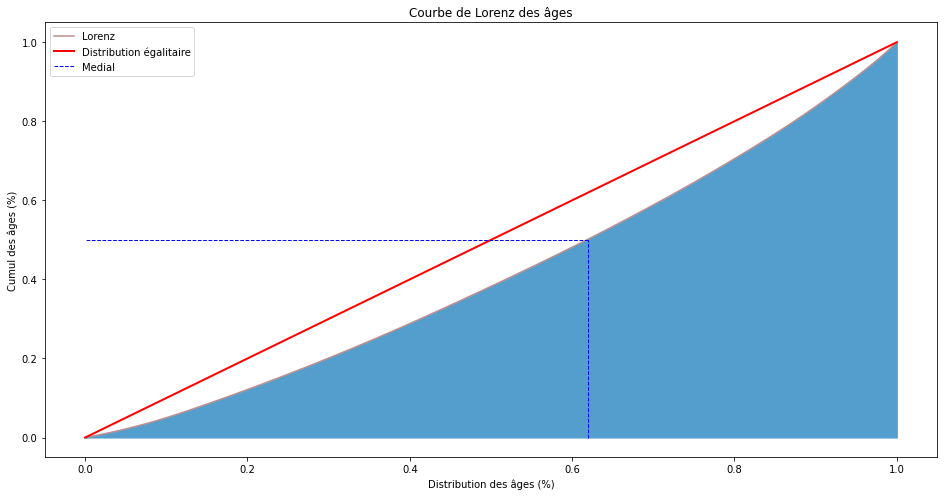

In [208]:
#Courbe de Lorenz sur la variables des prix
#Sélection du sous-échantillon de travail que l'on appelle price
#Tri des individus dans l'ordre croissant des valeurs de la variable,
ages = df_global_index['age_reel'].sort_values().values
lorenz_ages = lorens(ages, "Courbe de Lorenz des âges", "Distribution des âges (%)", "Cumul des âges (%)")

In [209]:
#Aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
aire_ss_courbe_age = lorenz_ages[:-1].sum()/len(lorenz_ages) 

#Aire entre la 1e bissectrice et la courbe de Lorenz
S = 0.5 - aire_ss_courbe_age
gini_age = round(2*S, 2)

print("L'indice de Gini est égal à {}".format(gini_age))

L'indice de Gini est égal à 0.17


## 2.3. Age > fréquence d'achat et taille panier moyen

In [210]:
df_global_index.head()

client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day tranche_prix  \
date                                                                          
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20       < 10 €   
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20       < 10 €   
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20       < 10 €   
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18       < 10 €   
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18       < 10 €   

                            age_reel     tranche_age  age_fixe  
date                                                            
2022-05-20 13:21:29.043970        36  de 30 à 40 ans        35  
2021-07-20 13:21:29.043970        35  de 30 à 40 ans        35  
2022-08-20 13:21:29.043970        36  de 30 à 40 ans        35  
2022-06-18 01:49:37.823274        36  de 30 à 40 ans        35  
2021-08-18 01:49:37.823274        35  de 30 à 40 ans        35

In [211]:
df_global_index.describe(include="all")

client_id     sex          birth session_id id_prod          categ  \
count     679111  679111  679111.000000     679111  679111  679111.000000   
unique      8600       2            NaN     342275    3265            NaN   
top       c_1609       m            NaN   s_118668   1_369            NaN   
freq       25488  340826            NaN         14    2252            NaN   
mean         NaN     NaN    1977.811149        NaN     NaN       0.441953   
std          NaN     NaN      13.575361        NaN     NaN       0.595042   
min          NaN     NaN    1929.000000        NaN     NaN       0.000000   
25%          NaN     NaN    1970.000000        NaN     NaN       0.000000   
50%          NaN     NaN    1980.000000        NaN     NaN       0.000000   
75%          NaN     NaN    1987.000000        NaN     NaN       1.000000   
max          NaN     NaN    2004.000000        NaN     NaN       2.000000   

                price month_year    year         day  tranche_prix  \
count   679111.000000     679111  679111      679111        679111   
unique            NaN         24       3         730            10   
top               NaN    2021-09    2022  2022-11-30  de 10 à 25 €   
freq              NaN      33314  346380        1311        375444   
mean        17.454773        NaN     NaN         NaN           NaN   
std         18.328998        NaN     NaN         NaN           NaN   
min          0.620000        NaN     NaN         NaN           NaN   
25%          8.870000        NaN     NaN         NaN           NaN   
50%         13.990000        NaN     NaN         NaN           NaN   
75%         18.990000        NaN     NaN         NaN           NaN   
max        300.000000        NaN     NaN         NaN           NaN   

             age_reel     tranche_age       age_fixe  
count   679111.000000          679111  679111.000000  
unique            NaN               7            NaN  
top               NaN  de 40 à 50 ans            NaN  
freq              NaN          226118            NaN  
mean        43.859354             NaN      43.188851  
std         13.591033             NaN      13.575361  
min         17.000000             NaN      17.000000  
25%         35.000000             NaN      34.000000  
50%         42.000000             NaN      41.000000  
75%         51.000000             NaN      51.000000  
max         94.000000             NaN      92.000000

il faut récupérer les clients de manière unique et unitaire par jour

In [212]:
client_freq_achat = df_global_index[["client_id", "sex", "tranche_age", "age_reel", "day", "year"]]
client_freq_achat

client_id sex     tranche_age  age_reel  \
date                                                                 
2022-05-20 13:21:29.043970     c_103   f  de 30 à 40 ans        36   
2021-07-20 13:21:29.043970     c_103   f  de 30 à 40 ans        35   
2022-08-20 13:21:29.043970     c_103   f  de 30 à 40 ans        36   
2022-06-18 01:49:37.823274     c_103   f  de 30 à 40 ans        36   
2021-08-18 01:49:37.823274     c_103   f  de 30 à 40 ans        35   
...                              ...  ..             ...       ...   
2021-07-23 07:01:38.963669    c_4391   f  de 20 à 30 ans        20   
2022-03-25 18:07:25.880052    c_1232   f  de 60 à 70 ans        62   
2021-09-25 18:07:25.880052    c_1232   f  de 60 à 70 ans        61   
2021-03-11 00:11:32.016264    c_7534   m  de 20 à 30 ans        29   
2022-07-11 00:11:32.016264    c_7534   m  de 30 à 40 ans        30   

                                   day  year  
date                                          
2022-05-20 13:21:29.043970  2022-05-20  2022  
2021-07-20 13:21:29.043970  2021-07-20  2021  
2022-08-20 13:21:29.043970  2022-08-20  2022  
2022-06-18 01:49:37.823274  2022-06-18  2022  
2021-08-18 01:49:37.823274  2021-08-18  2021  
...                                ...   ...  
2021-07-23 07:01:38.963669  2021-07-23  2021  
2022-03-25 18:07:25.880052  2022-03-25  2022  
2021-09-25 18:07:25.880052  2021-09-25  2021  
2021-03-11 00:11:32.016264  2021-03-11  2021  
2022-07-11 00:11:32.016264  2022-07-11  2022  

[679111 rows x 6 columns]

In [213]:
age_freq = df_global_index[["client_id", "sex", "tranche_age", "age_reel", "day", "year"]]
age_freq = age_freq.reset_index()
age_freq = age_freq.drop("date", axis=1)
age_freq

client_id sex     tranche_age  age_reel         day  year
0          c_103   f  de 30 à 40 ans        36  2022-05-20  2022
1          c_103   f  de 30 à 40 ans        35  2021-07-20  2021
2          c_103   f  de 30 à 40 ans        36  2022-08-20  2022
3          c_103   f  de 30 à 40 ans        36  2022-06-18  2022
4          c_103   f  de 30 à 40 ans        35  2021-08-18  2021
...          ...  ..             ...       ...         ...   ...
679106    c_4391   f  de 20 à 30 ans        20  2021-07-23  2021
679107    c_1232   f  de 60 à 70 ans        62  2022-03-25  2022
679108    c_1232   f  de 60 à 70 ans        61  2021-09-25  2021
679109    c_7534   m  de 20 à 30 ans        29  2021-03-11  2021
679110    c_7534   m  de 30 à 40 ans        30  2022-07-11  2022

[679111 rows x 6 columns]

In [214]:
ca_client_jour = df_global_index[["client_id", "day","price"]].groupby(["client_id", "day"])["price"].sum()
ca_client_jour = ca_client_jour.reset_index()
ca_client_jour = ca_client_jour.rename(columns={"price": "montant_panier"})
ca_client_jour

client_id         day  montant_panier
0            c_1  2021-06-11           19.53
1            c_1  2021-07-21           11.99
2            c_1  2021-07-25           12.30
3            c_1  2021-07-26           18.94
4            c_1  2021-07-27           11.99
...          ...         ...             ...
310518     c_999  2023-01-14            5.99
310519     c_999  2023-01-15            4.33
310520     c_999  2023-01-21           45.98
310521     c_999  2023-01-28            4.89
310522     c_999  2023-02-10           19.50

[310523 rows x 3 columns]

In [215]:
age_freq3 = age_freq.drop_duplicates()
age_freq3 = age_freq3.reset_index()
age_freq3 = age_freq3.drop("index", axis=1)
age_freq3

client_id sex     tranche_age  age_reel         day  year
0          c_103   f  de 30 à 40 ans        36  2022-05-20  2022
1          c_103   f  de 30 à 40 ans        35  2021-07-20  2021
2          c_103   f  de 30 à 40 ans        36  2022-08-20  2022
3          c_103   f  de 30 à 40 ans        36  2022-06-18  2022
4          c_103   f  de 30 à 40 ans        35  2021-08-18  2021
...          ...  ..             ...       ...         ...   ...
310518    c_4391   f  de 20 à 30 ans        20  2021-07-23  2021
310519    c_1232   f  de 60 à 70 ans        62  2022-03-25  2022
310520    c_1232   f  de 60 à 70 ans        61  2021-09-25  2021
310521    c_7534   m  de 20 à 30 ans        29  2021-03-11  2021
310522    c_7534   m  de 30 à 40 ans        30  2022-07-11  2022

[310523 rows x 6 columns]

In [216]:
client_analyse_df = age_freq3.merge(ca_client_jour, on=["client_id", "day"], how='outer', indicator=True)
client_analyse_df

client_id sex     tranche_age  age_reel         day  year  \
0          c_103   f  de 30 à 40 ans        36  2022-05-20  2022   
1          c_103   f  de 30 à 40 ans        35  2021-07-20  2021   
2          c_103   f  de 30 à 40 ans        36  2022-08-20  2022   
3          c_103   f  de 30 à 40 ans        36  2022-06-18  2022   
4          c_103   f  de 30 à 40 ans        35  2021-08-18  2021   
...          ...  ..             ...       ...         ...   ...   
310518    c_4391   f  de 20 à 30 ans        20  2021-07-23  2021   
310519    c_1232   f  de 60 à 70 ans        62  2022-03-25  2022   
310520    c_1232   f  de 60 à 70 ans        61  2021-09-25  2021   
310521    c_7534   m  de 20 à 30 ans        29  2021-03-11  2021   
310522    c_7534   m  de 30 à 40 ans        30  2022-07-11  2022   

        montant_panier _merge  
0                21.17   both  
1                21.17   both  
2                21.17   both  
3                66.88   both  
4                66.88   both  
...                ...    ...  
310518          181.99   both  
310519           19.85   both  
310520           19.85   both  
310521          100.99   both  
310522          100.99   both  

[310523 rows x 8 columns]

In [217]:
client_analyse_df["_merge"].value_counts()

both          310523
left_only          0
right_only         0
Name: _merge, dtype: int64

In [218]:
client_analyse_df = client_analyse_df.drop("_merge", axis=1)
client_analyse_df

client_id sex     tranche_age  age_reel         day  year  \
0          c_103   f  de 30 à 40 ans        36  2022-05-20  2022   
1          c_103   f  de 30 à 40 ans        35  2021-07-20  2021   
2          c_103   f  de 30 à 40 ans        36  2022-08-20  2022   
3          c_103   f  de 30 à 40 ans        36  2022-06-18  2022   
4          c_103   f  de 30 à 40 ans        35  2021-08-18  2021   
...          ...  ..             ...       ...         ...   ...   
310518    c_4391   f  de 20 à 30 ans        20  2021-07-23  2021   
310519    c_1232   f  de 60 à 70 ans        62  2022-03-25  2022   
310520    c_1232   f  de 60 à 70 ans        61  2021-09-25  2021   
310521    c_7534   m  de 20 à 30 ans        29  2021-03-11  2021   
310522    c_7534   m  de 30 à 40 ans        30  2022-07-11  2022   

        montant_panier  
0                21.17  
1                21.17  
2                21.17  
3                66.88  
4                66.88  
...                ...  
310518          181.99  
310519           19.85  
310520           19.85  
310521          100.99  
310522          100.99  

[310523 rows x 7 columns]

In [219]:
client_analyse_df

client_id sex     tranche_age  age_reel         day  year  \
0          c_103   f  de 30 à 40 ans        36  2022-05-20  2022   
1          c_103   f  de 30 à 40 ans        35  2021-07-20  2021   
2          c_103   f  de 30 à 40 ans        36  2022-08-20  2022   
3          c_103   f  de 30 à 40 ans        36  2022-06-18  2022   
4          c_103   f  de 30 à 40 ans        35  2021-08-18  2021   
...          ...  ..             ...       ...         ...   ...   
310518    c_4391   f  de 20 à 30 ans        20  2021-07-23  2021   
310519    c_1232   f  de 60 à 70 ans        62  2022-03-25  2022   
310520    c_1232   f  de 60 à 70 ans        61  2021-09-25  2021   
310521    c_7534   m  de 20 à 30 ans        29  2021-03-11  2021   
310522    c_7534   m  de 30 à 40 ans        30  2022-07-11  2022   

        montant_panier  
0                21.17  
1                21.17  
2                21.17  
3                66.88  
4                66.88  
...                ...  
310518          181.99  
310519           19.85  
310520           19.85  
310521          100.99  
310522          100.99  

[310523 rows x 7 columns]

In [226]:
df_final = None

annees = sorted(client_analyse_df["year"].unique())

for year in annees:
    res = create_df_frequence_by_customer_on_year(client_analyse_df, year)
    if df_final is None:
        df_final = res
    else:
        df_final = pd.concat([df_final, res], axis=1)
        df_final = df_final.sort_index()
    print("Df_final:",df_final.shape, "df_res:", res.shape)
df_final


Df_final: (8579, 4) df_res: (8579, 4)
Df_final: (17101, 8) df_res: (8522, 4)
Df_final: (24186, 12) df_res: (7085, 4)


2021_nb_achats  2021_freq_moyenne  \
client_id tranche_age    age_reel                                      
c_1       de 60 à 70 ans 66                  14.0           1.372549   
                         67                   NaN                NaN   
                         68                   NaN                NaN   
c_10      de 60 à 70 ans 65                  16.0           1.568627   
                         66                   NaN                NaN   
...                                           ...                ...   
c_998     de 20 à 30 ans 21                   NaN                NaN   
                         22                   NaN                NaN   
c_999     de 50 à 60 ans 57                  16.0           1.568627   
                         58                   NaN                NaN   
                         59                   NaN                NaN   

                                   2021_cumul_montant  \
client_id tranche_age    age_reel                       
c_1       de 60 à 70 ans 66                    294.66   
                         67                       NaN   
                         68                       NaN   
c_10      de 60 à 70 ans 65                    586.18   
                         66                       NaN   
...                                               ...   
c_998     de 20 à 30 ans 21                       NaN   
                         22                       NaN   
c_999     de 50 à 60 ans 57                    226.60   
                         58                       NaN   
                         59                       NaN   

                                   2021_mean_montant_panier  2022_nb_achats  \
client_id tranche_age    age_reel                                             
c_1       de 60 à 70 ans 66                       21.047143             NaN   
                         67                             NaN            18.0   
                         68                             NaN             NaN   
c_10      de 60 à 70 ans 65                       36.636250             NaN   
                         66                             NaN            15.0   
...                                                     ...             ...   
c_998     de 20 à 30 ans 21                             NaN            11.0   
                         22                             NaN             NaN   
c_999     de 50 à 60 ans 57                       14.162500             NaN   
                         58                             NaN            21.0   
                         59                             NaN             NaN   

                                   2022_freq_moyenne  2022_cumul_montant  \
client_id tranche_age    age_reel                                          
c_1       de 60 à 70 ans 66                      NaN                 NaN   
                         67                 1.479452              219.23   
                         68                      NaN                 NaN   
c_10      de 60 à 70 ans 65                      NaN                 NaN   
                         66                 1.232877              602.93   
...                                              ...                 ...   
c_998     de 20 à 30 ans 21                 0.904110             1179.06   
                         22                      NaN                 NaN   
c_999     de 50 à 60 ans 57                      NaN                 NaN   
                         58                 1.726027              394.11   
                         59                      NaN                 NaN   

                                   2022_mean_montant_panier  2023_nb_achats  \
client_id tranche_age    age_reel                                             
c_1       de 60 à 70 ans 66                             NaN             NaN   
                         67                       12.179444             NaN   
                       

In [227]:
df_final_index_out = df_final.reset_index()
df_final_index_out

client_id     tranche_age  age_reel  2021_nb_achats  2021_freq_moyenne  \
0           c_1  de 60 à 70 ans        66            14.0           1.372549   
1           c_1  de 60 à 70 ans        67             NaN                NaN   
2           c_1  de 60 à 70 ans        68             NaN                NaN   
3          c_10  de 60 à 70 ans        65            16.0           1.568627   
4          c_10  de 60 à 70 ans        66             NaN                NaN   
...         ...             ...       ...             ...                ...   
24181     c_998  de 20 à 30 ans        21             NaN                NaN   
24182     c_998  de 20 à 30 ans        22             NaN                NaN   
24183     c_999  de 50 à 60 ans        57            16.0           1.568627   
24184     c_999  de 50 à 60 ans        58             NaN                NaN   
24185     c_999  de 50 à 60 ans        59             NaN                NaN   

       2021_cumul_montant  2021_mean_montant_panier  2022_nb_achats  \
0                  294.66                 21.047143             NaN   
1                     NaN                       NaN            18.0   
2                     NaN                       NaN             NaN   
3                  586.18                 36.636250             NaN   
4                     NaN                       NaN            15.0   
...                   ...                       ...             ...   
24181                 NaN                       NaN            11.0   
24182                 NaN                       NaN             NaN   
24183              226.60                 14.162500             NaN   
24184                 NaN                       NaN            21.0   
24185                 NaN                       NaN             NaN   

       2022_freq_moyenne  2022_cumul_montant  2022_mean_montant_panier  \
0                    NaN                 NaN                       NaN   
1               1.479452              219.23                 12.179444   
2                    NaN                 NaN                       NaN   
3                    NaN                 NaN                       NaN   
4               1.232877              602.93                 40.195333   
...                  ...                 ...                       ...   
24181           0.904110             1179.06                107.187273   
24182                NaN                 NaN                       NaN   
24183                NaN                 NaN                       NaN   
24184           1.726027              394.11                 18.767143   
24185                NaN                 NaN                       NaN   

       2023_nb_achats  2023_freq_moyenne  2023_cumul_montant  \
0                 NaN                NaN                 NaN   
1                 NaN                NaN                 NaN   
2                 1.0           0.508475               44.29   
3                 NaN                NaN                 NaN   
4                 NaN                NaN                 NaN   
...               ...                ...                 ...   
24181             NaN                NaN                 NaN   
24182             2.0           1.016949              498.96   
24183             NaN                NaN                 NaN   
24184             NaN                NaN                 NaN   
24185             5.0           2.542373               80.69   

       2023_mean_montant_panier  
0                           NaN  
1                           NaN  
2                        44.290  
3                           NaN  
4                           NaN  
...                         ...  
24181                       NaN  
24182                   249.480  
24183                       NaN  
24184                       NaN  
24185                    16.138  

[24186 rows x 15 columns]

In [228]:
df_final_index_out = df_final_index_out.fillna(0)
df_final_index_out

client_id     tranche_age  age_reel  2021_nb_achats  2021_freq_moyenne  \
0           c_1  de 60 à 70 ans        66            14.0           1.372549   
1           c_1  de 60 à 70 ans        67             0.0           0.000000   
2           c_1  de 60 à 70 ans        68             0.0           0.000000   
3          c_10  de 60 à 70 ans        65            16.0           1.568627   
4          c_10  de 60 à 70 ans        66             0.0           0.000000   
...         ...             ...       ...             ...                ...   
24181     c_998  de 20 à 30 ans        21             0.0           0.000000   
24182     c_998  de 20 à 30 ans        22             0.0           0.000000   
24183     c_999  de 50 à 60 ans        57            16.0           1.568627   
24184     c_999  de 50 à 60 ans        58             0.0           0.000000   
24185     c_999  de 50 à 60 ans        59             0.0           0.000000   

       2021_cumul_montant  2021_mean_montant_panier  2022_nb_achats  \
0                  294.66                 21.047143             0.0   
1                    0.00                  0.000000            18.0   
2                    0.00                  0.000000             0.0   
3                  586.18                 36.636250             0.0   
4                    0.00                  0.000000            15.0   
...                   ...                       ...             ...   
24181                0.00                  0.000000            11.0   
24182                0.00                  0.000000             0.0   
24183              226.60                 14.162500             0.0   
24184                0.00                  0.000000            21.0   
24185                0.00                  0.000000             0.0   

       2022_freq_moyenne  2022_cumul_montant  2022_mean_montant_panier  \
0               0.000000                0.00                  0.000000   
1               1.479452              219.23                 12.179444   
2               0.000000                0.00                  0.000000   
3               0.000000                0.00                  0.000000   
4               1.232877              602.93                 40.195333   
...                  ...                 ...                       ...   
24181           0.904110             1179.06                107.187273   
24182           0.000000                0.00                  0.000000   
24183           0.000000                0.00                  0.000000   
24184           1.726027              394.11                 18.767143   
24185           0.000000                0.00                  0.000000   

       2023_nb_achats  2023_freq_moyenne  2023_cumul_montant  \
0                 0.0           0.000000                0.00   
1                 0.0           0.000000                0.00   
2                 1.0           0.508475               44.29   
3                 0.0           0.000000                0.00   
4                 0.0           0.000000                0.00   
...               ...                ...                 ...   
24181             0.0           0.000000                0.00   
24182             2.0           1.016949              498.96   
24183             0.0           0.000000                0.00   
24184             0.0           0.000000                0.00   
24185             5.0           2.542373               80.69   

       2023_mean_montant_panier  
0                         0.000  
1                         0.000  
2                        44.290  
3                         0.000  
4                         0.000  
...                         ...  
24181                     0.000  
24182                   249.480  
24183                     0.000  
24184                     0.000  
24185                    16.138  

[24186 rows x 15 columns]

In [229]:
freq = df_final_index_out.groupby(["age_reel"]).mean()
freq

2021_nb_achats  2021_freq_moyenne  2021_cumul_montant  \
age_reel                                                          
17              7.797701           0.764481          554.634092   
18              1.811847           0.177632          127.140941   
19              1.719934           0.168621          123.222026   
20              2.604905           0.255383          187.543597   
21              2.682584           0.262998          178.692781   
...                  ...                ...                 ...   
90              2.666667           0.261438           82.154667   
91              4.250000           0.416667          134.110000   
92              4.181818           0.409982           83.012727   
93              0.000000           0.000000            0.000000   
94              0.000000           0.000000            0.000000   

          2021_mean_montant_panier  2022_nb_achats  2022_freq_moyenne  \
age_reel                                                                
17                       69.246381        0.000000           0.000000   
18                       18.109033        7.609756           0.625459   
19                       16.266025        2.144975           0.176299   
20                       24.945549        3.643052           0.299429   
21                       25.551658        3.469101           0.285132   
...                            ...             ...                ...   
90                        8.695502        6.600000           0.542466   
91                        7.117061        3.500000           0.287671   
92                        5.668722        7.363636           0.605230   
93                        0.000000       12.000000           0.986301   
94                        0.000000        0.000000           0.000000   

          2022_cumul_montant  2022_mean_montant_panier  2023_nb_achats  \
age_reel                                                                 
17                  0.000000                  0.000000        0.000000   
18                542.880714                 51.736918        0.000000   
19                149.868204                 16.721576        1.209226   
20                256.212262                 26.204191        0.558583   
21                261.588315                 26.406112        0.567416   
...                      ...                       ...             ...   
90                159.369333                 10.614800        1.200000   
91                112.210000                 12.904734        1.583333   
92                196.351818                  6.979542        0.818182   
93                311.823333                 14.063155        1.500000   
94                  0.000000                  0.000000        3.000000   

          2023_freq_moyenne  2023_cumul_montant  2023_mean_montant_panier  
age_reel                                                                   
17                 0.000000            0.000000                  0.000000  
18                 0.000000            0.000000                  0.000000  
19                 0.614861           92.478303                 40.220957  
20                 0.284025           38.819837                 18.553906  
21                 0.288516           43.122697                 20.232925  
...                     ...                 ...                       ...  
90                 0.610169           32.744667                  8.850492  
91                 0.805085           41.598333                  8.502319  
92                 0.416025           21.510000                 10.658000  
93                 0.762712           40.780000                 10.321944  
94                 1.525424          145.923333                 55.209556  

[78 rows x 12 columns]

In [230]:
freq.describe()

2021_nb_achats  2021_freq_moyenne  2021_cumul_montant  \
count       78.000000          78.000000           78.000000   
mean         4.854266           0.475908          165.929709   
std          1.822520           0.178678           92.758768   
min          0.000000           0.000000            0.000000   
25%          3.521948           0.345289          107.232942   
50%          5.040793           0.494195          144.522991   
75%          6.138517           0.601815          206.040501   
max          8.511962           0.834506          554.634092   

       2021_mean_montant_panier  2022_nb_achats  2022_freq_moyenne  \
count                 78.000000       78.000000          78.000000   
mean                  12.353172        6.364888           0.523141   
std                    9.156766        2.216908           0.182212   
min                    0.000000        0.000000           0.000000   
25%                    7.738433        4.788796           0.393600   
50%                    9.800085        6.698767           0.550584   
75%                   12.213524        7.917417           0.650747   
max                   69.246381       12.000000           0.986301   

       2022_cumul_montant  2022_mean_montant_panier  2023_nb_achats  \
count           78.000000                 78.000000       78.000000   
mean           221.727181                 13.012110        1.093274   
std            103.056340                  7.744144        0.418145   
min              0.000000                  0.000000        0.000000   
25%            160.389005                  8.893961        0.869899   
50%            211.995942                 10.993011        1.156504   
75%            267.535612                 13.392591        1.327586   
max            665.059501                 51.736918        3.000000   

       2023_freq_moyenne  2023_cumul_montant  2023_mean_montant_panier  
count          78.000000           78.000000                 78.000000  
mean            0.555902           38.147660                 11.562735  
std             0.212616           19.960361                  7.511105  
min             0.000000            0.000000                  0.000000  
25%             0.442321           28.125136                  8.056379  
50%             0.588053           36.919018                  9.752517  
75%             0.675044           43.177071                 11.813405  
max             1.525424          145.923333                 55.209556

In [231]:
freq["achat_nb_occurrences_moyenne"] = np.round((freq["2021_nb_achats"] + freq["2022_nb_achats"] + freq["2023_nb_achats"])/3, decimals = 1)
freq["achat_frequence_moyenne_%"] = np.round(((freq["2021_freq_moyenne"] + freq["2022_freq_moyenne"] + freq["2023_freq_moyenne"])/3)*100, decimals = 2)
freq["montant_panier_moyen"] = np.round((freq["2021_mean_montant_panier"] + freq["2022_mean_montant_panier"] + freq["2023_mean_montant_panier"])/3, decimals = 2)
freq["montant_panier_cumule"] = np.round((freq["2021_cumul_montant"] + freq["2022_cumul_montant"] + freq["2023_cumul_montant"])/3, decimals = 2)
freq

2021_nb_achats  2021_freq_moyenne  2021_cumul_montant  \
age_reel                                                          
17              7.797701           0.764481          554.634092   
18              1.811847           0.177632          127.140941   
19              1.719934           0.168621          123.222026   
20              2.604905           0.255383          187.543597   
21              2.682584           0.262998          178.692781   
...                  ...                ...                 ...   
90              2.666667           0.261438           82.154667   
91              4.250000           0.416667          134.110000   
92              4.181818           0.409982           83.012727   
93              0.000000           0.000000            0.000000   
94              0.000000           0.000000            0.000000   

          2021_mean_montant_panier  2022_nb_achats  2022_freq_moyenne  \
age_reel                                                                
17                       69.246381        0.000000           0.000000   
18                       18.109033        7.609756           0.625459   
19                       16.266025        2.144975           0.176299   
20                       24.945549        3.643052           0.299429   
21                       25.551658        3.469101           0.285132   
...                            ...             ...                ...   
90                        8.695502        6.600000           0.542466   
91                        7.117061        3.500000           0.287671   
92                        5.668722        7.363636           0.605230   
93                        0.000000       12.000000           0.986301   
94                        0.000000        0.000000           0.000000   

          2022_cumul_montant  2022_mean_montant_panier  2023_nb_achats  \
age_reel                                                                 
17                  0.000000                  0.000000        0.000000   
18                542.880714                 51.736918        0.000000   
19                149.868204                 16.721576        1.209226   
20                256.212262                 26.204191        0.558583   
21                261.588315                 26.406112        0.567416   
...                      ...                       ...             ...   
90                159.369333                 10.614800        1.200000   
91                112.210000                 12.904734        1.583333   
92                196.351818                  6.979542        0.818182   
93                311.823333                 14.063155        1.500000   
94                  0.000000                  0.000000        3.000000   

          2023_freq_moyenne  2023_cumul_montant  2023_mean_montant_panier  \
age_reel                                                                    
17                 0.000000            0.000000                  0.000000   
18                 0.000000            0.000000                  0.000000   
19                 0.614861           92.478303                 40.220957   
20                 0.284025           38.819837                 18.553906   
21                 0.288516           43.122697                 20.232925   
...                     ...                 ...                       ...   
90                 0.610169           32.744667                  8.850492   
91                 0.805085           41.598333                  8.502319   
92                 0.416025           21.510000                 10.658000   
93                 0.762712           40.780000                 10.321944   
94                 1.525424          145.923333                 55.209556   

          achat_nb_occurrences_moyenne  achat_frequence_moyenne_%  \
age_reel                                                            
17                                 2.6                      25.48   
18              

In [232]:
datas_par_age = freq[["achat_nb_occurrences_moyenne","achat_frequence_moyenne_%", "montant_panier_moyen", "montant_panier_cumule"]]
datas_par_age

achat_nb_occurrences_moyenne  achat_frequence_moyenne_%  \
age_reel                                                            
17                                 2.6                      25.48   
18                                 3.1                      26.77   
19                                 1.7                      31.99   
20                                 2.3                      27.96   
21                                 2.2                      27.89   
...                                ...                        ...   
90                                 3.5                      47.14   
91                                 3.1                      50.31   
92                                 4.1                      47.71   
93                                 4.5                      58.30   
94                                 1.0                      50.85   

          montant_panier_moyen  montant_panier_cumule  
age_reel                                               
17                       23.08                 184.88  
18                       23.28                 223.34  
19                       24.40                 121.86  
20                       23.23                 160.86  
21                       24.06                 161.13  
...                        ...                    ...  
90                        9.39                  91.42  
91                        9.51                  95.97  
92                        7.77                 100.29  
93                        8.13                 117.53  
94                       18.40                  48.64  

[78 rows x 4 columns]

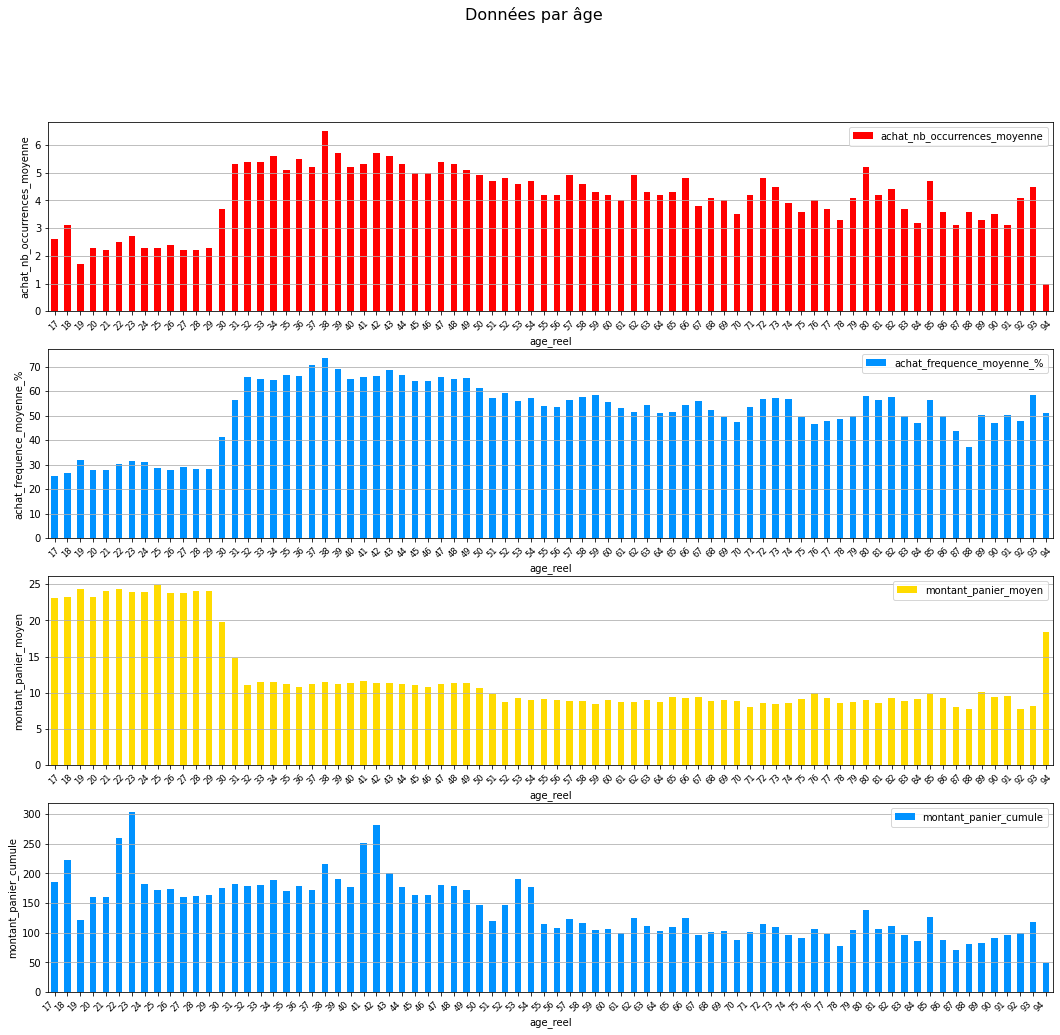

In [233]:
fig, axes = color_graph_background(len(datas_par_age.columns), 1)
fig.set_size_inches(18, 4*len(datas_par_age.columns), forward=True)

i = 0
nb_col = len(colors_list)
for col in datas_par_age.columns:
    color = colors_list[randint(0, nb_col-1)]
    datas_par_age[[col]].plot(kind='bar',stacked=True, ax=axes[i], color=color)
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
    axes[i].set_ylabel(col)
    axes[i].grid(axis='y')
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_size('small')
    i += 1

plt.xticks(rotation=45, ha="right", size='small')
fig.suptitle("Données par âge", fontsize=16)
plt.legend()
plt.show()

In [297]:
sorter_frequence = create_sorter_frequence()
sorter_frequence

['> 8 x ans',
 '8 x ans',
 '7 x ans',
 '6 x ans',
 '5 x ans',
 '4 x ans',
 '3 x ans',
 '<= 2 x ans']

In [302]:
datas_par_age['categorie_frequence'] = datas_par_age['achat_frequence_moyenne_%'].map(categorie_frequence)
datas_par_age.head()

C:\Users\User\AppData\Local\Temp/ipykernel_11708/2654135199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_par_age['categorie_frequence'] = datas_par_age['achat_frequence_moyenne_%'].map(categorie_frequence)


achat_nb_occurrences_moyenne  achat_frequence_moyenne_%  \
age_reel                                                            
17                                 2.6                      25.48   
18                                 3.1                      26.77   
19                                 1.7                      31.99   
20                                 2.3                      27.96   
21                                 2.2                      27.89   

          montant_panier_moyen  montant_panier_cumule categorie_frequence  
age_reel                                                                   
17                       23.08                 184.88             3 x ans  
18                       23.28                 223.34             3 x ans  
19                       24.40                 121.86             4 x ans  
20                       23.23                 160.86             3 x ans  
21                       24.06                 161.13             3 x ans

In [303]:
datas_par_age['categorie_frequence'] = datas_par_age['categorie_frequence'].astype("category")
datas_par_age['categorie_frequence'] = datas_par_age['categorie_frequence'].cat.set_categories(sorter_frequence)

C:\Users\User\AppData\Local\Temp/ipykernel_11708/3629921630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_par_age['categorie_frequence'] = datas_par_age['categorie_frequence'].astype("category")
C:\Users\User\AppData\Local\Temp/ipykernel_11708/3629921630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_par_age['categorie_frequence'] = datas_par_age['categorie_frequence'].cat.set_categories(sorter_frequence)


In [304]:
datas_par_age['categorie_frequence'].value_counts()

6 x ans       23
7 x ans       21
8 x ans       11
3 x ans        9
> 8 x ans      7
4 x ans        5
5 x ans        2
<= 2 x ans     0
Name: categorie_frequence, dtype: int64

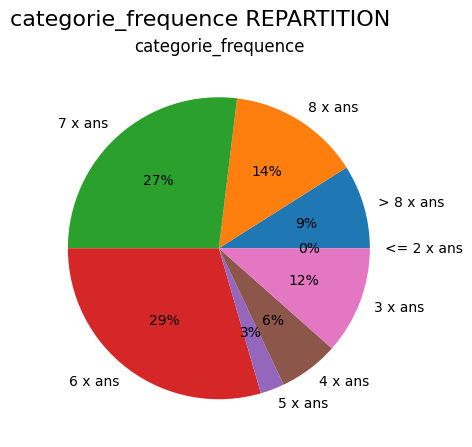

draw_pie categorie_frequence  ................................................. END


In [305]:
draw_pie_multiple(datas_par_age, ['categorie_frequence'],legend=False)

In [306]:
datas_par_age.describe(include="all")

achat_nb_occurrences_moyenne  achat_frequence_moyenne_%  \
count                      78.000000                  78.000000   
unique                           NaN                        NaN   
top                              NaN                        NaN   
freq                             NaN                        NaN   
mean                        4.107692                  51.831667   
std                         1.122355                  12.547235   
min                         1.000000                  25.480000   
25%                         3.500000                  47.342500   
50%                         4.200000                  54.035000   
75%                         4.975000                  59.125000   
max                         6.500000                  73.460000   

        montant_panier_moyen  montant_panier_cumule categorie_frequence  
count              78.000000              78.000000                  78  
unique                   NaN                    NaN                   7  
top                      NaN                    NaN             6 x ans  
freq                     NaN                    NaN                  23  
mean               12.309744             141.935128                 NaN  
std                 5.560543              50.292040                 NaN  
min                 7.720000              48.640000                 NaN  
25%                 8.902500             102.762500                 NaN  
50%                 9.635000             125.225000                 NaN  
75%                11.400000             177.180000                 NaN  
max                24.890000             304.070000                 NaN

In [307]:
datas_par_age["achat_nb_occurrences_moyenne"].nunique()

35

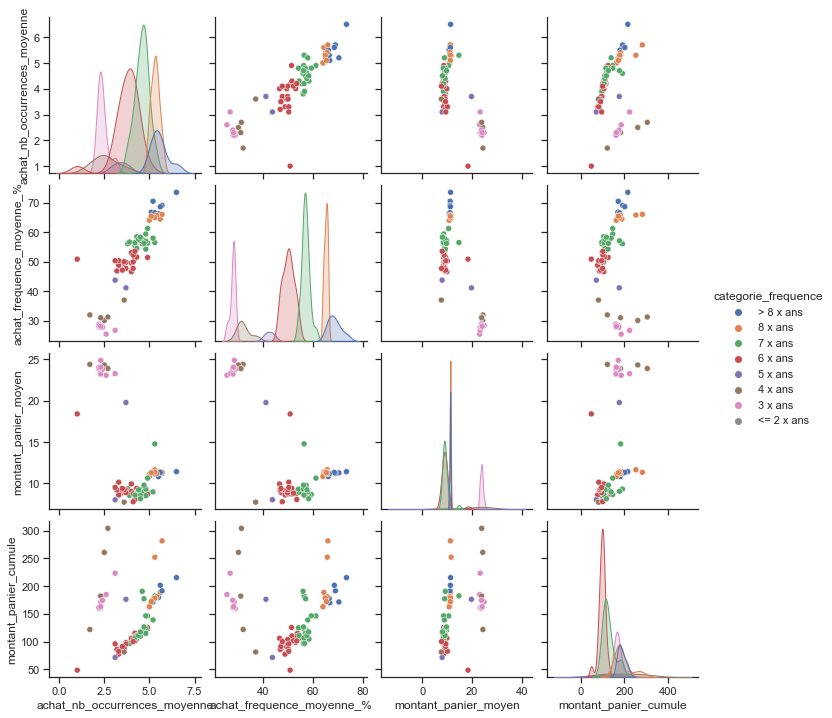

In [308]:
sns.set_theme(style="ticks")
sns.pairplot(datas_par_age, hue="categorie_frequence")

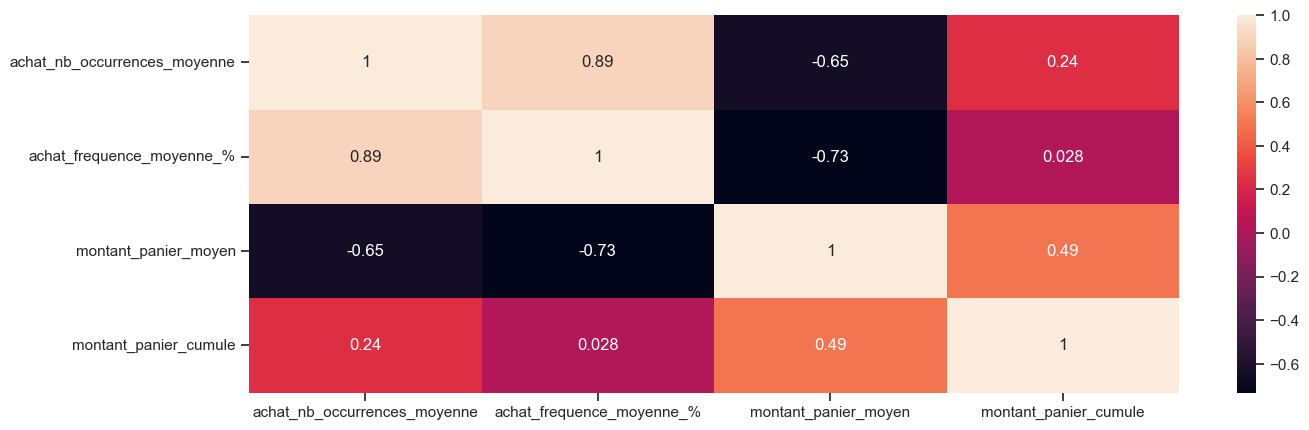

In [342]:
draw_correlation_graphe(datas_par_age, "")

In [381]:
datas_par_age.head()

achat_nb_occurrences_moyenne  achat_frequence_moyenne_%  \
age_reel_an                                                            
17                                    2.6                       0.85   
18                                    3.1                       0.89   
19                                    1.7                       1.07   
20                                    2.3                       0.93   
21                                    2.2                       0.93   

             montant_panier_moyen  montant_panier_cumule categorie_frequence  
age_reel_an                                                                   
17                          23.08                 184.88  Tous les semestres  
18                          23.28                 223.34  Tous les semestres  
19                          24.40                 121.86  Tous les semestres  
20                          23.23                 160.86  Tous les semestres  
21                          24.06                 161.13  Tous les semestres

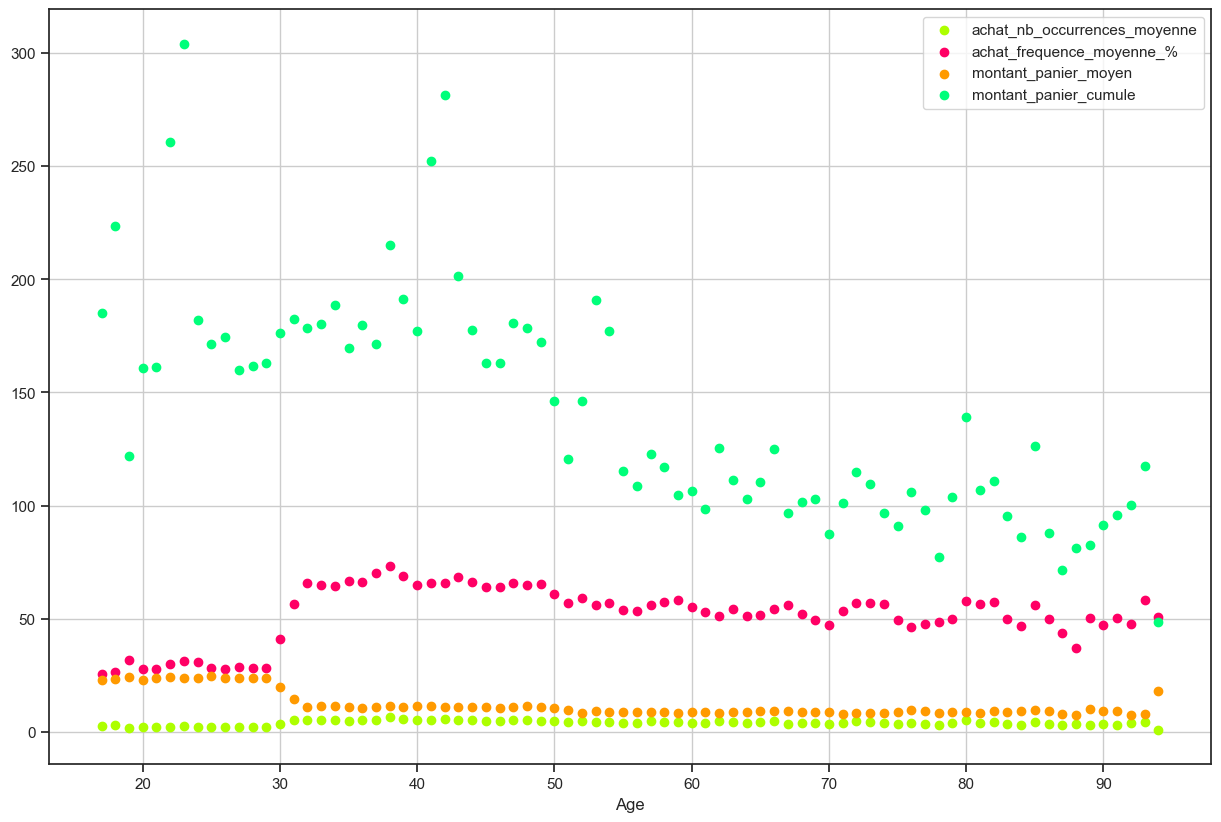

In [309]:
nb_col = len(colors_list)
figure, axe = plt.subplots(1,1)
figure.patch.set_facecolor(PLOT_FIGURE_BAGROUNG_COLOR)

temp = datas_par_age[["achat_nb_occurrences_moyenne","achat_frequence_moyenne_%","montant_panier_moyen","montant_panier_cumule"]]
seed(1)
for colname in temp.columns:
    color = colors_list[randint(0, nb_col-1)]
    axe.scatter(temp.index, temp[colname].values, color=color, label=colname)

axe.legend()
axe.grid(True)
axe.set_xlabel("Age")
figure.set_size_inches(15, 10, forward=True)
figure.set_dpi(100)
plt.show()

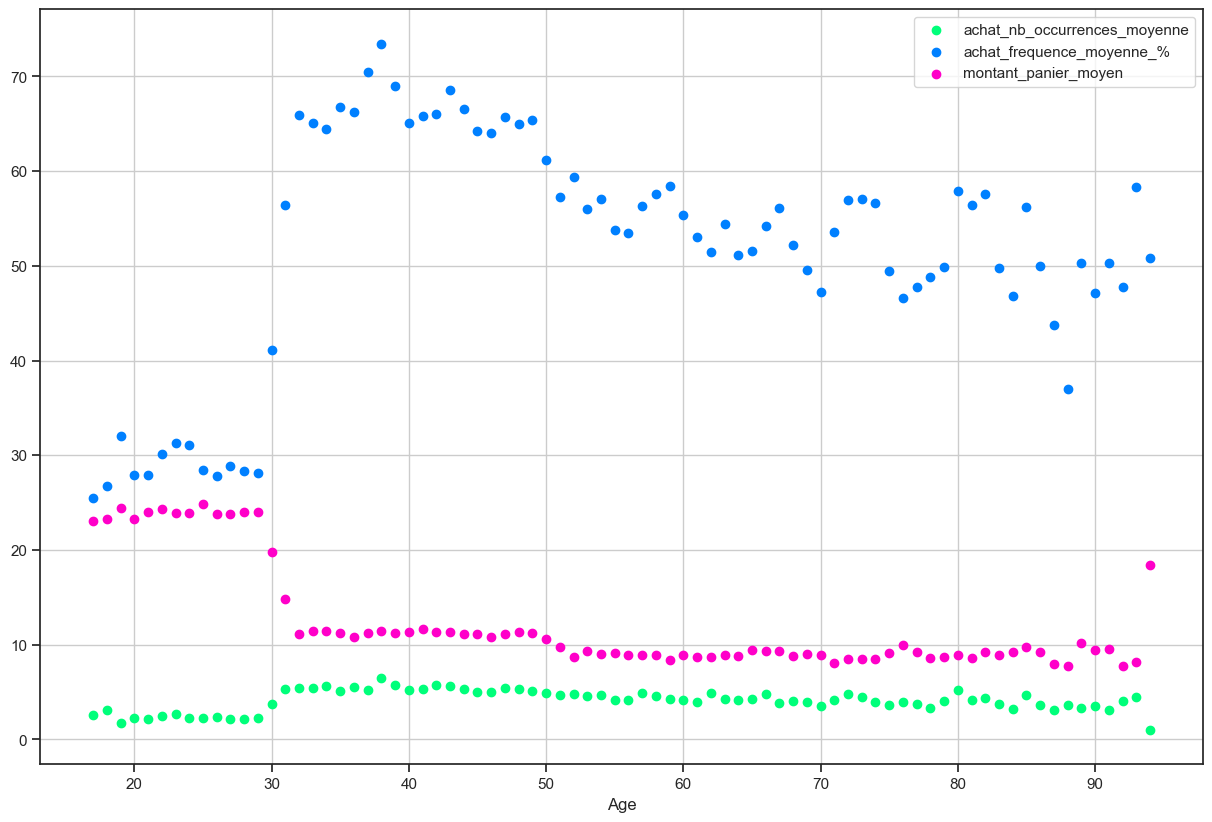

In [310]:
nb_col = len(colors_list)
figure, axe = plt.subplots(1,1)
figure.patch.set_facecolor(PLOT_FIGURE_BAGROUNG_COLOR)

temp = datas_par_age[["achat_nb_occurrences_moyenne","achat_frequence_moyenne_%","montant_panier_moyen"]]
seed(5)
for colname in temp.columns:
    color = colors_list[randint(0, nb_col-1)]
    axe.scatter(temp.index, temp[colname].values, color=color, label=colname)

axe.legend()
axe.grid(True)
axe.set_xlabel("Age")
figure.set_size_inches(15, 10, forward=True)
figure.set_dpi(100)
plt.show()

<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; "></h1>
</div>

# Corrélations

<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; "></h1>
</div>

**Les corrélations indiquent si deux variables sont linéairement équivalentes.**

Voici quelques questions supplémentaires pour nous aider à mieux comprendre les ventes enregistrées.

- Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
- Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?
- Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (nombre d'achats par mois) ?
- Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ?
- Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

Calcul de l'indicateur de corrélation (R², eta², Chi²) et la mise en place d'un test statistique est nécessaire

Pour étudier la relation entre deux variables, posez toujours la question sur les types de nos variables, est-ce-que ce sont des variables
**qualitatives** ou **quantitatives**?
<div style="color: RGB(255,114,0)">
<h3>3 cas possibles :</h3>
- 2 variables quantitatives (Coefficient de Pearson ou Corr(Pearson) dans le cas muti-variables, pour confirmer le résultat penser toujours à faire le nuage des points entre les deux variables  .<br/>
- 2 variables qualitatives (Chi²/khi²) à l'aide d'un tableau contingence).<br/>
- 1 variable quantitatives et 1 qualitative (R² - Analyse en muti-groupes par exemple dans notre cas vérifier s'il existe différence entre sexe et les prix ... ?).<br/>

<div style="background-color: RGB(51,165,182);" ></div> 

## 1. Première approche des corrélations sur l'ensemble de nos variables numériques
<div style="background-color: RGB(51,165,182);" ></div> 

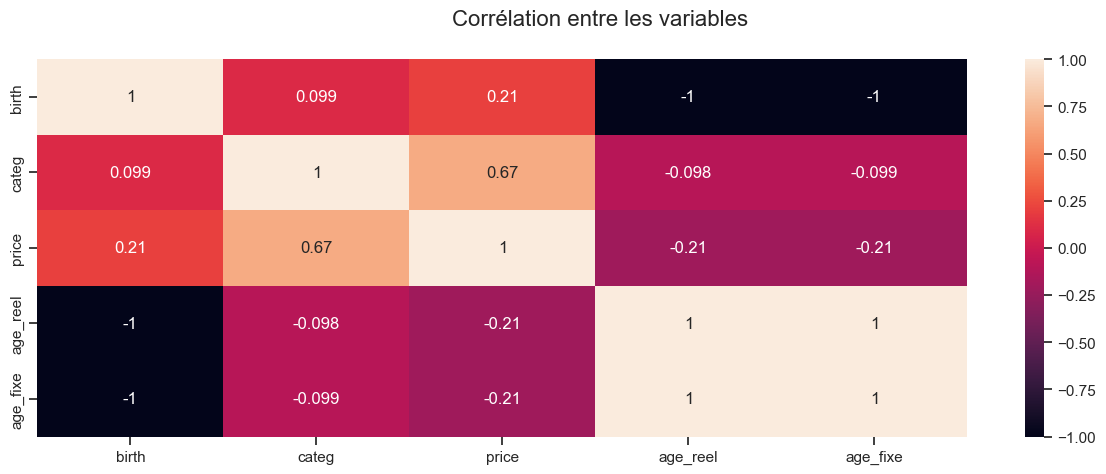

In [311]:
##on utilise data.corr et le heatmap de seborn
draw_correlation_graphe(df_global_index, "Corrélation entre les variables", verbose)

<div style="background-color: RGB(51,165,182);" ></div> 

## 2. Analyse de la corrélation entre le sexe des clients et les catégories de produits achetés
<div style="background-color: RGB(51,165,182);" ></div> 

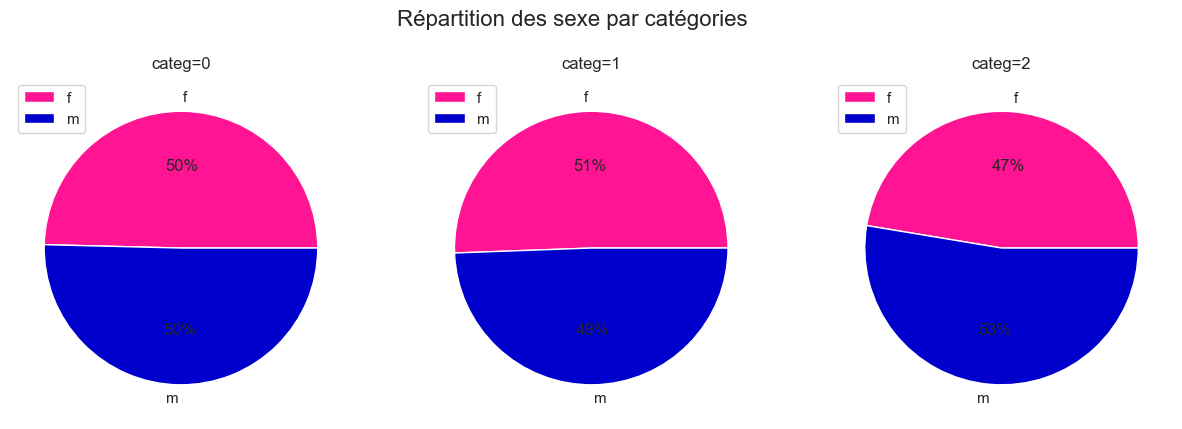

draw_pie_multiple_by_value categ  ................................................. END


In [313]:
colors=["deeppink", "mediumblue"]
draw_pie_multiple_by_value(df_global_index,'categ', df_global_index['categ'].unique(), 'sex', "Répartition des sexe par catégories", verbose=verbose, colors=colors)

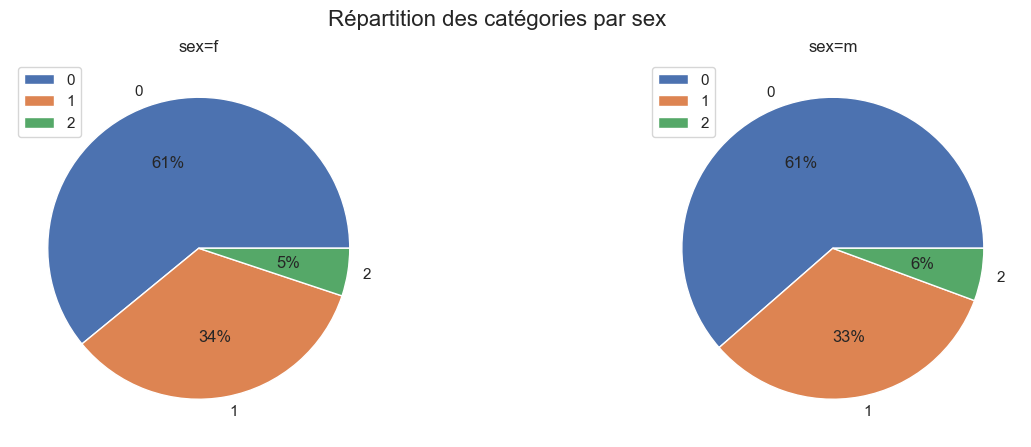

draw_pie_multiple_by_value sex  ................................................. END


In [314]:
draw_pie_multiple_by_value(df_global_index,'sex', df_global_index['sex'].unique(), 'categ', "Répartition des catégories par sex", verbose=verbose)

### 2.2. test khi²/chi² - Entre 2 variables qualitatives

In [315]:
cross_sex_categ = pd.crosstab(df_global_index['sex'],df_global_index['categ'])
cross_sex_categ

categ       0       1      2
sex                         
f      206103  114899  17283
m      209356  112270  19200

In [316]:
(chi2_val, p, degree, expected) = chi2_contingency(observed=cross_sex_categ)
print("chi² val:", chi2_val, "P value:", p, "degree:", degree)
expected

chi² val: 147.11906816131497 P value: 1.1310980597090762e-32 degree: 2


array([[206952.24759281, 113159.50583189,  18173.2465753 ],
       [208506.75240719, 114009.49416811,  18309.7534247 ]])

In [317]:
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

p value is 1.1310980597090762e-32
Dependent (reject H0)


P vaut 0, les variables ne sont donc pas corrélées.

<div style="background-color: RGB(51,165,182);" ></div> 

## 3. Analyse de la corrélation entre l'âge clients et le montant total des achats
<div style="background-color: RGB(51,165,182);" ></div> 

In [ ]:
## pour le visual  nuage des points avec plt.scatter ou plt.plot
## et avec un test de stat on utilise: Coefficient de corrélation linéaire de Pearson 

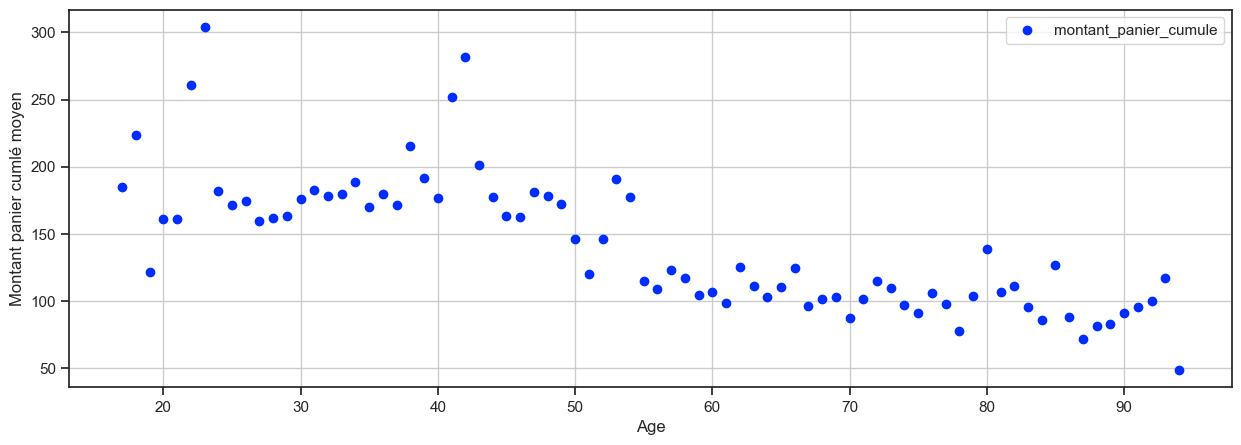

In [318]:
nb_col = len(colors_list)
figure, axe = plt.subplots(1,1)
figure.patch.set_facecolor(PLOT_FIGURE_BAGROUNG_COLOR)

temp = datas_par_age[["montant_panier_cumule"]]
seed(0)
for colname in temp.columns:
    color = colors_list[randint(0, nb_col-1)]
    axe.scatter(temp.index, temp[colname].values, color=color, label=colname)

axe.legend()
axe.grid(True)
axe.set_xlabel("Age")
axe.set_ylabel("Montant panier cumlé moyen")
figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
plt.show()

In [322]:
customers_shop = df_global_index.groupby(['age_reel', 'session_id']).count().reset_index()
customers_shop = customers_shop.groupby('age_reel').mean().reset_index()
customers_shop = customers_shop[['age_reel', 'id_prod']]
customers_shop

age_reel   id_prod
0         17  1.743025
1         18  1.758073
2         19  1.735002
3         20  1.760731
4         21  1.767967
..       ...       ...
73        90  1.500000
74        91  1.794872
75        92  1.390071
76        93  1.500000
77        94  2.555556

[78 rows x 2 columns]

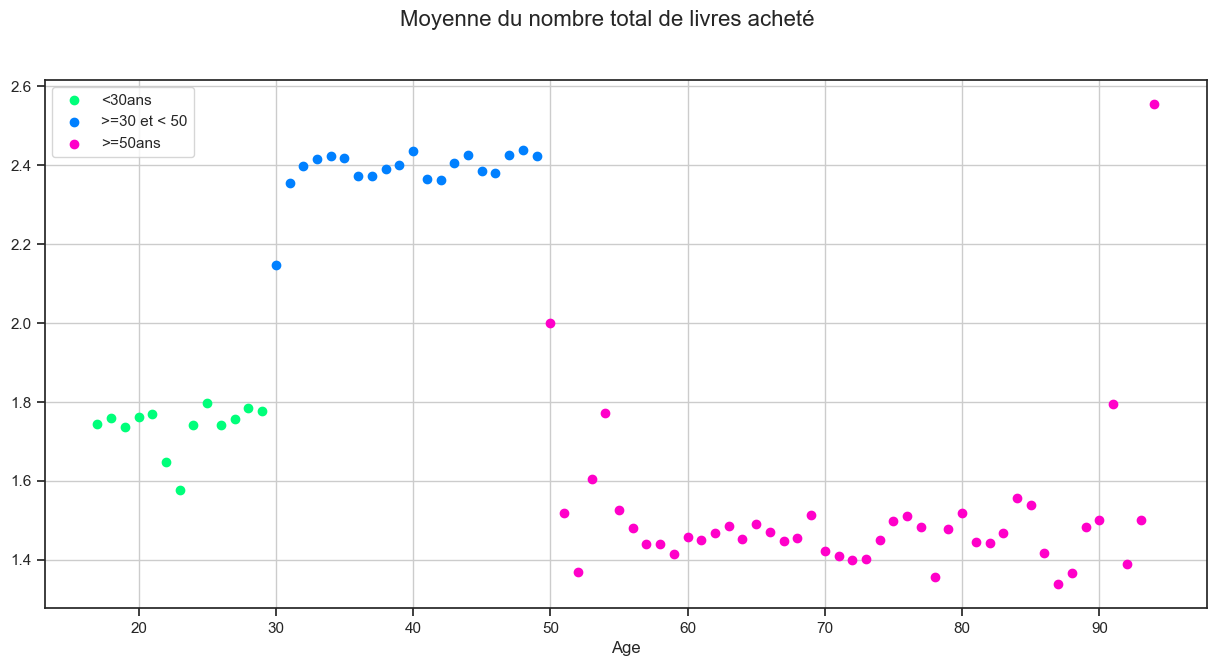

In [336]:
nb_col = len(colors_list)
figure, axe = plt.subplots(1,1)
figure.patch.set_facecolor(PLOT_FIGURE_BAGROUNG_COLOR)

temp = datas_par_age[["achat_nb_occurrences_moyenne","achat_frequence_moyenne_%","montant_panier_moyen"]]
seed(5)
color = colors_list[randint(0, nb_col-1)]
axe.scatter(data=customers_shop[customers_shop["age_reel"]<30], x="age_reel", y="id_prod", color=color, label="<30ans")

color = colors_list[randint(0, nb_col-1)]
axe.scatter(data=customers_shop[(customers_shop["age_reel"]<50)&(customers_shop["age_reel"]>=30)], x="age_reel", y="id_prod", color=color, label=">=30 et < 50")

color = colors_list[randint(0, nb_col-1)]
axe.scatter(data=customers_shop[(customers_shop["age_reel"]>=50)], x="age_reel", y="id_prod", color=color, label=">=50ans")

axe.legend()
axe.grid(True)
axe.set_xlabel("Age")
figure.set_size_inches(15, 7, forward=True)
figure.set_dpi(100)
figure.suptitle("Moyenne du nombre total de livres acheté", fontsize=16)
plt.show()

avec ces résultats nous faisons : soit 9 soit 12 soit la moyenne des res => 9

<div style="background-color: RGB(51,165,182);" ></div> 

##  4. l'âge clients et la fréquence d'achat et l'âge clients et la taille du panier moyen 
<div style="background-color: RGB(51,165,182);" ></div> 
 

In [ ]:
## pour le visual  nuage des points avec plt.scatter ou plt.plot
## et avec un test de stat on utilise: Coefficient de corrélation linéaire de Pearson 

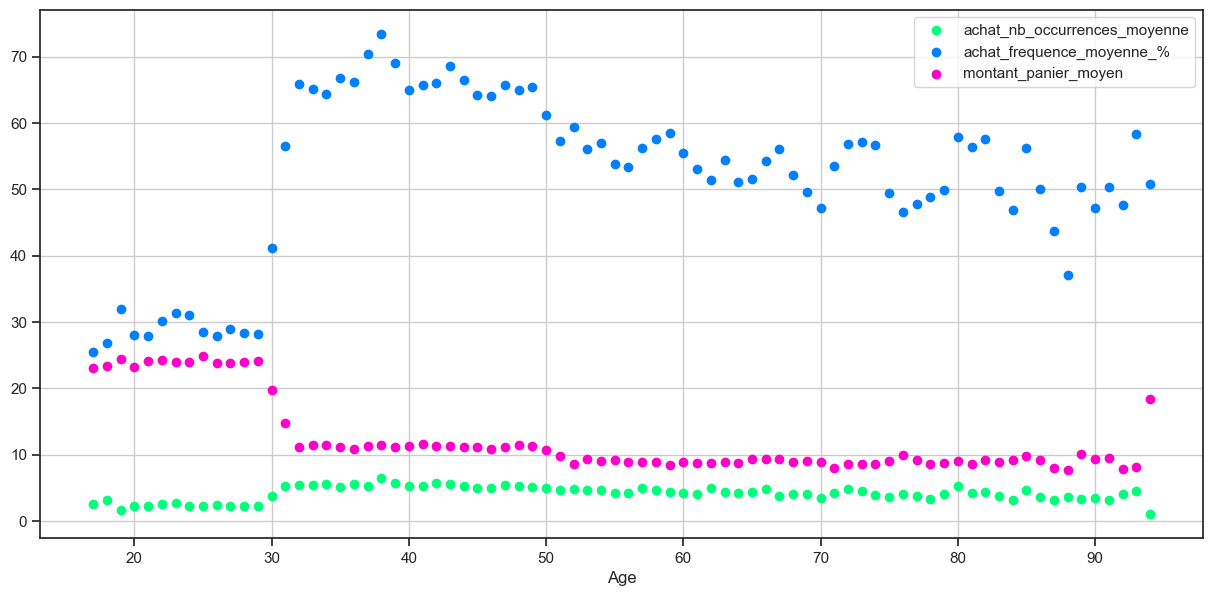

In [337]:
nb_col = len(colors_list)
figure, axe = plt.subplots(1,1)
figure.patch.set_facecolor(PLOT_FIGURE_BAGROUNG_COLOR)

temp = datas_par_age[["achat_nb_occurrences_moyenne","achat_frequence_moyenne_%","montant_panier_moyen"]]
seed(5)
for colname in temp.columns:
    color = colors_list[randint(0, nb_col-1)]
    axe.scatter(temp.index, temp[colname].values, color=color, label=colname)

axe.legend()
axe.grid(True)
axe.set_xlabel("Age")
figure.set_size_inches(15, 7, forward=True)
figure.set_dpi(100)
plt.show()

<div style="background-color: RGB(51,165,182);" ></div> 

## 6. Analyse de la corrélation entre l'âge clients et la catégorie produits
<div style="background-color: RGB(51,165,182);" ></div> 

**Pour simplifier l'analyse, il est nécessaire de procéder par un découpage en catégorie (classe) (discrétisation) . Donc très clairement le but est de pouvoir réduire nos individus "âges" par classes, de manière à pouvoir interpréter plus facilement lesrésultats.**

**Comment choisir le nombre de classes ou des catégories ? (on peut utiliser la fonction qcut )**
Ou bient l'un de deux formules : 

- Sturges-Huntsberger : $k = 1 + 3.33\times\log(N,base=10)$

- Brooks-Carruthers : $k = 5\times\log(N,base=10)$


In [340]:
import math
#N est le nombre d'observations
N = len(df_global_index.groupby(['age_reel', 'categ']).count().reset_index())
#Formule de Huntsberger : 
huntsberger = 1 + ((10/3) * math.log10(N))
#Formule de Brooks-Carruthers : 
brooks_carruthers = 5 * math.log10(N)
print("Huntsberger:", huntsberger)
print("Brooks-Carruthers:", brooks_carruthers)

Huntsberger: 8.891186403420063
Brooks-Carruthers: 11.836779605130094


In [341]:
# hand made : # Création d'un nouveau df des clients par tranches de dates de naissance
# age_clients['annee'] = pd.qcut(df_global_index['birth'], 10, labels=["1920-1930", "1930-1940", "1940-1950","1950-1960","1960-1970","1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"])
#age_clients['annee'] = pd.qcut(df_global_index['birth'], 10, labels=["1920-1930", "1930-1940", "1940-1950","1950-1960","1960-1970","1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"])
df_global_index["age_cut"] = pd.cut(df_global_index['age_reel'], 9, precision=0)
df_global_index.head()


client_id sex  birth session_id id_prod  categ  \
date                                                                        
2022-05-20 13:21:29.043970     c_103   f   1986   s_211425  0_1518      0   
2021-07-20 13:21:29.043970     c_103   f   1986    s_64849  0_1518      0   
2022-08-20 13:21:29.043970     c_103   f   1986   s_255965  0_1518      0   
2022-06-18 01:49:37.823274     c_103   f   1986   s_225411  0_1418      0   
2021-08-18 01:49:37.823274     c_103   f   1986    s_77214  0_1418      0   

                            price month_year  year         day tranche_prix  \
date                                                                          
2022-05-20 13:21:29.043970   4.18    2022-05  2022  2022-05-20       < 10 €   
2021-07-20 13:21:29.043970   4.18    2021-07  2021  2021-07-20       < 10 €   
2022-08-20 13:21:29.043970   4.18    2022-08  2022  2022-08-20       < 10 €   
2022-06-18 01:49:37.823274   8.57    2022-06  2022  2022-06-18       < 10 €   
2021-08-18 01:49:37.823274   8.57    2021-08  2021  2021-08-18       < 10 €   

                            age_reel     tranche_age  age_fixe       age_cut  
date                                                                          
2022-05-20 13:21:29.043970        36  de 30 à 40 ans        35  (34.0, 43.0]  
2021-07-20 13:21:29.043970        35  de 30 à 40 ans        35  (34.0, 43.0]  
2022-08-20 13:21:29.043970        36  de 30 à 40 ans        35  (34.0, 43.0]  
2022-06-18 01:49:37.823274        36  de 30 à 40 ans        35  (34.0, 43.0]  
2021-08-18 01:49:37.823274        35  de 30 à 40 ans        35  (34.0, 43.0]